In [1]:
import numpy, pandas, datetime, sys, os
import matplotlib, seaborn
import re, math, time, scipy
import sqlite3, IPython.display, sqlalchemy, statsmodels, ete3, svgutils.transform
import lxml.etree, gseapy, mygene
import itertools
import igraph
import upsetplot
import random
import subprocess
import importlib
from svgpathtools import svg2paths
from sqlalchemy.types import *
import statsmodels
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from networkx.drawing.nx_agraph import write_dot
from decimal import Decimal

sys.path.append('/Users/kef74yk/Dropbox_w/repos/kftools')
sys.path.append('/Users/kef74yk/Dropbox_w/repos/kftools/kftools')

import kftools
kftools = importlib.reload(kftools)
from kftools import kfplot
from kftools import kfutil
from kftools import kfstat

font_size = 8

%matplotlib inline
pandas.options.display.max_rows=10
pandas.options.display.max_columns=1000
seaborn.set_style("white")
seaborn.set_style("ticks")
matplotlib.rcParams['font.size'] = font_size
#matplotlib.rcParams['font.family'] = 'Helvetica'
#matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
matplotlib.rcParams['svg.fonttype'] = 'none' # none, path, or svgfont

matplotlib.rc('xtick', labelsize=font_size)
matplotlib.rc('ytick', labelsize=font_size)
matplotlib.rc('font', size=font_size)
matplotlib.rc('axes', titlesize=font_size)
matplotlib.rc('axes', labelsize=font_size)
matplotlib.rc('xtick', labelsize=font_size)
matplotlib.rc('ytick', labelsize=font_size)
matplotlib.rc('legend', fontsize=font_size)
matplotlib.rc('figure', titlesize=font_size)

In [2]:
omega_method = 'mapdnds' # 'hyphy' or 'mapdnds'
#l1ou_criterion = 'AICc'
#expression_unit = 'TPM' # 'FPKM', 'TPM'
#intersect_fpkm_tpm = False
sptree_root = 'sp_root'

dir_data = '/Users/kef74yk/Dropbox_p/data/'
wd = os.path.join(dir_data, "04_transcriptome_amalgamation/20190701_orthogroup_stat_analysis/out/")
dir_ensembl = os.path.join(dir_data, '/Users/kef74yk/Dropbox_p/db/Ensembl/release-91/')
#db_file = os.path.join(dir_ensembl, 'orthogroup/Ensembl.91.orthogroup.'+l1ou_criterion+'.db')
db_file = os.path.join(dir_ensembl, 'orthogroup/Ensembl.91.orthogroup.db')
sptree_file = os.path.join(dir_ensembl, 'timetree/species_timetree.nwk')
phylopic_dir = os.path.join(dir_ensembl, 'phylopic/svg_files/')
inkscape='/Applications/Inkscape.app/Contents/Resources/bin/inkscape'
if not (os.path.exists(wd)):
    os.mkdir(wd)
os.chdir(wd)


font_size = 8
max_delta_intron_present=-0.5
pcm_prefixes = ['l1ou_fpkm_','l1ou_tpm_',]
shift_columns = ['l1ou_fpkm_is_shift','l1ou_tpm_is_shift','l1ou_intersect_is_shift']
branch_categories = ['S','D','R']
category_colors = {'S':'#0033cc', 'D':'#cc0000', 'R':'#e59400'}
organs = ['brain','heart','kidney','liver','ovary','testis']
organ_colors = ['#1B9E77','#D95F02','#7570B3','#E7298A','#66A61E','#E6AB02']

organ_colors_dict = dict()
for o,c in zip(organs,organ_colors):
    organ_colors_dict[o] = c 

In [3]:
def attach_neighbor_stats(df, neighbor, columns=[]):
    columns = ['orthogroup','numerical_label',] + columns
    df_tmp = df.loc[:,columns]
    df_tmp.columns = neighbor+'_'+pandas.Series(df_tmp.columns).astype(str)
    right_on = [neighbor+'_orthogroup',neighbor+'_numerical_label']
    df = pandas.merge(df, df_tmp, left_on=['orthogroup',neighbor], right_on=right_on, how='left')
    df = df.drop(right_on, axis=1)
    return df

def my_distplot(x, df, ax, kde, xlab, norm_hist, x_range):
    seaborn.distplot(df[x], ax=ax, kde=kde, norm_hist=norm_hist, color='black')
    ax.tick_params(axis='both', which='major', direction='in', length=6, width=1)
    ax.set_xlabel(xlab)
    if norm_hist:
        ax.set_ylabel('Frequency')
    else:
        ax.set_ylabel('Count')
    if (len(x_range)>1)&(type(x_range)!=str):
        ax.set_xlim(x_range[0], x_range[1])
        
def my_barplot(x, y, ax, xlab, ylab):
    seaborn.barplot(x=x, y=y, ax=ax, color='gray')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.tick_params(axis='both', which='major', direction='in', length=6, width=1)

def add_missing_data(df, index=[], columns=[]):
    try:
        del df.index.name
    except:
        0
    try:
        del df.columns.name
    except:
        0
    for ind in index:
        if not ind in df.index:
            df = pandas.concat([df, pandas.DataFrame(0, index=[ind,], columns=df.columns)], axis=0)
    for col in columns:
        if not col in df.columns:
            df = pandas.concat([df, pandas.DataFrame(0, index=df.index, columns=[col,])], axis=1)
    df = df.sort_index(axis=0)
    df = df.sort_index(axis=1)
    return df

def add_igraph_legends(svg_file, height, width, texts=[]):
    font_size = 8
    font_family = 'Helvetica'
    fig = svgutils.transform.SVGFigure(str(width)+"pt", str(height)+"pt")
    figs = list()
    figs.append(svgutils.transform.fromfile(svg_file))
    plots = list()
    for i in range(len(figs)):
        plots.append(figs[i].getroot())
    plots[0].moveto(x=0, y=0, scale=1)
    txts = list()
    for i in range(len(texts)):
        txts.append(svgutils.transform.TextElement(x=0, y=font_size*(i+2), text=texts[i], size=font_size, weight="normal", font=font_family))
    fig.append(plots)
    fig.append(txts)
    fig.save(svg_file)

def calc_symmetry(pivot_table):
    if not type(pivot_table)==type(pandas.DataFrame()):
        pivoto_table = pivot_table * (numpy.eye(pivot_table.shape[0], pivot_table.shape[1])==0)
        pivot_table = pandas.DataFrame(pivot_table)
    pivot_table = pivot_table.fillna(0)
    organs = list(set(pivot_table.index.tolist()).intersection(set(pivot_table.columns.tolist())))
    dif = 0
    for i in itertools.combinations(organs, 2):
        if i[0]!=i[1]:
            dif = dif + numpy.abs(pivot_table.loc[i[0],i[1]] - pivot_table.loc[i[1],i[0]])
    symmetry = 1 - (dif/pivot_table.sum().sum())
    return(symmetry)

def integrate_pcm_stats(df, pcm_prefix, drop=False):
    num_og_before = 0
    df['pcm_method'] = ''
    for pp in pcm_prefix:
        pp_columns = df.columns[df.columns.str.startswith(pp)]
        for ppc in pp_columns:
            new_column = ppc.replace(pp, '')
            if not (new_column in df.columns):
                df[new_column] = df[ppc]
            else:
                df.loc[df[new_column].isnull(), new_column] = df.loc[df[new_column].isnull(), ppc]
        if drop:
            df = df.drop(pp_columns, axis=1)
        col = 'regime' if 'regime' in df.columns else 'num_regime'
        df.loc[(~df[col].isnull())&(df['pcm_method']==''),'pcm_method'] = re.sub('_$','',pp)
        num_og_after = df.loc[(~df[col].isnull()),'orthogroup'].drop_duplicates().shape[0]
        print(pp, ': number of added orthogroups =', num_og_after - num_og_before)
        num_og_before = num_og_after
    return df

def add_max_mu(df=pandas.DataFrame(), cols=[], new_col=''):
    df[new_col] = df.loc[:,cols].idxmax(axis=1)    
    num_null_before = df[new_col].isnull().sum()
    tmp = df.loc[:,cols].values
    row_max = tmp.max(axis=1)
    for i in numpy.arange(tmp.shape[1]):
        tmp[:,i] = tmp[:,i] - row_max
    is_multiple_max = ((tmp==0).sum(axis=1)!=1)
    df.loc[is_multiple_max,new_col] = numpy.nan
    num_null_after = is_multiple_max.sum()
    print(new_col, ':', num_null_after-num_null_before, 'tie max values were detected')
    return df

def shift_freq_bootstrap(df1, var1='parent_max_organ', var2='max_organ', down_reg=True, up_reg=True, 
                         exclude_self=True, nboot=1000, nsubsample=numpy.inf):
    if exclude_self:
        df1 = df1.loc[(df1[var1]!=df1[var2]),:]
    if df1.shape[0]>nsubsample:
        df1 = df1.loc[numpy.random.choice(df1.index, nsubsample, replace=False),:]
    df1 = df1.sort_values(axis=0, by=[var1, var2])
    df1 = df1.reset_index()
    N = df1.shape[0]
    print('N after filtering =', N)
    all_organs = pandas.concat([df1[var1],df1[var2]]).dropna().unique()
    all_organs.sort()
    observed = pandas.DataFrame(df1.groupby([var1,var2])['orthogroup'].count())
    observed = observed.reset_index().pivot(var1, var2)
    colnames = observed.columns.get_level_values(1)
    observed = observed.T.reset_index(drop=True).T
    observed.columns = colnames
    observed = observed.fillna(0)
    observed = add_missing_data(df=observed, index=all_organs, columns=all_organs)
    if exclude_self:
        observed_total = observed.sum().sum()
        index_values = observed.index
        column_values = observed.columns
        self_true = numpy.array([ i==c for i in index_values for c in column_values ]).reshape([index_values.shape[0],column_values.shape[0]])
    nrep = nboot
    num_var1 = df1[var1].unique().shape[0]
    num_var2 = df1[var2].unique().shape[0]
    axis = [nrep, observed.shape[0], observed.shape[1]]
    bs = numpy.zeros(axis, dtype=numpy.int64)
    replace=False
    for i in numpy.arange(nrep):
        df3 = df1.loc[:,:]
        if replace:
            df3.loc[:,var1] = df3.loc[numpy.random.choice(df3.index, size=df3.shape[0], replace=replace),var1].values
        df3.loc[:,var2] = df3.loc[numpy.random.choice(df3.index, size=df3.shape[0], replace=replace),var2].values
        pivot = pandas.DataFrame(df3.groupby([var1,var2])['orthogroup'].count())
        pivot = pivot.reset_index().pivot(var1, var2)
        pivot.columns = pivot.columns.get_level_values(1)
        if replace:
            if not observed.index.shape[0]==pivot.index.shape[0]:
                organs = list(set(observed.columns.tolist() + observed.index.tolist()))
                missings = [ pcol for pcol in organs if not pcol in pivot.index ]
                for missing in missings:
                    pivot.loc[missing,:] = 0
            if not observed.columns.shape[0]==pivot.columns.shape[0]:
                organs = list(set(observed.columns.tolist() + observed.index.tolist()))
                missings = [ pcol for pcol in organs if not pcol in pivot.columns.get_level_values(1) ]
                for missing in missings:
                    pivot['orthogroup',missing] = 0
        pivot = add_missing_data(df=pivot, index=all_organs, columns=all_organs)
        pivot = pivot.fillna(0).values
        if exclude_self:
            pivot[self_true] = 0
            pivot = pivot / pivot.sum().sum() * observed_total
        bs[i,:,:] = pivot
        del df3
    del df1
    col_sum = observed.sum(axis=0)
    row_sum = observed.sum(axis=1)
    col_sum = numpy.expand_dims(col_sum, axis=0)
    row_sum = numpy.expand_dims(row_sum, axis=1)
    col_freq = col_sum / col_sum.sum().sum()
    row_freq = row_sum / row_sum.sum().sum()
    expected = numpy.array(col_freq * row_freq)
    if exclude_self:
        expected[self_true] = 0
    expected = expected / expected.sum().sum() * observed.sum().sum()
    expected = pandas.DataFrame(expected)
    expected.index = observed.index
    expected.columns = observed.columns
    corrected = observed/expected.values
    corrected = add_missing_data(df=corrected, index=all_organs, columns=all_organs)
    corrected = corrected.fillna(0)

    return(corrected,observed,expected,bs,N)

def draw_network(corrected, observed, expected, bs, self_arrow=False, self_vertex_size=False, show_vertex_stat=False, 
                 edge_width=1, hide_nonsig=False, coordinates=None, test='random'):
    bs_mean = pandas.DataFrame(bs.mean(axis=0))
    bs_conf95lower = pandas.DataFrame(numpy.percentile(bs, axis=0, q=2.5))
    bs_conf95upper = pandas.DataFrame(numpy.percentile(bs, axis=0, q=97.5))
    bs_conf99lower = pandas.DataFrame(numpy.percentile(bs, axis=0, q=0.5))
    bs_conf99upper = pandas.DataFrame(numpy.percentile(bs, axis=0, q=99.5))
    bs_IQRlower = pandas.DataFrame(numpy.percentile(bs, axis=0, q=25))
    bs_IQRupper = pandas.DataFrame(numpy.percentile(bs, axis=0, q=75))
    for bs in [bs_mean,bs_conf95lower,bs_conf95upper,bs_conf99lower,bs_conf99upper,bs_IQRlower,bs_IQRupper]:
        bs.index = observed.index
        bs.columns = observed.columns
    g = igraph.Graph(directed=True)
    vertices = pandas.Series(list(set(corrected.index.tolist()+corrected.columns.tolist())))
    vertex_weights = list()
    vertex_labels = list()
    vertex_colors = list()
    tissue_colors={'brain':'#1B9E77','heart':'#D95F02','kidney':'#7570B3','liver':'#E7298A','ovary':'#66A61E','testis':'#E6AB02'}
    my_coordinates = list()
    for organ in vertices:
        if (organ in corrected.index)&(organ in corrected.columns):
            vertex_weights.append(corrected.loc[organ,organ])
            n_parent = str(int(observed.loc[organ,:].sum().sum()))
            n_child = str(int(observed.loc[:,organ].sum().sum()))
            organ = organ.replace('-', '\n')
            if show_vertex_stat:
                vertex_labels.append(organ+'\n'+n_parent+':'+n_child)
            else:
                vertex_labels.append(organ)
        else:
            vertex_labels.append(organ)
            vertex_weights.append(1)
            if show_vertex_stat:
                organ = organ.replace('-', '\n')
                vertex_labels.append(organ)
        if organ in tissue_colors.keys():
            vertex_colors.append(tissue_colors[organ])
        else:
            vertex_colors.append('darkgray')
        if coordinates is not None:
            my_coordinates.append(coordinates[organ])
    g.add_vertices(vertices)
    edge_weights = list()
    edge_colors = list()
    edge_labels = list()
    edge_curves = list()
    if test=='rank':
        df_rank = pandas.DataFrame(observed.values.flatten())
        df_rank = df_rank.rank()
        df_rank = numpy.reshape(df_rank.values, newshape=observed.shape)
        df_rank = df_rank - min(observed.shape) # setting baseline by excluding diagonal elements
        numpy.fill_diagonal(a=df_rank, val=0)
        df_rank = pandas.DataFrame(df_rank).astype(int)
        df_rank.index = observed.index
        df_rank.columns = observed.columns
        rank_colors = kfutil.get_rgb_gradient(ncol=int(df_rank.max().max()), col1=[0,0,1], col2=[1,0,0], colm=[0.5,0.5,0.5])
    for organ1 in corrected.index:
        for organ2 in corrected.columns:
            flag = True if (self_arrow)|(self_vertex_size) else organ1!=organ2
            if flag:
                organ1id = vertices.loc[vertices==organ1].index.values[0]
                organ2id = vertices.loc[vertices==organ2].index.values[0]
                corrected_value = corrected.loc[organ1,organ2]
                expected_value = expected.loc[organ1,organ2]
                observed_value = observed.loc[organ1,organ2]
                if test=='random':
                    if (observed_value==int(observed_value)):
                        edge_label = str(int(observed_value))+'/'+str(int(numpy.round(expected_value, decimals=0)))
                    else:
                        edge_label = str(numpy.round(observed_value, decimals=2))+'/'+str(numpy.round(expected_value, decimals=2))
                    color = igraph.color_name_to_rgba('#808080')
                    if observed.loc[organ1,organ2] < bs_IQRlower.loc[organ1,organ2]:
                        color = igraph.color_name_to_rgba('#808080')
                    if observed.loc[organ1,organ2] < bs_conf95lower.loc[organ1,organ2]:
                        color = igraph.color_name_to_rgba('#40C040')
                    if observed.loc[organ1,organ2] < bs_conf99lower.loc[organ1,organ2]:
                        color = igraph.color_name_to_rgba('#00FF00')
                    if observed.loc[organ1,organ2] > bs_IQRupper.loc[organ1,organ2]:
                        color = igraph.color_name_to_rgba('#808080')
                    if observed.loc[organ1,organ2] > bs_conf95upper.loc[organ1,organ2]:
                        color = igraph.color_name_to_rgba('#C040C0')
                    if observed.loc[organ1,organ2] > bs_conf99upper.loc[organ1,organ2]:
                        color = igraph.color_name_to_rgba('#FF00FF')
                elif test=='chisq':
                    parentY_childY = observed.loc[(observed.index==organ1), (observed.columns==organ2)].sum().sum()
                    parentY_childN = observed.loc[(observed.index==organ1), (observed.columns!=organ2)].sum().sum()
                    parentN_childY = observed.loc[(observed.index!=organ1), (observed.columns==organ2)].sum().sum()
                    parentN_childN = observed.loc[(observed.index!=organ1), (observed.columns!=organ2)].sum().sum()
                    cont_table = pandas.DataFrame([[parentY_childY, parentY_childN],[parentN_childY, parentN_childN]])
                    chi2_out = scipy.stats.chi2_contingency(observed=cont_table, correction=True)
                    chi2 = chi2_out[0]
                    pvalue = chi2_out[1]
                    print(organ1, organ2, chi2, pvalue)
                    print('test = chisq. This option is not yet implemented.')
                elif test=='rank':
                    rank = int(df_rank.loc[organ1,organ2])
                    rgb = rank_colors[rank-1]
                    hex_color = kfutil.rgb_to_hex(rgb[0],rgb[1],rgb[2])
                    color = igraph.color_name_to_rgba(hex_color)
                    edge_label = ''
                g.add_edges([(organ1id,organ2id),])
                if edge_width=='observed':
                    edge_weight = 0.5
                    if observed_value >= 10:
                        edge_weight = 1
                    if observed_value >= 100:
                        edge_weight = 2
                else:
                    edge_weight = edge_width
                edge_weights.append(edge_weight)
                edge_colors.append(color)
                edge_labels.append(edge_label)
                edge_curve = -0.05
                if (organ1 not in corrected.columns)|(organ2 not in corrected.index):
                    edge_curve = 0
                edge_curves.append(edge_curve)
    if hide_nonsig:
        for i in range(len(edge_labels)):
            if edge_colors[i]==igraph.color_name_to_rgba('#808080'):
                edge_labels[i] = ''
    visual_style = {}
    visual_style["vertex_size"] = [ v*20 for v in vertex_weights ] if self_vertex_size else 26#27
    visual_style["vertex_label"] = vertex_labels
    visual_style["vertex_color"] = vertex_colors
    visual_style["vertex_label_color"] = 'black'
    visual_style["vertex_label_size"] = 8 if show_vertex_stat else 8
    visual_style["edge_width"] = edge_weights
    visual_style["edge_arrow_size"] = 0.5
    visual_style["edge_label"] = edge_labels
    visual_style["edge_label_size"] = 6
    visual_style["edge_label_color"] = edge_colors
    visual_style["edge_color"] = edge_colors
    visual_style["edge_curved"] = edge_curves
    #random.seed(22) #15 #6 #9
    if coordinates is None:
        layout = g.layout("circular")#"kk"
    else:
        layout = my_coordinates
    return(g,layout,visual_style)

def ols_annotations(x, y, data=None, ax=None, color='black', font_size=8, textxy=[0.05,0.95], textva='top', 
                    method='quantreg', stats=['N','slope','slope_p']):
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    if data is None:
        data = pandas.DataFrame({'X':x,'Y':y})
        x = 'X'
        y = 'Y'
    data = data.sort_values(x)
    if method=='ols':
        X = sm.add_constant(data.loc[:,x])
        Y = data.loc[:,y]
        mod = sm.OLS(Y, X)
        res = mod.fit()
    elif method=='quantreg':
        mod = smf.quantreg(y+' ~ '+x, data)
        res = mod.fit(q=0.5)     
    N = data.shape[0]
    slope = res.params[x]
    slope_p = res.pvalues[x]
    rsquared = res.rsquared_adj
    rsquared_p = res.f_pvalue
    text = ''
    for stat in stats:
        if stat=='N':
            text += 'N = {:,}\n'.format(N)
        if stat=='slope':
            text += 'slope = {}\n'.format('%.2f'%Decimal(slope))
        if stat=='slope_p':
            text += 'P = {}\n'.format('%.2E'%Decimal(slope_p))
        if stat=='rsquared':
            text += 'R2 = {}\n'.format('%.2f'%Decimal(rsquared))
        if stat=='rsquared_p':
            text += 'P = {}\n'.format('%.2E'%Decimal(rsquared_p))
    ax.text(textxy[0], textxy[1], text, transform=ax.transAxes, va=textva, color=color, fontsize=font_size)
    xmin = data.loc[:,x].min()
    xmax = data.loc[:,x].max()
    ax.plot(data[x].values[[0,N-1]], res.predict()[[0,N-1]], color=color)
    
def get_quantile(observed, bs):
    q = observed.copy()
    q.loc[:,:] = numpy.nan
    for i in range(q.shape[0]):
        for c in range(q.shape[1]):
            gt_count = (observed.iloc[i,c]>bs[:,i,c]).sum()
            ge_count = (observed.iloc[i,c]>=bs[:,i,c]).sum()
            corrected_rank = (gt_count + ge_count)/2
            q.iloc[i,c] = corrected_rank/bs.shape[0]
    return q

def get_quantile_fdr(quantile, fdr_threshold=0.001, tail='both'):
    q2 = quantile.copy()
    if tail=='both':
        q2[q2<0.5] = 1-q2[q2<0.5]
    f = q2.values.flat
    decimals = 0
    thresholds = numpy.array([])
    for d in numpy.arange(1,10):
        start = 1-(10**(-float(d-1)))
        end = 1-(10**(-float(d)))
        step = (10**(-float(d-1)))/1000
        tmp = numpy.arange(start, end, step)
        thresholds = numpy.concatenate((thresholds, tmp))
        if all(f==numpy.round(f, decimals=d)):
            decimals = d
            break
    if decimals!=0:
        print('Inferred number of permutations:', 10**decimals)
    else:
        print('Number of permutations could not be inferred.')
    num_data = q2.shape[0] * q2.shape[1]
    for i in numpy.arange(len(thresholds)):
        fdr = ((1-thresholds[i])*num_data)/((f > thresholds[i]).sum())
        if fdr<fdr_threshold:
            quantile_threshold = thresholds[i]
            print('FDR={}, Quantile threshold={}'.format(fdr, quantile_threshold))
            break
        assert i<(len(thresholds)-1), 'No quantile threshold satisfied FDR threshold.'
    fdrs = q2 > quantile_threshold
    return fdrs

def draw_network2(observed, quantile, fdrs, self_arrow=False, self_vertex_size=False, show_vertex_stat=False, no_obs=True,
                 edge_width=False, edge_width_weight=None, hide_nonsig=False, vertex_dict=None, coordinates=None,
                show_edge_color=True, scaled_edge_curve=False, relative_freq_edge_width=False, no_fp=False, sig_color='bluered'):
    g = igraph.Graph(directed=True)
    if sig_color=='bluered':
        high_color = '#FF0000'
        low_color = '#0000FF'
    elif sig_color=='greenpink':
        high_color = '#FF00FF'
        low_color = '#00FF00'
    if vertex_dict is None:
        vertices = pandas.Series(list(set(observed.index.tolist()+observed.columns.tolist())))
        vertex_colors = 'darkgray'
    else:
        vertices = pandas.Series(vertex_dict['vertex'])
        vertex_colors = pandas.Series(vertex_dict['color'])
    vertex_weights = list()
    vertex_labels = list()
    my_coordinates = list()
    for v in vertices:
        if (v in observed.index)&(v in observed.columns):
            vertex_weights.append(observed.loc[v,v])
            n_parent = str(int(observed.loc[v,:].sum().sum()))
            n_child = str(int(observed.loc[:,v].sum().sum()))
            v = v.replace('-', '\n')
            if show_vertex_stat:
                vertex_labels.append(v+'\n'+n_parent+':'+n_child)
            else:
                vertex_labels.append(v)
        else:
            vertex_labels.append(v)
            vertex_weights.append(1)
            if show_vertex_stat:
                v = v.replace('-', '\n')
                vertex_labels.append(v)
        if coordinates is not None:
            my_coordinates.append(coordinates[v])
    g.add_vertices(vertices)
    edge_weights = list()
    edge_colors = list()
    edge_labels = list()
    edge_curves = list()
    for v1 in observed.index:
        for v2 in observed.columns:
            flag = True if (self_arrow)|(self_vertex_size) else v1!=v2
            if (no_fp)&(v1 in ['F','P'])&(v2 in ['F','P']):
                flag = False
            if flag:
                v1id = vertices.loc[vertices==v1].index.values[0]
                v2id = vertices.loc[vertices==v2].index.values[0]
                observed_value = observed.loc[v1,v2]
                edge_label = str(int(observed_value))
                color = igraph.color_name_to_rgba('#808080')
                if (fdrs.loc[v1,v2])&(quantile.loc[v1,v2]<0.5):
                    color = igraph.color_name_to_rgba(low_color)
                else:
                    if (not no_obs)&(observed.loc[v1,v2]==0):
                        continue
                if (fdrs.loc[v1,v2])&(quantile.loc[v1,v2]>0.5):
                    color = igraph.color_name_to_rgba(high_color)
                g.add_edges([(v1id,v2id),])
                edge_weight = 0.5                
                if edge_width=='discrete':                
                    if observed_value >= 10:
                        edge_weight = 1
                    if observed_value >= 100:
                        edge_weight = 2
                elif edge_width=='identity':
                    edge_weight = observed_value+1
                elif edge_width=='log':
                    edge_weight = numpy.log2(observed_value+1)
                edge_weights.append(edge_weight)
                edge_colors.append(color)
                edge_labels.append(edge_label)
                edge_curve = -0.2 if (len(vertices) < 5) else -0.01
                if (v1 not in observed.columns)|(v2 not in observed.index):
                    edge_curve = 0
                if scaled_edge_curve:
                    v1coordinate = my_coordinates[v1id]
                    v2coordinate = my_coordinates[v2id]
                    euclidean_dist = numpy.linalg.norm(numpy.array(v1coordinate)-numpy.array(v2coordinate))
                    edge_curve = edge_curve * ((1+euclidean_dist)*2)
                edge_curves.append(edge_curve)
    if hide_nonsig:
        for i in range(len(edge_labels)):
            if edge_colors[i]==igraph.color_name_to_rgba('#808080'):
                edge_labels[i] = ''
    if relative_freq_edge_width:
        edge_weights = [ ew/sum(edge_weights)*20 for ew in edge_weights ]
    visual_style = {}
    visual_style["vertex_size"] = [ v*20 for v in vertex_weights ] if self_vertex_size else 26
    visual_style["vertex_label"] = vertex_labels
    visual_style["vertex_color"] = vertex_colors
    visual_style["vertex_label_color"] = 'black'
    visual_style["vertex_label_size"] = 8 if show_vertex_stat else 8
    visual_style["edge_width"] = edge_weights
    visual_style["edge_arrow_size"] = 0.5
    visual_style["edge_label"] = edge_labels
    visual_style["edge_label_size"] = 6
    visual_style["edge_label_color"] = edge_colors if show_edge_color else 'black'
    visual_style["edge_color"] = edge_colors if show_edge_color else 'black'
    visual_style["edge_curved"] = edge_curves
    #random.seed(22) #15 #6 #9
    if coordinates is None:
        layout = g.layout("circular")#"kk"
    else:
        layout = my_coordinates
    return(g,layout,visual_style)

In [4]:
print('start:', "{0:%Y-%m-%d %H:%M:%S}".format(datetime.datetime.today()))

conn = sqlalchemy.create_engine("sqlite:///"+db_file)
#b = pandas.read_sql_query(sql="SELECT * from branch", con=conn, index_col=None, coerce_float=True)
#t = pandas.read_sql_query(sql="SELECT * from tree", con=conn, index_col=None, coerce_float=True)
b = pandas.read_sql_query(sql="SELECT * from branch", con=conn, index_col=None, coerce_float=True)
t = pandas.read_sql_query(sql="SELECT * from tree", con=conn, index_col=None, coerce_float=True)

conn.dispose()

tissues = ['brain','heart','kidney','liver','ovary','testis']

#b = integrate_pcm_stats(b, pcm_prefix)
#t = integrate_pcm_stats(t, pcm_prefix)

b.loc[:,'l1ou_intersect_is_shift'] = (b['l1ou_fpkm_is_shift'].fillna(0).astype(bool))&(b['l1ou_tpm_is_shift'].fillna(0).astype(bool))
b.loc[b.parent==0,'so_event_parent'] = 'No'
b.loc[(b.spnode_coverage=='root')&(b.so_event_parent=='S'),'so_event_parent'] = 'No'
b['chromosome'] = b.loc[:,['A','X','Y']].idxmax(axis=1)

for pp in pcm_prefixes:
    mus = [ pp+'mu_'+o for o in ['brain','heart','kidney','liver','ovary','testis'] ]
    b[pp+'max_mu'] = b.loc[:,mus].max(axis=1)
    b[pp+'second_max_mu'] = numpy.sort(b.loc[:,mus].values)[:,-2]
    b[pp+'max_second_mu_ratio'] = b[pp+'max_mu'] - b[pp+'second_max_mu']
    pc = mus + [pp+'tau', pp+'max_mu',pp+'second_max_mu',pp+'max_second_mu_ratio',pp+'is_shift',]
    b = attach_neighbor_stats(df=b, neighbor='parent', columns=pc)
    b = attach_neighbor_stats(df=b, neighbor='sister', columns=[pp+'is_shift',])
    
for ext in ['_omega','_dn','_ds']:
    cols = b.columns[b.columns.str.endswith(ext)]
    for col in cols:
        b['log_'+col] = numpy.log(b[col])
b = attach_neighbor_stats(df=b, neighbor='parent', columns=['l1ou_intersect_is_shift','chromosome','age','support_iqtree'])
sc = ['delta_intron_present','hyphy_omega','mapdnds_omega','log_hyphy_omega','log_mapdnds_omega','l1ou_intersect_is_shift',]
b = attach_neighbor_stats(df=b, neighbor='sister', columns=sc)
b.loc[(b.spnode_coverage.isnull()),'spnode_coverage'] = sptree_root

for pcm_prefix in pcm_prefixes:
    for tis in tissues:
        b[pcm_prefix+'delta_mu_'+tis] = b[pcm_prefix+'mu_'+tis] - b['parent_'+pcm_prefix+'mu_'+tis]
        b.loc[b.parent==0,pcm_prefix+'delta_mu_'+tis] = 0

    for prefix in ['mu_','delta_mu_']:
        targets = [ pcm_prefix+prefix+o for o in tissues ]
        b[pcm_prefix+prefix+'max'] = b.loc[:,targets].idxmax(axis=1)
        b[pcm_prefix+prefix+'max'] = b[pcm_prefix+prefix+'max'].str.replace(pcm_prefix+prefix,'')
        b.loc[b.loc[:,targets].sum(axis=1)==0,pcm_prefix+prefix+'max'] = 'no'

    prefixes = [pcm_prefix+'delta_mu_',pcm_prefix+'mu_','parent_'+pcm_prefix+'mu_',]
    newcols = [pcm_prefix+'max_upregulation',pcm_prefix+'max_organ','parent_'+pcm_prefix+'max_organ']
    for prefix,newcol in zip(prefixes, newcols):
        cols = [ prefix+o for o in tissues ]
        b = add_max_mu(df=b, cols=cols, new_col=newcol)
        b[newcol] = b[newcol].str.replace(prefix,'')

is_parent_dup = b.so_event_parent=='D'
is_retrotransposition = (b.delta_intron_present<=max_delta_intron_present)
is_sister_retrotransposition = (b.sister_delta_intron_present<=max_delta_intron_present)
is_lower_delta_intron_present = (b.delta_intron_present<=b.sister_delta_intron_present)
is_higher_dnds = (b[omega_method+'_omega']>=b['sister_'+omega_method+'_omega'])
b['branch_category'] = numpy.nan
b.loc[(~is_parent_dup),'branch_category'] = 'S'
b.loc[(~is_retrotransposition)&(~is_sister_retrotransposition)&(is_parent_dup),'branch_category'] = 'D'
b.loc[(is_retrotransposition)&(is_lower_delta_intron_present)&(is_parent_dup),'branch_category'] = 'R'
b.loc[(b.so_event_parent.isnull()),'branch_category'] = numpy.nan

b = attach_neighbor_stats(df=b, neighbor='parent', columns=['branch_category',])
b = attach_neighbor_stats(df=b, neighbor='sister', columns=['branch_category','spnode_coverage'])

for sc in shift_columns:
    conditions = True
    conditions = (conditions)&(b['spnode_coverage']!=sptree_root).fillna(False)
    conditions = (conditions)&(b['sister_spnode_coverage']!=sptree_root).fillna(False)
    conditions = (conditions)&((b[sc]==1).fillna(False)|(b['sister_'+sc]==1).fillna(False))
    conditions = (conditions)&~((b[sc]==1).fillna(False)&(b['sister_'+sc]==1).fillna(False))
    conditions = (conditions)&~((b['sister_branch_category']=='R')&(b[sc]==1).fillna(False))
    conditions = (conditions)&~((b['branch_category']=='R')&(b['sister_'+sc]==1).fillna(False))
    conditions = (conditions)&(b.branch_category!='No')
    b.loc[:,sc+'_pair'] = conditions

t = t.loc[(~t['l1ou_tpm_alpha_brain'].isnull())&(~t['l1ou_fpkm_alpha_brain'].isnull()),:]
b = b.loc[(~b['l1ou_tpm_mu_brain'].isnull())&(~b['l1ou_fpkm_mu_brain'].isnull()),:]
b = b.loc[:,~b.columns.str.contains('phylogeneticem')]
t = t.loc[:,~t.columns.str.contains('phylogeneticem')]

print('Number of orthogroups in the tree table:', t['orthogroup'].unique().shape[0])
print('Number of orthogroups in the branch table:', b['orthogroup'].unique().shape[0])

criterion = 'l1ou_fpkm_alpha_brain'
is_leaf = (b['so_event']=='L')

analyzed_orthogroups = t.loc[(~t[criterion].isnull()),'orthogroup']
num_analyzed_orthogroups = analyzed_orthogroups.shape[0]
is_analyzed = (b['orthogroup'].isin(analyzed_orthogroups))

spp = b.loc[(is_leaf)&(is_analyzed),'node_name'].str.replace('_',' ', 1).str.replace('_.*','').unique()
num_spp = spp.shape[0]
num_genes = b.loc[(is_leaf)&(is_analyzed),:].shape[0]
mean_num_gene_per_sp = num_genes / num_spp
num_human_genes = b.loc[(is_leaf)&(is_analyzed)&(b['node_name'].str.startswith('Homo')),:].shape[0]

print('The number of species analyzed:', num_spp)
print('The number of orthogroups analyzed:', num_analyzed_orthogroups)
print('The average number of genes per species:', mean_num_gene_per_sp)
print('The number of analyzed genes:', num_genes)
print('The number of analyzed human genes:', num_human_genes)

sci_names = b['spnode_coverage'].drop_duplicates()
for sn in sci_names:
    if len(sn)>4:
        is_gene = (b['node_name'].str.startswith(sn)) & (~b['l1ou_fpkm_mu_brain'].isnull())
        is_introned_gene = (is_gene) & (b['num_intron']>=1)
        is_intronless_gene = (is_gene) & (b['num_intron']==0)
        print(sn, '# gene:', is_gene.sum(), '# intron-containing:', is_introned_gene.sum(), '# intronless:', is_intronless_gene.sum())

is_root = (b['spnode_coverage']=='root')
is_shift = (b['l1ou_intersect_is_shift']==1)
num_all_shift = (~is_root&is_shift).sum()
print('Number of all shifts:', num_all_shift)
for event in b['branch_category'].unique():
    is_event = (b['branch_category']==event)
    num_branch = ((~is_root)&(is_event)).sum()
    num_shift = ((~is_root)&is_event&is_shift).sum()
    print('Number of {} branches: {}'.format(event, num_branch))
    print('Number of {} shifts: {} or {}%'.format(event, num_shift, num_shift/num_all_shift*100))
    
TEC_cutoff = 0.5
num_higher_tec = (b.loc[is_shift,'l1ou_fpkm_mu_complementarity']>=TEC_cutoff).sum()
print('Number of highly complementary shifts: {} or {}%. TEC threshold = {}'.format(num_higher_tec, num_higher_tec/num_all_shift, TEC_cutoff))

print('Number of trees dated with non-RDS constraint: {}'.format((t['dating_method']!='RDS').sum()))

tmp = b.loc[:,['orthogroup','mapdnds_omega','hyphy_omega']].replace([numpy.inf, -numpy.inf], numpy.nan).dropna()
sout = scipy.stats.spearmanr(tmp['mapdnds_omega'], tmp['hyphy_omega'])
pout = scipy.stats.pearsonr(tmp['mapdnds_omega'], tmp['hyphy_omega'])
print('All: Omega correlation between mapdNdS and Hyphy: {}'.format(sout))
print('All: Omega correlation between mapdNdS and Hyphy: {}'.format(pout))

print('end:', "{0:%Y-%m-%d %H:%M:%S}".format(datetime.datetime.today()))

c = 'orthogroup'
is_nonc = [ col!=c for col in t.columns ]
nonc = t.columns[is_nonc].tolist()
t = t.loc[:,[c,] + nonc]
t = t.sort_values(by=c, axis=0)
t.to_csv('orthogroup_statistics.tsv', sep='\t', index=False)

start: 2020-07-08 10:54:12


/Users/kef74yk/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


l1ou_fpkm_max_upregulation : 584780 tie max values were detected
l1ou_fpkm_max_organ : 0 tie max values were detected
parent_l1ou_fpkm_max_organ : 0 tie max values were detected
l1ou_tpm_max_upregulation : 583600 tie max values were detected
l1ou_tpm_max_organ : 0 tie max values were detected
parent_l1ou_tpm_max_organ : 0 tie max values were detected
Number of orthogroups in the tree table: 15280
Number of orthogroups in the branch table: 15280
The number of species analyzed: 21
The number of orthogroups analyzed: 15280
The average number of genes per species: 15474.666666666666
The number of analyzed genes: 324968
The number of analyzed human genes: 20873
Bos_taurus # gene: 17022 # intron-containing: 15673 # intronless: 1349
Callithrix_jacchus # gene: 16432 # intron-containing: 15526 # intronless: 906
Canis_lupus # gene: 16219 # intron-containing: 14775 # intronless: 1444
Chinchilla_lanigera # gene: 15053 # intron-containing: 14604 # intronless: 449
Homo_sapiens # gene: 20873 # intron

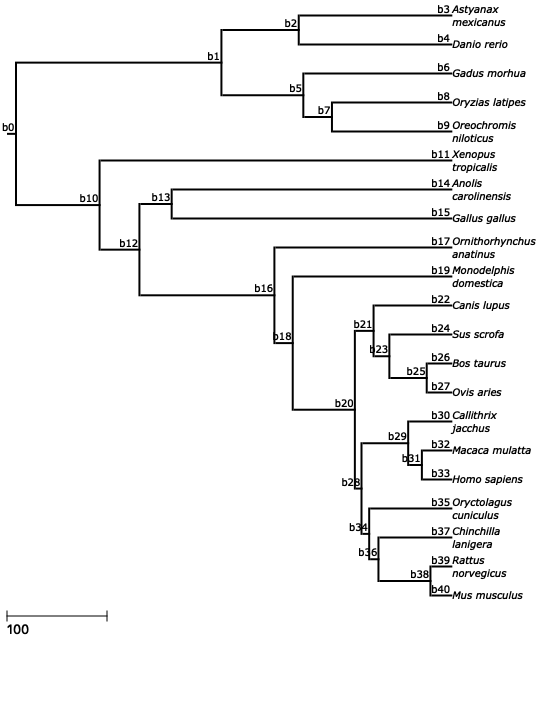

In [5]:
# prepare sptree
sptree = ete3.PhyloNode(sptree_file, format=3)
sptree.ladderize()
node_id = 0
for node in sptree.traverse(strategy='preorder'):
    node.name = node.name.replace("\'", "")
    node.id = 'b'+str(node_id)
    node_id += 1
    if node.is_root():
        node.name = sptree_root
b['branch_id'] = 0
for node in sptree.traverse(strategy='preorder'):
    b.loc[(b['spnode_coverage']==node.name),'branch_id'] = node.id
        
def my_layout(node):
    size_s = 6
    size_m = 10
    size_phylopic = 25
    nodeStyle = ete3.NodeStyle()
    nodeStyle["hz_line_width"] = nodeStyle["vt_line_width"] = 2
    nodeStyle["size"] = 0
    if node.is_root():
        node.dist=10
    if node.is_leaf():
        if len(node.name)>15:
            leaf_name = node.name.replace('_', '\n')
        else:
            leaf_name = node.name.replace('_', ' ')
        leafnameFace = ete3.TextFace(leaf_name, ftype="Verdana", fsize=size_m, fgcolor="black", fstyle="italic", tight_text=False)
        ete3.add_face_to_node(face=leafnameFace, node=node, column=1, aligned=True, position="aligned")
    # branch_id    
    text_branch = str(node.id)
    branchFace = ete3.TextFace(text_branch, fsize=size_m, fgcolor="black")
    branchFace.margin_bottom = branchFace.margin_right = branchFace.margin_top = branchFace.margin_left = 2
    ete3.add_face_to_node(face=branchFace, node=node, column=1, aligned=False, position="float")
    ete3.add_face_to_node(face=ete3.TextFace('', fsize=size_m), node=node, column=1, aligned=False, position="float")
    #  phylopic images
    if False:
    #if node.is_leaf():
        phylopic_file = [ file for file in os.listdir(phylopic_dir) if file.startswith(node.name) ][0]
        paths, attributes = svg2paths(phylopic_dir+phylopic_file)
        for i in range(len(paths)):
            if i==0:
                xmin, xmax, ymin, ymax = paths[i].bbox()
            else:
                my_xmin, my_xmax, my_ymin, my_ymax = paths[i].bbox()
                xmin = my_xmin if my_xmin < xmin else xmin
                xmax = my_xmax if my_xmax > xmax else xmax
                ymin = my_ymin if my_ymin < ymin else ymin
                ymax = my_ymax if my_ymax > ymax else ymax
        width=None
        height=None
        if (ymax-ymin)>(xmax-xmin):
            height=size_phylopic
        else:
            width=size_phylopic
        phylopicFace = ete3.SVGFace(phylopic_dir+phylopic_file, width=width, height=height)
        ete3.add_face_to_node(face=phylopicFace, node=node, column=2, aligned=True, position="aligned")
    node.set_style(nodeStyle)

treeStyle = ete3.TreeStyle()
treeStyle.layout_fn = my_layout
treeStyle.scale = 1
treeStyle.min_leaf_separation = 29
treeStyle.show_leaf_name = False
treeStyle.scale_length = 100
#treeStyle.optimal_scale_level = "mid"
treeStyle.complete_branch_lines_when_necessary  = False
treeStyle.allow_face_overlap = False
#sptree.render(file_name="annotated_sptree.pdf", tree_style=treeStyle, h=None, w=4.2, units="in", dpi=1200)
#sptree.render(file_name="annotated_sptree.svg", tree_style=treeStyle, h=None, w=4.2, units="in", dpi=1200)
sptree.render(file_name="annotated_sptree.pdf", tree_style=treeStyle, h=None, w=3.0, units="in")
sptree.render(file_name="annotated_sptree.svg", tree_style=treeStyle, h=None, w=3.0, units="in")
sptree.render("%%inline", tree_style=treeStyle)


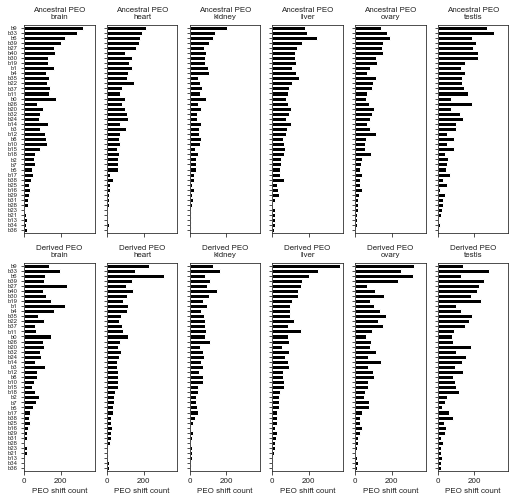

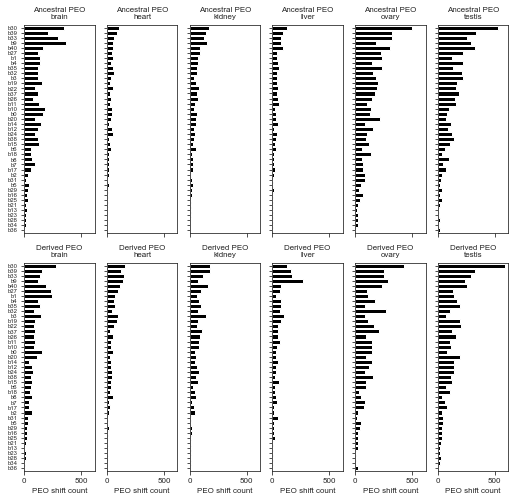

In [6]:
for pp in pcm_prefixes:
    fig,axes = matplotlib.pyplot.subplots(nrows=2, ncols=len(organs), figsize=(7.2, 7), sharex=True)

    is_shift = (b[pp+'is_shift']==1)
    is_peo_shift = (b['parent_'+pp+'max_organ']!=b[pp+'max_organ'])
    is_target = (is_shift)&(is_peo_shift)
    
    #is_specific = (b[pp+'delta_tau']>0.5)
    #is_target = (is_target)&(is_specific)

    tmp = b.loc[is_target,:]
    #tmp['o2o'] = tmp['parent_'+pp+'max_organ'] + '_' + tmp[pp+'max_organ']
    index_order = tmp['branch_id'].value_counts()
    for j,col in enumerate(['parent_'+pp+'max_organ',pp+'max_organ']):
        for k,organ in enumerate(organs):
            ax = axes[j,k]
            dat = tmp.loc[(tmp[col]==organ),'branch_id'].value_counts()
            dat = dat.loc[index_order.index]
            seaborn.barplot(x=dat, y=dat.index, color='black', ax=ax)
            if k!=0:
                 ax.set_yticklabels([''] * len(ax.get_yticklabels()), fontsize=font_size-2)
            else:
                 ax.set_yticklabels(ax.get_yticklabels(), fontsize=font_size-2)                
            if j==1:
                ax.set_title('Derived PEO\n'+organ, fontsize=font_size)
                ax.set_xlabel('PEO shift count', fontsize=font_size)
            else:
                ax.set_title('Ancestral PEO\n'+organ, fontsize=font_size)
                ax.set_xlabel('', fontsize=font_size)

    fig.tight_layout()
    file_base = 'branch_wise_peo_shift_'+pp
    for ext in ['png','pdf','svg']:
        fig.savefig(file_base+'.'+ext, format=ext)

S; Shift frequency = 0.00024804574942087113 shift/My; # shifts = 11,746; # branches = 542,978; Total branch MY = 47,354,167.63812388
D; Shift frequency = 0.0016886637493336888 shift/My; # shifts = 5,960; # branches = 65,868; Total branch MY = 3,529,417.8621123894
R; Shift frequency = 0.007029358246006006 shift/My; # shifts = 1,106; # branches = 2,963; Total branch MY = 157,340.11004893875


/Users/kef74yk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


Chi-square test among 3 branch categories: chisq=21,064.636194292412, P=0.0, dof=2


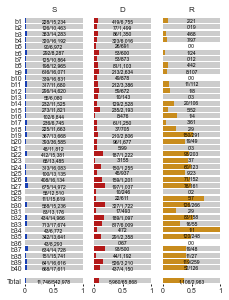

In [7]:
min_nshift = 0
num_category = b.branch_category.drop_duplicates().dropna().shape[0]

shift_col = 'l1ou_intersect_is_shift'

fig,axes = matplotlib.pyplot.subplots(nrows=1, ncols=num_category, figsize=(3.5, 4.9), sharex=False)
any_col = 'orthogroup'
tmp0 = b.loc[b['branch_id']!='b0',:]
tmp = pandas.DataFrame(tmp0.groupby(['branch_id',shift_col,'branch_category'])[any_col].count()).unstack().fillna(0)
tmp.columns = tmp.columns.get_level_values(level=1)
tmp = tmp.unstack()
tmp = tmp.iloc[numpy.argsort([ int(s[1:]) for s in tmp.index ]),:]
placeholders = pandas.DataFrame([[numpy.nan,]*tmp.shape[1]], columns=tmp.columns, index=['',])
totals = pandas.DataFrame([tmp.sum(axis=0).tolist()], columns=tmp.columns, index=['Total',])
tmp = pandas.concat([tmp, placeholders, totals], axis=0)
for i in range(len(branch_categories)):
    tmp_my = tmp0.loc[(tmp0['branch_category']==branch_categories[i]),'bl_dated']
    nbranch = (tmp0['branch_category']==branch_categories[i]).sum()
    nshift = ((tmp0[shift_col]==1)&(tmp0['branch_category']==branch_categories[i])).sum()
    total_my = tmp_my.sum()
    txt = '{}; Shift frequency = {} shift/My; # shifts = {:,}; # branches = {:,}; Total branch MY = {:,}'
    print(txt.format(branch_categories[i], nshift/total_my, nshift, nbranch, total_my))

    tmp2 = pandas.DataFrame(tmp.loc[:,tmp.columns.get_level_values(0)==branch_categories[i]])
    tmp2.columns = ['no_shift', 'shift']
    tmp3 = tmp2.copy()
    sum_values = tmp2.sum(axis=1)
    tmp2.loc[(tmp2['shift']<min_nshift).tolist(),:] = numpy.nan
    for c in tmp2.columns:
        tmp2.loc[:,c] = tmp2.loc[:,c] / sum_values
    tmp2 = tmp2.reset_index(drop=False)
    #tmp2 = tmp2.iloc[numpy.argsort([ int(s[1:]) for s in tmp2['branch_id'] ]),:]
    ax = kfplot.stacked_barplot(x=['shift', 'no_shift'], y='index', data=tmp2, ax=axes[i], 
                                colors=[category_colors[branch_categories[i]],(0.8,0.8,0.8)])
    ax.set_xlim(0, 1)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(branch_categories[i], fontsize=font_size)
    ax.tick_params(axis='both', which='major', direction='out', length=2, width=1, pad=1, top=False, left=False, right=False)
    xticks = [0, 0.5, 1]
    ax.set_xticks(xticks, minor=False)
    ax.set_xticklabels([ str(tick) for tick in xticks ], minor=False, ha='center')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=font_size-1)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=font_size-1)
    for j in range(tmp3.shape[0]):
        nshift = tmp3['shift'].iloc[j]
        nbranch = tmp3.iloc[j,:].sum()
        if (nshift==nshift)&(nbranch==nbranch):
            percent = numpy.round(nshift/nbranch*100, decimals=1)
            #txt = str(percent)+'% ('+str(int(nshift))+'/'+str(int(nbranch))+')'
            txt = "{:,}/{:,}".format(int(nshift), int(nbranch))
            ax.text(x=0.5, y=j, s=txt, color='black', ha='center', va='center', fontsize=5)
    if i%num_category!=0:
        ax.get_yaxis().set_visible(False)        
    for part in ['top','bottom','left','right']:
        ax.spines[part].set_visible(False)

file_base = 'proportion_shift'
for ext in ['png','pdf','svg']:
    fig.savefig(file_base+'.'+ext, format=ext)

# Chisq test
contingency_table = numpy.array([
    [tmp.loc['Total',('S',True)].astype(int), tmp.loc['Total',('S',False)].astype(int)],
    [tmp.loc['Total',('D',True)].astype(int), tmp.loc['Total',('D',False)].astype(int)],
    [tmp.loc['Total',('R',True)].astype(int), tmp.loc['Total',('R',False)].astype(int)],
])
out = scipy.stats.chi2_contingency(observed=contingency_table, correction=True, lambda_=None)
chi,p,dof,expected = out
print('Chi-square test among 3 branch categories: chisq={:,}, P={}, dof={}'.format(chi, p, dof))

The number of orthogroups analyzed for phylogeny: 15280
The number of trees with +G models: 10880
The number of trees with +R models: 3531
The number of trees with *H models: 0
The number of trees with no rate heterogeneity: 869
model_df
{0: 12, 1: 1107, 2: 1122, 3: 2371, 4: 1990, 5: 3304, 6: 3963, 7: 408, 8: 1003}
model_rate
{1: 869, 2: 201, 3: 1693, 4: 12135, 5: 312, 6: 57, 7: 3, 8: 3, 9: 3, 10: 4}
rooting_method
{'MAD': 11237, 'MID': 662, 'NTG': 3381}
dating_method
{'D': 1, 'R': 758, 'RD': 299, 'RDS': 9638, 'RS': 216, 'S': 2558, 'allS': 1810}


/Users/kef74yk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


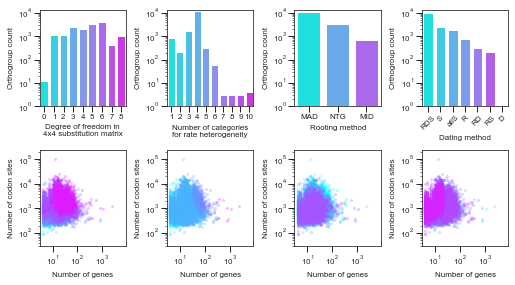

In [8]:
criterion = 'iqtree_best_BIC'
alpha = 0.2
cols = ['model_df','model_rate','rooting_method','dating_method']
cmaps = ['cool','cool','cool','cool']
hist_xlabels = ['Degree of freedom in\n4x4 substitution matrix','Number of categories\nfor rate heterogeneity','Rooting method', 'Dating method']

fig,axes = matplotlib.pyplot.subplots(nrows=2, ncols=len(cols), figsize=(7.2,4), sharex=False)

model_df = {'JC':0,'JC69':0,'F81':3,'K80':1,'K2P':1,'HKY':4,'HKY85':4,'TN':5,'TN93':5,'TNe':2,'K81':2,'K3P':2,
       'K3Pu':2,'K81u':5,'TPM2':2,'TPM2u':5,'TPM3':2,'TPM3u':5,'TIM':6,'TIMe':3,'TIM2':6,'TIM2e':3,'TIM3':6,
       'TIM3e':3,'TVM':7,'TVMe':4,'SYM':5,'GTR':8,}

t['model_df'] = t[criterion]
t['model_df'] = t['model_df'].str.replace('\+.*','')
for key in model_df.keys():
    t.loc[t['model_df']==key,'model_df'] = model_df[key]

t['model_rate'] = t[criterion]
t.loc[t['model_rate'].str.contains('\+[GR]'),'model_rate'] = t.loc[t['model_rate'].str.contains('\+[GR]'),'model_rate'].str.replace('.*\+[GR]','').str.replace('\+.*','')
t.loc[~t['model_rate'].str.contains('^[0-9]'),'model_rate'] = 1
t.loc[:,'model_rate'] = t['model_rate'].astype(int)

print('The number of orthogroups analyzed for phylogeny:', (~t[criterion].isnull()).sum())
#print('The number of orthogroups with nonzero parsimony-informative site:', (t['prop_parsimony_informative_cleaned']!=0).sum())
print('The number of trees with +G models:', t[criterion].str.contains('\+G').sum())
print('The number of trees with +R models:', t[criterion].str.contains('\+R').sum())
print('The number of trees with *H models:', t[criterion].str.contains('\*H').sum())
print('The number of trees with no rate heterogeneity:', (~t[criterion].str.replace('\+I','').str.replace('\+F','').str.contains('\+')).sum())

for j in range(len(cols)):
    col = cols[j]
    print(col)
    if col=='rooting_method':
        t[col] = t[col].str.replace('NOTUNG','NTG').str.replace('midpoint','MID')
    elif col=='dating_method':
        # some RDS trees were not annotated correctly.
        conditions = (t[col].isnull())&(~t['l1ou_fpkm_alpha_brain'].isnull())
        t.loc[conditions,col] = 'RDS'
    print(t.loc[:,[col,'orthogroup']].groupby(col).count().to_dict()['orthogroup'])
    df_unique = t[col].dropna().drop_duplicates()
    df_unique = sorted(df_unique.tolist())
    num_df = len(df_unique)
    cmap = matplotlib.cm.get_cmap(cmaps[j])
    df_rgba = cmap(numpy.arange(0,1.001, 1/num_df))
    for i in range(len(df_rgba)):
        df_rgba[i][3] = alpha

    ax = axes[0,j]
    val = t[col]
    val = pandas.DataFrame(val.value_counts())
    ax = seaborn.barplot(x=val.index, y=val[col], ax=ax, palette=df_rgba)
    ax.set_yscale('log', basey=10)
    ax.set_ylim(1,13000)
    ax.set_xlabel(hist_xlabels[j])
    ax.set_ylabel('Orthogroup count')
    if col=='dating_method':
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    ax = axes[1,j]
    for i in numpy.arange(num_df):
        tmp = t.loc[t[col]==df_unique[i],:]
        if tmp.shape[0]==1:
            tmp = tmp.append(pandas.Series(), ignore_index=True)
        ax = seaborn.regplot(x='cleaned_num_seq', y='cleaned_num_site', data=tmp, fit_reg=False, 
                             color=df_rgba[i], scatter_kws={'alpha':alpha,'rasterized':True,'s':5}, ax=ax)
    ax.set_xscale('log', basex=10)
    ax.set_yscale('log', basey=10)
    ax.set_xlabel('Number of genes')
    ax.set_ylabel('Number of codon sites')
    ax.set_xlim(3, 2**13*1.1)
    ax.set_ylim(10**1*3, 10**6/4)
    ax.set_xticks([10,100,1000])

for ax in axes.flat:
    ax.tick_params(axis='both', which='major', direction='out', length=6, width=1, pad=2, top=False, right=False, labelsize=font_size)
    ax.tick_params(axis='both', which='minor', top=False, right=False, labelsize=font_size)

fig.tight_layout()
outbase = 'tree_inference'
fig.savefig(outbase+".pdf", format='pdf', transparent=True)
fig.savefig(outbase+".svg", format='svg', transparent=True)

l1ou_fpkm_ (N = 15280, # of trees reaching the limit = 0)
l1ou_tpm_ (N = 15280, # of trees reaching the limit = 3)


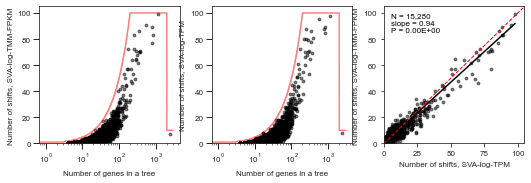

In [9]:
fig,axes = matplotlib.pyplot.subplots(nrows=1, ncols=3, figsize=(7.2,2.4), sharex=False)
axes = axes.flat

num_leaves = numpy.arange(0,3000, 1)
halves = numpy.floor(num_leaves/2).astype(int)
halves[halves>100] = 100
sqroots = numpy.floor(num_leaves**0.5).astype(int)
max_nshifts = halves
max_nshifts[max_nshifts<sqroots] = sqroots[max_nshifts<sqroots]
df_max_nshift = pandas.DataFrame({'num_leaf':num_leaves,'max_nshift':max_nshifts})
df_max_nshift.loc[(df_max_nshift['num_leaf']>=2000),'max_nshift'] = 10

color = 'black'
ymax = 105

for pp,ax in zip(pcm_prefixes,axes):
    tmp = t.loc[(~t[pp+'alpha_brain'].isnull()),:]
    tmp = pandas.merge(tmp, df_max_nshift, left_on='cleaned_num_seq', right_on='num_leaf')
    num_tree = tmp.shape[0]
    num_max_shift = (tmp[pp+'num_shift']==tmp['max_nshift']).sum()
    label = '(N = '+str(num_tree)+', # of trees reaching the limit = '+str(num_max_shift)+')'
    print(pp, label)
    ax = seaborn.regplot('cleaned_num_seq', pp+'num_shift', data=tmp, fit_reg=False, ax=ax, color=color, 
                         scatter_kws={'alpha':0.5,'rasterized':True,'s':8}, label=label)
    
    ax.plot('num_leaf', 'max_nshift', data=df_max_nshift, color='red', alpha=0.5, label='Upper limit in regime shift inference')
    ax.set_ylim(0,ymax)
    ax.set_xscale('log', basex=10)
    #ax.set_yscale('log', basex=2)
    ax.tick_params(axis='both', which='major', direction='out', length=6, width=1, pad=2, top=False, right=False, labelsize=font_size)
    ax.tick_params(axis='both', which='minor', top=False, right=False, labelsize=font_size)
    ax.set_xlabel('Number of genes in a tree')
    ax.set_ylabel('Number of shifts, SVA-log-TMM-FPKM' if pp=='l1ou_fpkm_' else 'Number of shifts, SVA-log-TPM')

ax = axes[2]
seaborn.regplot('l1ou_tpm_num_shift', 'l1ou_fpkm_num_shift', t, fit_reg=False, ax=ax, color=color,
                scatter_kws={'alpha':0.5,'rasterized':True,'s':8})
ols_annotations('l1ou_tpm_num_shift', 'l1ou_fpkm_num_shift', t, ax=ax)
ax.set_xlabel('Number of shifts, SVA-log-TPM')
ax.set_ylabel('Number of shifts, SVA-log-TMM-FPKM')
ax.plot([0,ymax],[0,ymax], color='red', lw=1, linestyle='--')
ax.set_xlim(0,ymax)
ax.set_ylim(0,ymax)

fig.tight_layout(pad=0)
outbase = 'ou_nshift'
fig.savefig(outbase+".pdf", format='pdf', transparent=True)
fig.savefig(outbase+".svg", format='svg', transparent=True)

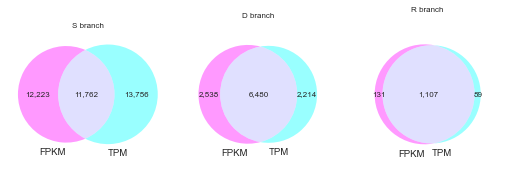

In [10]:
import matplotlib_venn

fig,axes = matplotlib.pyplot.subplots(nrows=1, ncols=3, figsize=(7.2,2.4), sharex=False)
axes = axes.flat

label_fpkm = 'FPKM'#'log TMM-SVA-FPKM'
label_tpm = 'TPM'#'log SVA-TPM'
colors = ['magenta','cyan']

tmp = b.copy()


shift_cols = ['l1ou_tpm_is_shift','l1ou_fpkm_is_shift']
window_search_col = shift_cols[0]
labels = ['TPM','FPKM']
window_sizes = [0,1,]
neighbors = ['parent','sister','child1','child2']

id_cols = ['orthogroup','numerical_label','parent','sister','child1','child2','branch_category']
tmp = b.loc[:,id_cols+shift_cols]
for sc in shift_cols:
    tmp.loc[:,sc] = tmp.loc[:,sc].astype(bool)
for neighbor in neighbors:
    tmp = attach_neighbor_stats(df=tmp, neighbor=neighbor, columns=[window_search_col,])


tmp.loc[:,'ogb_id'] = tmp['orthogroup'] + tmp['numerical_label'].astype(str)

def my_formatter(s):
    return "{:,}".format(s)

for event,ax,nt in zip(['S','D','R'],axes,[1,0.21,0.12]):
    tmp1 = tmp.loc[(tmp['branch_category']==event),:]
    set_fpkm = set(tmp1.loc[tmp1['l1ou_fpkm_is_shift']==1,'ogb_id'])
    set_tpm = set(tmp1.loc[tmp1['l1ou_tpm_is_shift']==1,'ogb_id'])

    v = matplotlib_venn.venn2(subsets=[set_fpkm,set_tpm], set_labels=[label_fpkm,label_tpm], ax=ax,
                             set_colors=colors, normalize_to=nt, subset_label_formatter=my_formatter)
    ax.set_title(event+' branch')

fig.tight_layout()
outbase = 'pcm_venn'
fig.savefig(outbase+".pdf", format='pdf', transparent=True)
fig.savefig(outbase+".svg", format='svg', transparent=True)

In [11]:
force = False

#fig,axes = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize=(2.4,2.4), sharex=False)
#ax = axes

tmp = b.loc[:,['orthogroup','hyphy_omega','mapdnds_omega']]
#tmp.loc[:,['hyphy_omega','mapdnds_omega']] = numpy.log(tmp.loc[:,['hyphy_omega','mapdnds_omega']])
tmp.loc[:,['hyphy_omega','mapdnds_omega']] = tmp.loc[:,['hyphy_omega','mapdnds_omega']].replace([numpy.inf,-numpy.inf],100)
tmp = tmp.dropna()
print('Number of branches with omega annotations:', tmp.shape[0])
orthogroups = tmp['orthogroup'].unique()
print('Number of orthogroups with omega annotations:', orthogroups.shape[0])

file_og_cor = 'orthogroup_correlation.tsv'
if (os.path.exists(file_og_cor))&(~force):
    print('Reading', file_og_cor)
    og_cor = pandas.read_csv(file_og_cor, sep='\t', header=0)
else:
    og_cor = pandas.DataFrame({'orthogroup':orthogroups,'pearson':numpy.nan,'spearman':numpy.nan})
    for i in numpy.arange(len(orthogroups)):
        tmp_og = tmp.loc[(tmp['orthogroup']==orthogroups[i]),:]
        og_cor.loc[i,'pearson'] = scipy.stats.pearsonr(x=tmp_og['hyphy_omega'], y=tmp_og['mapdnds_omega'])[0]
        og_cor.loc[i,'spearman'] = scipy.stats.spearmanr(a=tmp_og['hyphy_omega'], b=tmp_og['mapdnds_omega']).correlation
        if i%1000==0:
            print("{0:%Y-%m-%d %H:%M:%S}".format(datetime.datetime.today()), ', processing', i, 'th orthogroups')
    og_cor.to_csv(file_og_cor, sep='\t', index=False)

#kfplot.density_scatter(x='hyphy_omega', y='mapdnds_omega', df=tmp, ax=ax, cor=True, diag=False, reg_family=None, hue_log=True)
#seaborn.regplot('hyphy_omega','mapdnds_omega', data=tmp, fit_reg=False)


Number of branches with omega annotations: 607873
Number of orthogroups with omega annotations: 15280
Reading orthogroup_correlation.tsv


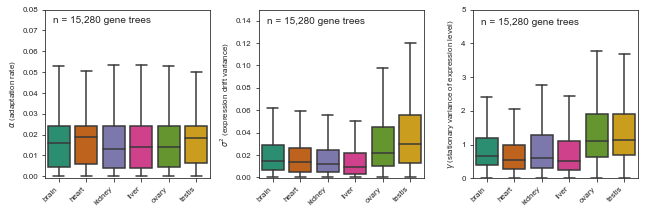

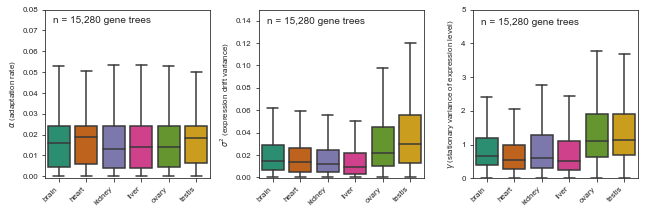

In [12]:
params = [pp+'alpha_',pp+'sigma2_',pp+'gamma_']
ymaxs = [0.08, 0.15, 5]
ylabels = ['$α$ (adaptation rate)', '$σ^2$ (expression drift variance)', '$γ$ (stationary variance of expression level)']

for pp in pcm_prefixes:
    fig,axes = matplotlib.pyplot.subplots(nrows=1, ncols=3, figsize=(9,3), sharex=False)
    for i in range(len(params)):
        ax = axes[i]
        df2 = t

        df3 = df2.loc[:,df2.columns.str.startswith(params[i])].melt()
        df3['variable'] = df3['variable'].str.replace(params[i],'')

        ymin = -0.001
        lw = 2
        alpha = 0.95
        colors = ['#1B9E77','#D95F02','#7570B3','#E7298A','#66A61E','#E6AB02']
        texty = (ymaxs[i] - ymin) * 0.925

        seaborn.boxplot(x='variable', y='value', data=df3, ax=ax, palette=colors, fliersize=0)

        ax.set_ylabel(ylabels[i])
        ax.set_xlabel('')
        ax.set_ylim(ymin, ymaxs[i])
        my_text='n = '+"{:,d}".format(df3.loc[df3.variable=='brain','variable'].shape[0])+' gene trees'
        ax.text(x=-0.2, y=texty, s=my_text, fontsize=10, ha='left', va='center')
        ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right')
    
    matplotlib.pyplot.tight_layout()
    outbase = 'sigma_boxplot_'+pp
    fig.savefig(outbase+".pdf", format='pdf')
    fig.savefig(outbase+".svg", format='svg')

l1ou_intersect_is_shift

 log_mapdnds_omega
Variance of ortholog median (unlog): 4.052727336760715
S Number of branch pairs = 11498
S Brunner-Munzel stat = 3.710725473681451
S P value = 0.0001035766799742932
S Effect size and 95% CI = 0.5141220684965032 0.5066625558204125 0.5215815811725939
S Unlog median value of S− = 0.09653370712268128
S Unlog median value of S+ = 0.10195232477385784
D Number of branch pairs = 5529
D Brunner-Munzel stat = 7.07301168594131
D P value = 8.040235144335384e-13
D Effect size and 95% CI = 0.5387574799620318 0.5280164239456809 0.5494985359783827
D Unlog median value of D− = 0.18236911096662003
D Unlog median value of D+ = 0.24378035689145436
R Number of branch pairs = 1075
R Brunner-Munzel stat = 25.299145968747506
R P value = 0.0
R Effect size and 95% CI = 0.7654909680908599 0.7449107814342645 0.7860711547474554
R Unlog median value of R− = 0.035579136470610964
R Unlog median value of R+ = 0.3942508012820513

 log_hyphy_omega
Variance of ortholog median (u

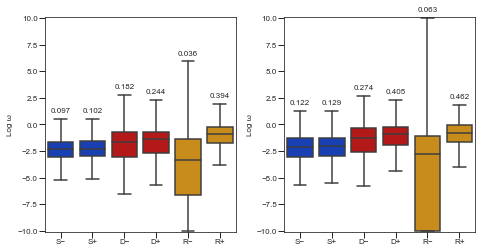

In [13]:
ys = ['log_mapdnds_omega','log_hyphy_omega']
#ylabs = ['Log $d_N/d_S$','Log $d_N/d_S$',]
ylabs = ['Log ω', 'Log ω']
#ys = ['log_mapdnds_omega', 'log_mapdnds_dn', 'log_mapdnds_ds']
#ylabs = ['Log $d_N/d_S$', 'Log $d_N$', 'Log $d_S$']
num_col=len(ys)
num_row=1
matplotlib.rcParams['font.size'] = 10

alpha_small=0.1
alpha_large=0.95
kernel='gau'
spnodes = b.spnode_coverage.unique()

is_parent_dup = b.so_event_parent=='D'
is_retrotransposition = (b.delta_intron_present<=max_delta_intron_present)
is_sister_retrotransposition = (b.sister_delta_intron_present<=max_delta_intron_present)
is_lower_delta_intron_present = (b.delta_intron_present<=b.sister_delta_intron_present)

if 'flat' in dir(axes):
    axes = axes.flat
else:
    axes = [axes,]

for sc in ['l1ou_intersect_is_shift']:
    print(sc)
    fig,axes = matplotlib.pyplot.subplots(nrows=num_row, ncols=num_col, figsize=(3.4*num_col,3.6*num_row), sharex=False)
    for y,ylab,ax in zip(ys,ylabs,axes):
        print('\n', y)

        tmp = b.loc[:,['orthogroup',y]]
        #tmp[y] = tmp[y].replace([-numpy.inf,numpy.inf], numpy.nan)
        log_var_value = tmp.groupby('orthogroup')[y].median().var()
        var_value = numpy.exp(log_var_value)
        print('Variance of ortholog median (unlog):', var_value)

        df2 = b.loc[(b[sc+'_pair']),:]
        df2 = df2.loc[~(df2[y].isnull()|df2['sister_'+y].isnull()),:]
        df2.loc[(df2['sister_branch_category']=='R'),'branch_category'] = 'R'
        df2.loc[:,y] = df2.loc[:,y].clip(-10, 10)
        df2['dup_shift'] = ''
        for bc in branch_categories:
            df2.loc[(df2.branch_category==bc)&(df2[sc]==0),'dup_shift'] = bc+'−'
            df2.loc[(df2.branch_category==bc)&(df2[sc]==1),'dup_shift'] = bc+'+'
        df2 = df2.dropna(subset=[y,], axis=0)

        orders = []
        colors = []
        for bc in branch_categories:
            orders = orders + [bc+'−', bc+'+']
            colors = colors + [category_colors[bc], category_colors[bc]]
        seaborn.boxplot(x='dup_shift', y=y, data=df2, ax=ax, showfliers=False, palette=colors, order=orders)

        #ax.set_xlim(-0.6, 3.6)
        #ax.set_xticks([0,1,2,3], minor=False)
        #ax.set_xticks([-0.6,-0.6,0.5,2.5], minor=True)
        #ax.set_xticklabels(['−','+','−','+',], minor=False, ha='center')
        #ax.set_xticklabels(['Exp. shift','\nPrec. event','\nSpeciation','\nDuplication',], minor=True, ha='center')
        ax.tick_params(axis='x', which='major', direction='out', length=6, width=1)
        ax.tick_params(axis='x', which='minor', direction='out', length=6, width=0)
        ax.set_xlabel('')

        pos=0
        lowest = numpy.inf
        highest = -numpy.inf
        for ev in branch_categories:
            for sh in [0,1]:
                dat = df2.loc[(df2.branch_category==ev)&(df2[sc]==sh),y].values
                Q1, median, Q3 = numpy.percentile(numpy.asarray(dat), [25, 50, 75])
                IQR = Q3 - Q1
                loval = Q1 - 1.5 * IQR
                hival = Q3 + 1.5 * IQR
                wiskhi = numpy.compress(dat <= hival, dat)
                wisklo = numpy.compress(dat >= loval, dat)
                actual_hival = numpy.max(wiskhi)
                actual_loval = numpy.min(wisklo)
                if actual_hival > highest:
                    highest = actual_hival
                if actual_loval < lowest:
                    lowest = actual_loval
                #label_text = "{:,d}".format(len(dat))
                label_text = "{}".format(numpy.round(numpy.exp(numpy.median(dat)), decimals=3))
                ax.text(x=pos, y=actual_hival+0.8, s=label_text, fontsize=font_size, ha='center', va='center')
                pos+=1
                del dat
        #ax.set_ylim(lowest-0.1, highest+4)
        ax.set_ylim(-10.1, 10.1)
        ax.set_ylabel(ylab)
        ax.tick_params(axis='both', which='major', direction='out', length=6, width=1, pad=1, top=False, right=False)

        for event in ['S','D','R']:
            xval = df2.loc[df2['dup_shift']==event+'−',y].values
            yval = df2.loc[df2['dup_shift']==event+'+',y].values
            #out = kfstat.brunner_munzel_test(xval, yval, alternative="two-sided")
            (W, dof, p, Pest, Cl, Ch) = kfstat.bm_test(xval, yval, ttype=1, alpha=0.05) #ttype, 1 = greater,-1 = lesser, 0 = two-sided
            print(event, 'Number of branch pairs =', len(xval))
            print(event, 'Brunner-Munzel stat =', W)
            print(event, 'P value =', p)
            print(event, 'Effect size and 95% CI =', Pest, Cl, Ch)
            print(event, 'Unlog median value of '+event+'− =', numpy.exp(numpy.median(xval)))
            print(event, 'Unlog median value of '+event+'+ =', numpy.exp(numpy.median(yval)))

    print(numpy.finfo(p))
    #del df2

    fig.tight_layout()
    outbase = 'dNdS_dN_dS_boxplot_'+sc
    fig.savefig(outbase+".pdf", format='pdf')
    fig.savefig(outbase+".svg", format='svg')

l1ou_intersect_is_shift
l1ou_fpkm_


/Users/kef74yk/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/kef74yk/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/kef74yk/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

l1ou_tpm_


/Users/kef74yk/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/kef74yk/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/kef74yk/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

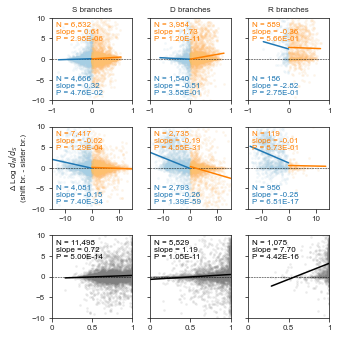

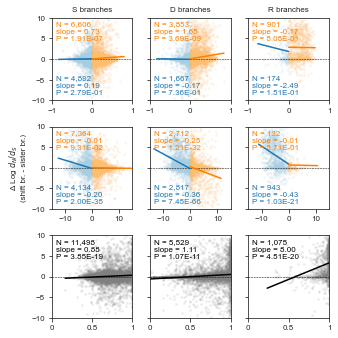

In [14]:
y = 'mapdnds_delta_omega'
ylabel = 'Δ Log $d_N/d_S$\n(shift br. - sister br.)'
ymin = -10
ymax = 10
alpha = 0.1
ps = 3
mk = 'o'
ols_method = 'ols' # ols or quantreg 
show_xlab = False
no_colors = [(0.5,0.5,0.5),(0,0,0)]
negative_colors = matplotlib.cm.get_cmap('Paired').colors[0:2]
positive_colors = matplotlib.cm.get_cmap('Paired').colors[6:8]
stats = ['N','slope','slope_p']

textys = [0.3,0.95]

events = ['S+','D+','R+']
titles = ['S branches', 'D branches', 'R branches']

for sc in ['l1ou_intersect_is_shift',]:
    print(sc)
    for pp in pcm_prefixes:
        print(pp)
        fig,axes = matplotlib.pyplot.subplots(nrows=3, ncols=3, figsize=(4.8, 4.8))
        df2 = b.loc[b[sc+'_pair'],:]
        df2.loc[(df2['sister_branch_category']=='R'),'branch_category'] = 'R'
        df2.loc[:,'dup_shift'] = ''
        for bc in branch_categories:
            df2.loc[(df2.branch_category==bc)&(df2[sc]==0),'dup_shift'] = bc+'−'
            df2.loc[(df2.branch_category==bc)&(df2[sc]==1),'dup_shift'] = bc+'+'

        for i,event in enumerate(events):
            dat = df2.loc[(df2[sc]==1)&(df2.dup_shift==event),:]
            dat.loc[:,'mapdnds_delta_omega'] = dat['log_mapdnds_omega']-dat['sister_log_mapdnds_omega']

            j = 0
            ax = axes[j,i]
            x = pp+'delta_tau'
            ax.axhline(y=0, linestyle='--', color='black', lw=0.5)
            for colors,conditions,texty in zip([negative_colors,positive_colors],[(dat[x]<0),(dat[x]>0)],textys):
                seaborn.regplot(x, y, data=dat.loc[conditions,:], fit_reg=False, truncate=True, ax=ax, color=colors[0], marker=mk,
                                scatter_kws={'alpha':alpha,'rasterized':True,'s':ps}, line_kws={'color':colors[1]})
                ols_annotations(x, y, dat.loc[conditions,:], ax, colors[1], font_size, textxy=[0.05,texty], method=ols_method, 
                                stats=stats)
            ax.set_xlim(-1,1)
            ax.set_ylim(ymin,ymax)
            if show_xlab:
                ax.set_xlabel('Shift in organ\nexp. specificity (τ)' if i%3==1 else '')
            else:
                ax.set_xlabel('')
            ax.xaxis.set_ticks([-1,0,1])
            ax.set_ylabel(ylabel if (i==0)&(j==1) else '')
            if i!=0:
                ax.yaxis.set_ticklabels(['']*len(ax.get_yticklabels()))
            ax.set_title(titles[i], fontsize=font_size)

            j = 1
            ax = axes[j,i]
            x = pp+'delta_maxmu'
            ax.axhline(y=0, linestyle='--', color='black', lw=0.5)
            for colors,conditions,texty in zip([negative_colors,positive_colors],[(dat[x]<0),(dat[x]>0)],textys):
                seaborn.regplot(x, y, data=dat.loc[conditions,:], fit_reg=False, truncate=True, ax=ax, color=colors[0], marker=mk,
                                scatter_kws={'alpha':alpha,'rasterized':True,'s':ps}, line_kws={'color':colors[1]})
                ols_annotations(x, y, dat.loc[conditions,:], ax, colors[1], font_size, textxy=[0.05,texty], method=ols_method, 
                                stats=stats)
            ax.set_xlim(-15,15)
            ax.set_ylim(ymin,ymax)
            expression_unit = 'FPKM' if pp=='l1ou_fpkm_' else 'TPM'
            if show_xlab:
                ax.set_xlabel('Shift in max expression\nlevel (Δ Log '+expression_unit+')' if i%3==1 else '')
            else:
                ax.set_xlabel('')
            ax.xaxis.set_ticks([-10,0,10])
            ax.set_ylabel(ylabel if (i==0)&(j==1) else '')
            if i!=0:
                ax.yaxis.set_ticklabels(['']*len(ax.get_yticklabels()))

            j = 2
            ax = axes[j,i]
            x = pp+'mu_complementarity'
            ax.axhline(y=0, linestyle='--', color='black', lw=0.5)
            seaborn.regplot(x, y, data=dat, fit_reg=False, truncate=False, ax=ax, color=no_colors[0], marker=mk,
                            scatter_kws={'alpha':alpha,'rasterized':True,'s':ps}, line_kws={'color':no_colors[1]})
            ols_annotations(x, y, dat, ax, no_colors[1], font_size, textxy=[0.05,0.95], method=ols_method, stats=stats)
            ax.set_xlim(0,1)
            ax.set_ylim(ymin,ymax)
            if show_xlab:
                ax.set_xlabel('Expression complementarity\nbetween sister lineages' if i%3==1 else '')
            else:
                ax.set_xlabel('')
            ax.xaxis.set_ticks([0,0.5,1])
            ax.xaxis.set_ticklabels(['0','0.5','1'])
            ax.set_ylabel(ylabel if (i==0)&(j==1) else '')
            if i!=0:
                ax.yaxis.set_ticklabels(['']*len(ax.get_yticklabels()))

        fig.tight_layout()
        #fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        outbase = 'dNdS_vs_exp_properties_'+pp+sc
        fig.savefig(outbase+".pdf", format='pdf')
        fig.savefig(outbase+".svg", format='svg')

l1ou_fpkm_
l1ou_fpkm_ Brunner-Munzel stat = 56.767067346862625
l1ou_fpkm_ P value = 0.0
l1ou_fpkm_ Effect size and 95% CI = 0.6081602634333626 0.60442581428692 0.6118947125798052
l1ou_fpkm_ Pest - Cl = 0.003734449146442609
l1ou_fpkm_ Ch - Pest = 0.003734449146442609

l1ou_tpm_
l1ou_tpm_ Brunner-Munzel stat = 94.8233631302835
l1ou_tpm_ P value = 0.0
l1ou_tpm_ Effect size and 95% CI = 0.6736075821146624 0.6700191196059939 0.6771960446233309
l1ou_tpm_ Pest - Cl = 0.0035884625086685107
l1ou_tpm_ Ch - Pest = 0.0035884625086685107



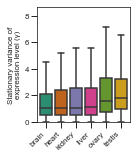

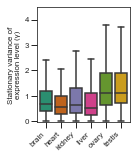

In [15]:
ylims=[8.7,4.5]
for pp,ymax in zip(pcm_prefixes,ylims):
    print(pp)
    fig,axes = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize=(2,2.3), sharex=False)
    ax = axes

    x=pp+'gamma_'
    df3 = t.loc[:,t.columns.str.startswith(x)].melt()
    df3['variable'] = df3['variable'].str.replace(x,'')
    xmin=-0.6
    xmax=5.6
    ymin = -0.05
    lw=2
    alpha=0.95
    colors=['#1B9E77','#D95F02','#7570B3','#E7298A','#66A61E','#E6AB02']
    order = ['brain','heart','kidney','liver','ovary','testis']
    seaborn.boxplot(x='variable', y='value', data=df3, ax=ax, palette=colors, showfliers=False, order=order)
    ax.set_ylabel('Stationary variance of\nexpression level (γ)')
    ax.set_xlabel('')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xticklabels(order, rotation=45, ha='right')
    xloc = xmin+((xmax-xmin)/100*4)
    yloc = ymax-((ymax-ymin)/100*2)
    my_text='N = '+"{:,d}".format(df3.loc[(df3.variable=='brain')&(~df3.value.isnull()),'variable'].shape[0])+' gene trees'
    fout = scipy.stats.friedmanchisquare(t[x+'brain'].values, t[x+'heart'].values, t[x+'kidney'].values, 
                                 t[x+'liver'].values, t[x+'ovary'].values, t[x+'testis'].values, )
    chistat = fout[0]
    chitext = 'χ^2 = '+"{:.2e}".format(Decimal(str(chistat)))
    pval = fout[1]
    sign = '='
    if pval==0:
        pval = numpy.finfo(type(pval)).eps
        sign = '<'
    pval = "{:.2e}".format(Decimal(str(pval)))
    ptext = 'P '+sign+' '+pval
    my_text = my_text+'\n'+chitext
    my_text = my_text+'\n'+ptext
    #ax.text(x=xloc, y=yloc, s=my_text, fontsize=font_size, ha='left', va='top')
    ax.tick_params(axis='both', which='major', direction='out', length=6, width=1, pad=2, top=False, right=False)

    matplotlib.pyplot.tight_layout()
    outbase = x+'organ_'+pp
    fig.savefig(outbase+".pdf", format='pdf', transparent=True)
    fig.savefig(outbase+".svg", format='svg', transparent=True)
    
    control = list()
    control = control + t[pp+'gamma_brain'].dropna().tolist()
    control = control + t[pp+'gamma_heart'].dropna().tolist()
    control = control + t[pp+'gamma_kidney'].dropna().tolist()
    control = control + t[pp+'gamma_liver'].dropna().tolist()

    target = list()
    target = target + t[pp+'gamma_ovary'].dropna().tolist()
    target = target + t[pp+'gamma_testis'].dropna().tolist()

    (W, dof, p, Pest, Cl, Ch) = kfstat.bm_test(control, target)
    print(pp, 'Brunner-Munzel stat =', W)
    print(pp, 'P value =', p)
    print(pp, 'Effect size and 95% CI =', Pest, Cl, Ch)
    print(pp, 'Pest - Cl =', Pest - Cl)
    print(pp, 'Ch - Pest =', Ch - Pest)
    print()

In [16]:
#reg_family = statsmodels.genmod.families.family.NegativeBinomial()
reg_family = statsmodels.genmod.families.family.Poisson()
#reg_family = statsmodels.genmod.families.family.Gaussian()

num_row=2
num_col=2
alpha_small=0.1
alpha_large=0.9
kernel='gau'
# full figure size = 9.7 length x 7.2 width in inches
#fig,axes = matplotlib.pyplot.subplots(nrows=num_row, ncols=num_col, figsize=(2.2*num_col,2.2*num_row), sharex=False)

xs = ['delta_tau','delta_maxmu','mu_complementarity']
xmins = {'delta_tau':-0.45,'delta_maxmu':-11,'mu_complementarity':0}
xmaxs = {'delta_tau':0.75,'delta_maxmu':11,'mu_complementarity':1}
#axis= {'delta_tau':axes.flat[1],'delta_maxmu':axes.flat[2],'mu_complementarity':axes.flat[3]}
xlabels = {'delta_tau':'Shift in expression specificity',
           'delta_maxmu':'Shift in max expression level',
           'mu_complementarity':'Expression complementarity\nbetween sister lineages'}
zero_vlines = {'delta_tau':False,'delta_maxmu':False,'mu_complementarity':False}

conditions = True
conditions = conditions&(b['spnode_coverage']!='root')

box_step = 0.15

for sc in shift_columns:
    #ax = axes[0,0]
    col1 = 'branch_category'
    col2 = 'spnode_coverage'
    df_branch = b.loc[(b[col1]!='No'),:].pivot_table(index=col2, columns=col1, values='orthogroup', aggfunc='count').fillna(0)
    df_shift = b.loc[(b[col1]!='No')&(b[sc]==1),:].pivot_table(index=col2, columns=col1, values='orthogroup', aggfunc='count').fillna(0)
    df_bl = b.loc[(b[col1]!='No'),:].pivot_table(index=col2, columns=col1, values='bl_dated', aggfunc='sum').fillna(0)
    df_prop = df_shift / df_bl
    df_prop = df_prop.drop(sptree_root)
    df_prop = pandas.DataFrame(df_prop.stack())

    conf95_lowers = dict()
    conf95_uppers = dict()
    slopes = dict()
    for bc in branch_categories:
        dat = pandas.DataFrame(df_shift[bc])
        dat['bl'] = df_bl[bc]
        #formula = bc+'~1'
        formula = bc+'~bl-1'
        #mod = statsmodels.formula.api.glm(formula=formula, data=dat, family=reg_family, freq_weights=dat['bl'])
        mod = statsmodels.formula.api.glm(formula=formula, data=dat, family=reg_family)
        res = mod.fit()
        conf95_lowers[bc] = res.conf_int().loc['bl',0]
        conf95_uppers[bc] = res.conf_int().loc['bl',1]
        slopes[bc] = res.params['bl']
        print(sc, bc, 'num_shift =', dat[bc].sum(), 'total_bl =', dat['bl'].sum(), 'shift/MY =', dat[bc].sum()/dat['bl'].sum())
    print(sc,'conf95_lower =', conf95_lowers)
    print(sc,'conf95_upper =', conf95_uppers)
    print(sc,'slope =', slopes)

l1ou_fpkm_is_shift S num_shift = 23985.0 total_bl = 47435809.20286555 shift/MY = 0.0005056306702268946
l1ou_fpkm_is_shift D num_shift = 9018.0 total_bl = 4739356.061232859 shift/MY = 0.001902790143531467
l1ou_fpkm_is_shift R num_shift = 1238.0 total_bl = 163542.86835132877 shift/MY = 0.007569880683152035
l1ou_fpkm_is_shift conf95_lower = {'S': 2.183119445576086e-06, 'D': 6.106426293159801e-06, 'R': 0.00028209263803218287}
l1ou_fpkm_is_shift conf95_upper = {'S': 2.1947428232433673e-06, 'D': 6.184910517345311e-06, 'R': 0.0002916342426424933}
l1ou_fpkm_is_shift slope = {'S': 2.1889311344097268e-06, 'D': 6.145668405252556e-06, 'R': 0.0002868634403373381}
l1ou_tpm_is_shift S num_shift = 25518.0 total_bl = 47435809.20286555 shift/MY = 0.0005379480276360182
l1ou_tpm_is_shift D num_shift = 8694.0 total_bl = 4739356.061232859 shift/MY = 0.0018344264257997974
l1ou_tpm_is_shift R num_shift = 1196.0 total_bl = 163542.86835132877 shift/MY = 0.007313067283562063
l1ou_tpm_is_shift conf95_lower = {'S'

l1ou_intersect_is_shift l1ou_fpkm_
l1ou_fpkm_delta_tau; S-D: D = 0.12, P = 7.1e-49
l1ou_fpkm_delta_tau; S-R: D = 0.26, P = 6.4e-62
l1ou_fpkm_delta_tau; D-R: D = 0.16, P = 2.7e-21
l1ou_fpkm_delta_maxmu; S-D: D = 0.17, P = 3.9e-101
l1ou_fpkm_delta_maxmu; S-R: D = 0.64, P = 0.0
l1ou_fpkm_delta_maxmu; D-R: D = 0.48, P = 8.6e-186
l1ou_fpkm_mu_complementarity; S-D: D = 0.17, P = 1.8e-107
l1ou_fpkm_mu_complementarity; S-R: D = 0.59, P = 8.4e-305
l1ou_fpkm_mu_complementarity; D-R: D = 0.42, P = 1.5e-146
l1ou_intersect_is_shift l1ou_tpm_
l1ou_tpm_delta_tau; S-D: D = 0.1, P = 1.4e-39
l1ou_tpm_delta_tau; S-R: D = 0.31, P = 7.3e-84
l1ou_tpm_delta_tau; D-R: D = 0.21, P = 2.1e-37
l1ou_tpm_delta_maxmu; S-D: D = 0.19, P = 3.2e-131
l1ou_tpm_delta_maxmu; S-R: D = 0.61, P = 4.9e-323
l1ou_tpm_delta_maxmu; D-R: D = 0.48, P = 1.5e-191
l1ou_tpm_mu_complementarity; S-D: D = 0.17, P = 9e-104
l1ou_tpm_mu_complementarity; S-R: D = 0.59, P = 1.2e-305
l1ou_tpm_mu_complementarity; D-R: D = 0.43, P = 1.1e-151


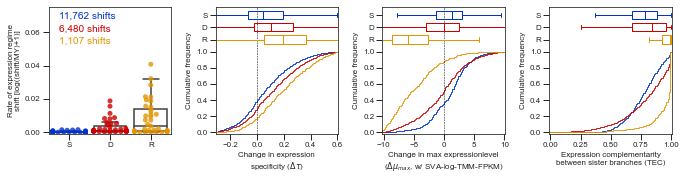

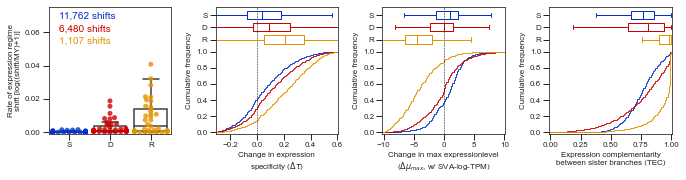

In [17]:
num_row=1
num_col=4
alpha_small=0.1
alpha_large=0.9
kernel='gau'
box_step = 0.15
# full figure size = 9.7 length x 7.2 width in inches

for sc in ['l1ou_intersect_is_shift',]:
    for pp in pcm_prefixes:
        print(sc, pp)
        fig,axes = matplotlib.pyplot.subplots(nrows=num_row, ncols=num_col, figsize=(7.2+2.4,2.6*num_row), sharex=False)

        if pp=='l1ou_fpkm_':
            expression_unit = 'SVA-log-TMM-FPKM'
        elif pp=='l1ou_tpm_':
            expression_unit = 'SVA-log-TPM'
        
        xs = [pp+'delta_tau',pp+'delta_maxmu',pp+'mu_complementarity']
        xmins = {pp+'delta_tau':-0.3,pp+'delta_maxmu':-10,pp+'mu_complementarity':0}
        xmaxs = {pp+'delta_tau':0.6,pp+'delta_maxmu':10,pp+'mu_complementarity':1}
        axis= {pp+'delta_tau':axes.flat[1],pp+'delta_maxmu':axes.flat[2],pp+'mu_complementarity':axes.flat[3]}
        xlabels = {pp+'delta_tau':'Change in expression\nspecificity ($Δτ$)',
                   pp+'delta_maxmu':'Change in max expressionlevel\n($Δμ_{max}$, w/ '+expression_unit+')',
                   pp+'mu_complementarity':'Expression complementarity\nbetween sister branches (TEC)'}
        zero_vlines = {pp+'delta_tau':False,pp+'delta_maxmu':False,pp+'mu_complementarity':False}

        conditions = True
        conditions = conditions&(b['spnode_coverage']!='root')
        
        for x in xs:
            box_position = 1 + (box_step*len(branch_categories))
            yticks = [0.0,0.2,0.4,0.6,0.8,1.0]
            bins=numpy.arange(xmins[x]-((xmaxs[x]-xmins[x])/50), xmaxs[x]+((xmaxs[x]-xmins[x])/50), (xmaxs[x]-xmins[x])/100)
            ax = axis[x]
            if 'delta_' in x:
                 ax.axvline(x=0, lw=0.5, linestyle='--', color='black')
            df_tmp=b.loc[(b[sc]==1)&(conditions),:]
            ax = kfplot.hist_boxplot(x=x, category='branch_category', df=df_tmp, colors=category_colors, xlim=[xmins[x],xmaxs[x]], bins=bins, alpha=0.9, box_step=0.15, ax=ax)
            ax.set_xlabel(xlabels[x])
            for bc1,bc2 in itertools.combinations(branch_categories, 2):
                v1 = df_tmp.loc[(df_tmp['branch_category']==bc1),x].values
                v2 = df_tmp.loc[(df_tmp['branch_category']==bc2),x].values
                statistic,pvalue = scipy.stats.ks_2samp(v1, v2, alternative='two-sided', mode='auto')
                print('{}; {}-{}: D = {:.2}, P = {:.2}'.format(x, bc1, bc2, statistic, pvalue))
    
        ax = axes.flat[0]
        col1 = 'branch_category'
        col2 = 'spnode_coverage'
        df_branch = b.loc[(b[col1]!='No'),:].pivot_table(index=col2, columns=col1, values='orthogroup', aggfunc='count').fillna(0)
        df_shift = b.loc[(b[col1]!='No')&(b[sc]==1),:].pivot_table(index=col2, columns=col1, values='orthogroup', aggfunc='count').fillna(0)
        df_bl = b.loc[(b[col1]!='No'),:].pivot_table(index=col2, columns=col1, values='bl_dated', aggfunc='sum').fillna(0)
        df_prop = df_shift / df_bl
        df_prop = df_prop.drop(sptree_root)
        df_prop = pandas.DataFrame(df_prop.stack())
        df_prop = numpy.log(df_prop+1)
        colors = [ category_colors[bc] for bc in branch_categories ]
        seaborn.boxplot(x=df_prop.index.get_level_values(1), y=0, data=df_prop, order=branch_categories, palette=colors, ax=ax, boxprops={'facecolor':'None'}, showfliers=False)
        seaborn.swarmplot(x=df_prop.index.get_level_values(1), y=0, data=df_prop, order=branch_categories, palette=colors, ax=ax, alpha=0.8)
        ax.set_ylim(-0.001,0.075)
        ax.set_ylabel('Rate of expression regime\nshift [log((shift/MY)+1)]')
        ax.set_xlabel('')
        ymin,ymax = ax.get_ylim()
        label_y = ymax - ((ymax-ymin)*0.035)
        for ev in branch_categories:
            num_shift = b.loc[(b.branch_category==ev)&(b[sc]==1)&(conditions),:].shape[0]
            num_text = "{:,d}".format(num_shift)+' shifts'
            color = category_colors[ev]
            ax.text(-0.25, label_y, num_text, va='top', ha='left', color=color)
            label_y = label_y - ((ymax-ymin)*0.1)

        for ax in axes.flat:
            ax.tick_params(axis='both', which='major', direction='out', length=6, width=1, pad=2, top=False, right=False)

        fig.tight_layout()
        outbase = 'shiftStats2_'+pp+sc
        fig.savefig(outbase+".pdf", format='pdf', transparent=True)
        fig.savefig(outbase+".svg", format='svg', transparent=True)

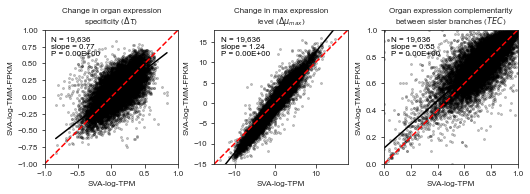

In [18]:
fig,axes = matplotlib.pyplot.subplots(nrows=1, ncols=3, figsize=(7.2,2.5), sharex=False)
axes = axes.flat

alpha = 0.2
size = 4

conditions = True
conditions = conditions&(b['spnode_coverage']!='root')
conditions = conditions&(b['l1ou_intersect_is_shift']==1)
tmp = b.loc[conditions,:]

xs = ['delta_tau','delta_maxmu','mu_complementarity']
labels = ['Change in organ expression\nspecificity ($Δτ$)',
          'Change in max expression\nlevel ($Δμ_{max}$)',
          'Organ expression complementarity\nbetween sister branches ($TEC$)'
         ]
xyranges = [[-1,1],[-15,18],[0,1]]
for i,x in enumerate(xs):
    ax = axes[i]
    seaborn.regplot('l1ou_tpm_'+x, 'l1ou_fpkm_'+x, data=tmp, ax=ax, color='black', fit_reg=False,
                    scatter_kws={'alpha':alpha,'s':size,'rasterized':True})
    #pearson_r = numpy.round(scipy.stats.pearsonr(x=tmp['l1ou_tpm_'+x], y=tmp['l1ou_fpkm_'+x])[0], decimals=2)
    #cor_text = "Pearson's r = {}".format(pearson_r)
    #ax.set_title(labels[i]+'\n'+cor_text)
    ols_annotations('l1ou_tpm_'+x, 'l1ou_fpkm_'+x, data=tmp, ax=ax)
    ax.set_title(labels[i])
    ax.set_xlabel('SVA-log-TPM')
    ax.set_ylabel('SVA-log-TMM-FPKM')
    ax.set_xlim(xyranges[i])
    ax.set_ylim(xyranges[i])
    ax.plot(xyranges[i], xyranges[i], linestyle='--', color='red')

fig.tight_layout(pad=0)
outbase = 'shiftStats_correlation'
fig.savefig(outbase+".pdf", format='pdf', transparent=True)
fig.savefig(outbase+".svg", format='svg', transparent=True)

excluded spnodes in chromosome analysis: ['10', '11', '13', 'Xenopus_tropicalis', 'Astyanax_mexicanus', 'Danio_rerio', 'Gadus_morhua', '14', '19', 'Oryzias_latipes', 'Oreochromis_niloticus', 'Anolis_carolinensis', 'Gallus_gallus', 'Ornithorhynchus_anatinus', 'Chinchilla_lanigera']


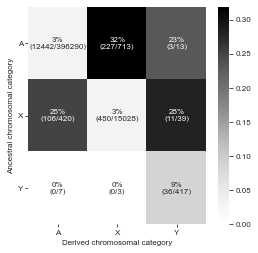

In [19]:
fig,axes = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize=(4,4), sharex=False)

shift_col = 'l1ou_intersect_is_shift'
var1 = 'parent_chromosome'
var2 = 'chromosome'
var_ph = 'orthogroup'

excluded_spp = 'Astyanax_mexicanus|Danio_rerio|Gadus_morhua|Oryzias_latipes|Oreochromis_niloticus|Xenopus_tropicalis|Gallus_gallus|Anolis_carolinensis|Ornithorhynchus_anatinus|Chinchilla_lanigera'
excluded_spp = [ sp.replace('_','_') for sp in excluded_spp.split('|') ]

coordinates = {
    'A':[0, -1],
    'X':[-0.8660254037844386467637, 0.5],
    'Y':[0.8660254037844386467637, 0.5],
}

excluded_spnodes = list()
for n in sptree.traverse():
    contain_excluded_spp = all([ node_sp in excluded_spp for node_sp in n.get_leaf_names() ])
    if contain_excluded_spp:
        excluded_spnodes.append(n.name)
print('excluded spnodes in chromosome analysis:', excluded_spnodes)
is_excluded_node = b['spnode_coverage'].isin(excluded_spnodes)
b2 = b.loc[~is_excluded_node,:]

is_chr_shift = (b2['parent_chromosome']!=b2['chromosome'])
is_exp_shift = b2[shift_col].fillna(0).astype(bool)
is_all = True


# show pivot table
pivot_all = pandas.DataFrame(b2.groupby([var1,var2])[var_ph].count()).reset_index().pivot(var1, var2).fillna(0)
pivot_chr_shift = pandas.DataFrame(b2.loc[is_chr_shift,:].groupby([var1,var2])[var_ph].count()).reset_index().pivot(var1, var2).fillna(0)
pivot_exp_shift = pandas.DataFrame(b2.loc[is_exp_shift,:].groupby([var1,var2])[var_ph].count()).reset_index().pivot(var1, var2).fillna(0)
pivot_exp_all_ratio = pivot_exp_shift/pivot_all
pivot_exp_all_ratio.columns = pivot_exp_all_ratio.columns.get_level_values(1)
#IPython.display.display(pivot_exp_all_ratio)

pivot_out = pandas.DataFrame(numpy.zeros(pivot_exp_all_ratio.shape))
for i in numpy.arange(pivot_out.shape[0]):
    for j in numpy.arange(pivot_out.shape[1]):
        percent = str(int(numpy.round(pivot_exp_all_ratio.values[i,j]*100, decimals=0)))
        numerator = str(int(pivot_exp_shift.values[i,j]))
        denominator = str(int(pivot_all.values[i,j]))
        pivot_out.loc[i,j] = percent+'%\n('+numerator+'/'+denominator+')'
pivot_out.index = pivot_all.index
pivot_out.columns = pivot_all.columns

rows = pivot_all.index
cols = pivot_all.columns.get_level_values(1)
#ax.axis('tight')
#ax.axis('off')
#the_table = ax.table(cellText=pivot_out.values, colLabels=cols, rowLabels=rows, loc='center')

ax = axes
seaborn.heatmap(pivot_exp_all_ratio, annot=pivot_out.values, fmt='', cmap='Greys', ax=ax, annot_kws={'fontsize':font_size})
ax.set_xlabel('Derived chromosomal category')
ax.set_ylabel('Ancestral chromosomal category')
ax.tick_params(pad=2, length=3, rotation=0, labelsize=font_size)

del b2

outbase = 'chromosome_heatmap'
fig.savefig(outbase+".pdf", format='pdf', transparent=True)
fig.savefig(outbase+".svg", format='svg', transparent=True)

In [20]:
# tissue network
min_taus = [0,0.5]
min_max_second_mu_ratios = [0,] # test 0 and 1
min_bss = [0,99]
min_delta_tau = -numpy.inf
nboot = 10000
nsubsample=numpy.inf#174#sum_R
shift_col = 'l1ou_intersect_is_shift'
pcm_prefixes = ['l1ou_fpkm_', 'l1ou_tpm_']
edge_width_weight=0.4
hide_nonsig=True
ancestral_max_unif_tau = None # 0.3
derived_max_unif_tau = None #0.3
bbox_length = 150
margin_size = 15
fdr_threshold = 0.05
calc_fdr = False

coordinates = {
    'brain':[0, -1],
    'heart':[0.8660254037844386467637, -0.5],
    'kidney':[0.8660254037844386467637, 0.5],
    'liver':[0,1],
    'ovary':[-0.8660254037844386467637, 0.5],
    'testis':[-0.8660254037844386467637, -0.5],
}

for pp,min_tau,min_max_second_mu_ratio,min_bs in itertools.product(pcm_prefixes[::-1], min_taus, min_max_second_mu_ratios, min_bss):
    corrected = dict()
    observed = dict()
    expected = dict()
    bs = dict()
    Ns = dict()
    fdrs = dict()
    fdr_flag = True
    var1 = 'parent_'+pp+'max_organ'
    var2 = pp+'max_organ'
    specificity_term = pp+'muRatio'+str(min_max_second_mu_ratio)+'_minTau'+str(min_tau)+'_minBS'+str(min_bs)
    print('\n', specificity_term)
    for event in branch_categories+['All',]:
        print('event =', event)
        conditions = True
        conditions = conditions&(b[shift_col]==1)
        if event is not 'All':
            conditions = conditions&(b.branch_category==event)
        conditions = conditions&(b.spnode_coverage!=sptree_root)
        conditions = (conditions)&(b['parent_'+pp+'tau']>=min_tau)
        conditions = (conditions)&(b[pp+'tau']>=min_tau)
        conditions = (conditions)&(b[pp+'delta_tau']>=min_delta_tau)
        conditions = (conditions)&(b[pp+'max_second_mu_ratio']>=min_max_second_mu_ratio)
        conditions = (conditions)&(b['parent_'+pp+'max_second_mu_ratio']>=min_max_second_mu_ratio)
        if min_bs!=0:
            conditions = (conditions)&(b['parent_support_iqtree']>=min_bs)
        #conditions = conditions&(b.parent_reconcil_support>=0.9)
        #conditions = conditions&(b.max_mu>=0.1)
        #conditions = conditions&(b.parent_max_mu>=0.1)
        #conditions = conditions&(b.max_mu/b.second_max_mu>=1.5)
        #conditions = conditions&(b.parent_max_mu/b.parent_second_max_mu>=1.5)
        df2 = b.loc[conditions,:]
        print('n before filterings =', df2.shape[0])
        out = shift_freq_bootstrap(df1=df2, var1=var1, var2=var2, down_reg=False, 
                                   exclude_self=True, nboot=nboot, nsubsample=nsubsample)
        corrected[event],observed[event],expected[event],bs[event],Ns[event] = out
        print('sample standard deviation =', numpy.sqrt(((corrected[event] - expected[event])**2).sum(axis=0).sum(axis=0) / ((corrected[event].shape[0]*corrected[event].shape[1])-1-corrected[event].shape[1])))
        IPython.display.display(observed[event])

        observed[event].to_csv('shift_count_observed_'+specificity_term+'_'+event+'.tsv', sep='\t', index=True)
        expected[event].to_csv('shift_count_expected_'+specificity_term+'_'+event+'.tsv', sep='\t', index=True)
        corrected[event].to_csv('shift_count_corrected_'+specificity_term+'_'+event+'.tsv', sep='\t', index=True)

        observed[event].stack().to_csv('stack_shift_count_observed_'+specificity_term+'_'+event+'.tsv', sep='\t', index=True)
        expected[event].stack().to_csv('stack_shift_count_expected_'+specificity_term+'_'+event+'.tsv', sep='\t', index=True)
        corrected[event].stack().to_csv('stack_shift_count_corrected_'+specificity_term+'_'+event+'.tsv', sep='\t', index=True)

        test_method = 'random'
        out = draw_network(corrected[event], observed[event], expected[event], bs[event], self_arrow=False, self_vertex_size=False, 
                           show_vertex_stat=False, edge_width=1, hide_nonsig=hide_nonsig,
                          coordinates=coordinates, test=test_method)
        g,layout,visual_style = out
        outbase = wd+'shift_network_'+specificity_term+'_'+test_method+'_'+event
        igraph.plot(g, target=outbase+'.svg', layout=layout, bbox=(bbox_length, bbox_length), background=None, margin=margin_size, **visual_style)
        texts = []
        texts.append(event)
        texts.append('N = '+"{:,d}".format(Ns[event]))
        add_igraph_legends(svg_file=outbase+'.svg', height=bbox_length, width=bbox_length, texts=texts)
        command = inkscape+' --export-pdf='+wd+outbase+'.pdf'+' '+wd+outbase+'.svg'
        os.system(command)
        #IPython.display.SVG(outbase+'.svg')
        
        if calc_fdr:
            vertex_dict = {'vertex':organs, 'color':organ_colors}
            quantile = get_quantile(observed[event], bs[event])
            try:
                fdrs[event] = get_quantile_fdr(quantile, fdr_threshold=fdr_threshold)
            except AssertionError:
                print('FDR cannot be calculated. Skipped.')
                fdr_flag = False
            except ValueError:
                print('FDR cannot be calculated. Skipped.')
                fdr_flag = False
            else:
                out = draw_network2(observed[event], quantile, fdrs[event], no_fp=True,
                                   self_arrow=False, self_vertex_size=False, show_vertex_stat=False, no_obs=False,
                                   edge_width=2, edge_width_weight=5, hide_nonsig=False, vertex_dict=vertex_dict, coordinates=coordinates,
                                   show_edge_color=True, scaled_edge_curve=True, relative_freq_edge_width=False, sig_color='greenpink'
                                   )
                g,layout,visual_style = out
                outbase = wd+'fdr_shift_network_'+specificity_term+'_'+event
                igraph.plot(g, target=outbase+'.svg', layout=layout, bbox=(bbox_length, bbox_length), background=None, margin=margin_size, **visual_style)
                texts = []
                texts.append(event)
                texts.append('N = '+"{:,d}".format(Ns[event]))
                add_igraph_legends(svg_file=outbase+'.svg', height=bbox_length, width=bbox_length, texts=texts)
                command = inkscape+' --export-pdf='+wd+outbase+'.pdf'+' '+wd+outbase+'.svg'
                os.system(command)
    
    if fdr_flag&calc_fdr:
        # Unidirectional table
        tmp2 = pandas.DataFrame()
        for event in branch_categories:
            df_pvalue = observed[event].copy()
            df_pvalue.loc[:,:] = (observed[event].values > bs[event]).sum(axis=0) / bs[event].shape[0]
            for ind,col in itertools.product(df_pvalue.index, df_pvalue.columns):
                if ind==col:
                    df_pvalue.at[ind,col] = numpy.nan
            obs = pandas.DataFrame(observed[event].stack())
            exp = pandas.DataFrame(expected[event].stack())
            pval = pandas.DataFrame(df_pvalue.stack()) * 100
            fdr = pandas.DataFrame(fdrs[event].stack()).iloc[:,0]
            tmp = pandas.concat([obs, exp, pval, fdr], axis=1)
            tmp.columns = ['Observed','Expected','Permutation-based percentile rank','FDR<0.05']
            tmp = tmp.reset_index()
            tmp.columns = tmp.columns.str.replace('parent_'+pp+'max_organ', 'Ancestral PEO')
            tmp.columns = tmp.columns.str.replace(pp+'max_organ', 'Derived PEO')    
            tmp = tmp.dropna()
            tmp.loc[:,'Branch'] = event
            col_order = ['Branch','Ancestral PEO','Derived PEO','Observed','Expected','Permutation-based percentile rank','FDR<0.05']
            tmp = tmp.loc[:,col_order]
            is_sig = tmp.loc[:,'FDR<0.05'].values
            tmp.loc[is_sig,'FDR<0.05'] = 'yes'
            tmp.loc[~is_sig,'FDR<0.05'] = 'no'
            tmp2 = pandas.concat([tmp2,tmp], ignore_index=True, axis=0)
        outfile = 'shift_summary_'+specificity_term+'.tsv'
        tmp2.to_csv(outfile, sep='\t', index=True)

del corrected,expected,observed,bs,Ns

# Chi-square test
pp = 'l1ou_fpkm_'
mu_ratio = 0
min_tau = 0
min_bs = 0
contingency_list = list()
for bc in branch_categories:
    tsv_file = 'shift_count_observed_{}muRatio{}_minTau{}_minBS{}_{}.tsv'
    tsv_file = tsv_file.format(pp, mu_ratio, min_tau, min_bs, bc)
    tmp = pandas.read_table(tsv_file, index_col=0)
    contingency_list.append(tmp.astype(int).values.flatten())
contingency_table = numpy.array(contingency_list)
is_observed = (contingency_table.sum(axis=0)>0)
contingency_table = contingency_table[:,is_observed]
out = scipy.stats.chi2_contingency(observed=contingency_table, correction=True, lambda_=None)
chi,p,dof,expected = out
print('Chi-square test among 3 branch categories: chisq={:,}, P={}, dof={}'.format(chi, p, dof))


 l1ou_tpm_muRatio0_minTau0_minBS0
event = S
n before filterings = 11746
N after filtering = 6617
sample standard deviation = 267.3594426707461


l1ou_tpm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_tpm_max_organ,,,,,,
brain,0.0,193.0,214.0,139.0,492.0,513.0
heart,91.0,0.0,68.0,39.0,107.0,121.0
kidney,103.0,70.0,0.0,118.0,186.0,182.0
liver,60.0,34.0,110.0,0.0,101.0,102.0
ovary,517.0,166.0,232.0,182.0,0.0,706.0
testis,489.0,177.0,249.0,200.0,656.0,0.0


event = D
n before filterings = 5960
N after filtering = 3495
sample standard deviation = 135.37208846222526


l1ou_tpm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_tpm_max_organ,,,,,,
brain,0.0,54.0,61.0,54.0,149.0,198.0
heart,63.0,0.0,23.0,25.0,60.0,89.0
kidney,56.0,52.0,0.0,82.0,130.0,119.0
liver,52.0,32.0,75.0,0.0,117.0,96.0
ovary,215.0,84.0,129.0,121.0,0.0,427.0
testis,264.0,103.0,137.0,124.0,304.0,0.0


event = R
n before filterings = 1106
N after filtering = 713
sample standard deviation = 34.049246167874735


l1ou_tpm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_tpm_max_organ,,,,,,
brain,0.0,16.0,7.0,5.0,28.0,48.0
heart,15.0,0.0,10.0,6.0,21.0,46.0
kidney,14.0,24.0,0.0,18.0,13.0,51.0
liver,2.0,1.0,5.0,0.0,4.0,20.0
ovary,33.0,17.0,30.0,20.0,0.0,146.0
testis,26.0,15.0,15.0,8.0,49.0,0.0


event = All
n before filterings = 19096
N after filtering = 11007
sample standard deviation = 436.0393924880891


l1ou_tpm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_tpm_max_organ,,,,,,
brain,0.0,267.0,282.0,198.0,680.0,765.0
heart,170.0,0.0,104.0,73.0,192.0,257.0
kidney,173.0,153.0,0.0,219.0,348.0,357.0
liver,120.0,67.0,194.0,0.0,227.0,221.0
ovary,777.0,271.0,398.0,327.0,0.0,1291.0
testis,789.0,305.0,411.0,338.0,1033.0,0.0



 l1ou_tpm_muRatio0_minTau0_minBS99
event = S
n before filterings = 5717
N after filtering = 3122
sample standard deviation = 125.71332017109673


l1ou_tpm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_tpm_max_organ,,,,,,
brain,0.0,100.0,87.0,73.0,233.0,234.0
heart,38.0,0.0,23.0,21.0,46.0,51.0
kidney,55.0,37.0,0.0,51.0,76.0,75.0
liver,27.0,15.0,70.0,0.0,47.0,49.0
ovary,246.0,77.0,101.0,79.0,0.0,298.0
testis,273.0,99.0,136.0,95.0,310.0,0.0


event = D
n before filterings = 3061
N after filtering = 1799
sample standard deviation = 70.89962646450866


l1ou_tpm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_tpm_max_organ,,,,,,
brain,0.0,32.0,34.0,35.0,86.0,101.0
heart,35.0,0.0,11.0,9.0,28.0,42.0
kidney,28.0,27.0,0.0,37.0,52.0,76.0
liver,32.0,20.0,35.0,0.0,58.0,48.0
ovary,119.0,45.0,63.0,62.0,0.0,250.0
testis,134.0,50.0,63.0,47.0,140.0,0.0


event = R
n before filterings = 628
N after filtering = 395
sample standard deviation = 17.742557163867247


l1ou_tpm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_tpm_max_organ,,,,,,
brain,0.0,12.0,3.0,3.0,17.0,18.0
heart,7.0,0.0,4.0,4.0,12.0,22.0
kidney,6.0,17.0,0.0,10.0,7.0,28.0
liver,1.0,0.0,4.0,0.0,3.0,12.0
ovary,16.0,8.0,19.0,10.0,0.0,82.0
testis,17.0,10.0,11.0,5.0,27.0,0.0


event = All
n before filterings = 9529
N after filtering = 5386
sample standard deviation = 213.2151605464185


l1ou_tpm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_tpm_max_organ,,,,,,
brain,0.0,145.0,124.0,111.0,339.0,355.0
heart,80.0,0.0,38.0,34.0,87.0,116.0
kidney,89.0,82.0,0.0,99.0,143.0,181.0
liver,63.0,35.0,111.0,0.0,111.0,111.0
ovary,386.0,133.0,186.0,151.0,0.0,636.0
testis,428.0,162.0,215.0,149.0,486.0,0.0



 l1ou_tpm_muRatio0_minTau0.5_minBS0
event = S
n before filterings = 5407
N after filtering = 2440
sample standard deviation = 104.02846536341698


l1ou_tpm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_tpm_max_organ,,,,,,
brain,0.0,105.0,117.0,88.0,228.0,247.0
heart,30.0,0.0,19.0,14.0,36.0,47.0
kidney,40.0,20.0,0.0,51.0,66.0,59.0
liver,30.0,13.0,57.0,0.0,44.0,55.0
ovary,74.0,25.0,31.0,37.0,0.0,162.0
testis,167.0,75.0,125.0,96.0,282.0,0.0


event = D
n before filterings = 2508
N after filtering = 1142
sample standard deviation = 45.90762558051996


l1ou_tpm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_tpm_max_organ,,,,,,
brain,0.0,22.0,23.0,23.0,43.0,84.0
heart,22.0,0.0,3.0,10.0,19.0,23.0
kidney,10.0,5.0,0.0,18.0,24.0,27.0
liver,20.0,12.0,36.0,0.0,48.0,45.0
ovary,35.0,9.0,27.0,24.0,0.0,109.0
testis,117.0,41.0,68.0,61.0,134.0,0.0


event = R
n before filterings = 290
N after filtering = 147
sample standard deviation = 6.262471039887569


l1ou_tpm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_tpm_max_organ,,,,,,
brain,0.0,2.0,1.0,3.0,4.0,17.0
heart,5.0,0.0,2.0,2.0,5.0,20.0
kidney,1.0,1.0,0.0,0.0,0.0,4.0
liver,1.0,0.0,4.0,0.0,2.0,5.0
ovary,4.0,3.0,1.0,2.0,0.0,21.0
testis,9.0,6.0,3.0,3.0,16.0,0.0


event = All
n before filterings = 8284
N after filtering = 3762
sample standard deviation = 154.65131013359417


l1ou_tpm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_tpm_max_organ,,,,,,
brain,0.0,130.0,141.0,114.0,279.0,349.0
heart,57.0,0.0,24.0,26.0,60.0,90.0
kidney,51.0,26.0,0.0,69.0,91.0,90.0
liver,51.0,25.0,98.0,0.0,95.0,106.0
ovary,113.0,37.0,60.0,63.0,0.0,295.0
testis,297.0,126.0,198.0,163.0,438.0,0.0



 l1ou_tpm_muRatio0_minTau0.5_minBS99
event = S
n before filterings = 2797
N after filtering = 1217
sample standard deviation = 51.15382501689103


l1ou_tpm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_tpm_max_organ,,,,,,
brain,0.0,60.0,52.0,44.0,111.0,119.0
heart,12.0,0.0,8.0,8.0,16.0,14.0
kidney,24.0,11.0,0.0,27.0,26.0,27.0
liver,11.0,6.0,37.0,0.0,23.0,26.0
ovary,36.0,12.0,12.0,21.0,0.0,79.0
testis,107.0,43.0,68.0,45.0,132.0,0.0


event = D
n before filterings = 1282
N after filtering = 567
sample standard deviation = 21.755287970514175


l1ou_tpm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_tpm_max_organ,,,,,,
brain,0.0,11.0,11.0,16.0,24.0,43.0
heart,15.0,0.0,3.0,6.0,9.0,11.0
kidney,6.0,4.0,0.0,5.0,9.0,17.0
liver,12.0,9.0,16.0,0.0,24.0,24.0
ovary,19.0,4.0,18.0,11.0,0.0,50.0
testis,55.0,18.0,33.0,20.0,64.0,0.0


event = R
n before filterings = 174
N after filtering = 80
sample standard deviation = 3.1484517998403234


l1ou_tpm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_tpm_max_organ,,,,,,
brain,0.0,1.0,0.0,2.0,1.0,5.0
heart,1.0,0.0,0.0,1.0,4.0,9.0
kidney,1.0,1.0,0.0,0.0,0.0,1.0
liver,1.0,0.0,3.0,0.0,2.0,3.0
ovary,2.0,2.0,1.0,0.0,0.0,16.0
testis,6.0,4.0,1.0,2.0,10.0,0.0


event = All
n before filterings = 4294
N after filtering = 1880
sample standard deviation = 76.13306751530278


l1ou_tpm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_tpm_max_organ,,,,,,
brain,0.0,72.0,63.0,62.0,137.0,167.0
heart,28.0,0.0,11.0,15.0,29.0,34.0
kidney,31.0,16.0,0.0,32.0,36.0,45.0
liver,24.0,15.0,57.0,0.0,50.0,54.0
ovary,57.0,18.0,32.0,32.0,0.0,147.0
testis,171.0,65.0,104.0,68.0,208.0,0.0



 l1ou_fpkm_muRatio0_minTau0_minBS0
event = S
n before filterings = 11746
N after filtering = 6886
sample standard deviation = 245.19105957603753


l1ou_fpkm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_fpkm_max_organ,,,,,,
brain,0.0,377.0,238.0,295.0,308.0,459.0
heart,230.0,0.0,137.0,225.0,185.0,268.0
kidney,133.0,93.0,0.0,186.0,129.0,162.0
liver,190.0,188.0,184.0,0.0,180.0,236.0
ovary,169.0,143.0,106.0,175.0,0.0,305.0
testis,361.0,246.0,239.0,313.0,426.0,0.0


event = D
n before filterings = 5960
N after filtering = 3586
sample standard deviation = 125.45799930283056


l1ou_fpkm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_fpkm_max_organ,,,,,,
brain,0.0,76.0,71.0,102.0,101.0,154.0
heart,125.0,0.0,72.0,94.0,94.0,165.0
kidney,73.0,62.0,0.0,78.0,89.0,106.0
liver,128.0,133.0,128.0,0.0,155.0,194.0
ovary,104.0,65.0,72.0,126.0,0.0,191.0
testis,196.0,117.0,135.0,173.0,207.0,0.0


event = R
n before filterings = 1106
N after filtering = 746
sample standard deviation = 31.595094351223743


l1ou_fpkm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_fpkm_max_organ,,,,,,
brain,0.0,14.0,8.0,11.0,12.0,40.0
heart,40.0,0.0,25.0,35.0,37.0,87.0
kidney,9.0,5.0,0.0,9.0,2.0,26.0
liver,36.0,29.0,42.0,0.0,27.0,70.0
ovary,16.0,14.0,11.0,18.0,0.0,35.0
testis,17.0,21.0,10.0,10.0,30.0,0.0


event = All
n before filterings = 19096
N after filtering = 11395
sample standard deviation = 399.2952002397656


l1ou_fpkm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_fpkm_max_organ,,,,,,
brain,0.0,470.0,320.0,411.0,431.0,656.0
heart,398.0,0.0,235.0,361.0,319.0,523.0
kidney,216.0,167.0,0.0,276.0,229.0,297.0
liver,357.0,359.0,361.0,0.0,370.0,503.0
ovary,295.0,228.0,192.0,326.0,0.0,535.0
testis,588.0,397.0,390.0,504.0,681.0,0.0



 l1ou_fpkm_muRatio0_minTau0_minBS99
event = S
n before filterings = 5717
N after filtering = 3307
sample standard deviation = 118.45128065945984


l1ou_fpkm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_fpkm_max_organ,,,,,,
brain,0.0,195.0,112.0,141.0,152.0,225.0
heart,98.0,0.0,62.0,85.0,77.0,90.0
kidney,65.0,51.0,0.0,102.0,61.0,87.0
liver,96.0,75.0,85.0,0.0,70.0,96.0
ovary,80.0,76.0,53.0,90.0,0.0,147.0
testis,209.0,134.0,128.0,162.0,203.0,0.0


event = D
n before filterings = 3061
N after filtering = 1826
sample standard deviation = 63.53810496821362


l1ou_fpkm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_fpkm_max_organ,,,,,,
brain,0.0,44.0,36.0,55.0,56.0,86.0
heart,70.0,0.0,36.0,44.0,53.0,87.0
kidney,40.0,32.0,0.0,37.0,44.0,65.0
liver,72.0,57.0,72.0,0.0,80.0,100.0
ovary,52.0,28.0,37.0,56.0,0.0,91.0
testis,101.0,58.0,67.0,74.0,96.0,0.0


event = R
n before filterings = 628
N after filtering = 408
sample standard deviation = 15.80211741497752


l1ou_fpkm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_fpkm_max_organ,,,,,,
brain,0.0,7.0,2.0,4.0,10.0,19.0
heart,16.0,0.0,12.0,23.0,17.0,39.0
kidney,5.0,4.0,0.0,6.0,1.0,13.0
liver,23.0,16.0,22.0,0.0,14.0,37.0
ovary,8.0,8.0,9.0,10.0,0.0,21.0
testis,14.0,16.0,7.0,7.0,18.0,0.0


event = All
n before filterings = 9529
N after filtering = 5618
sample standard deviation = 196.28866925653753


l1ou_fpkm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_fpkm_max_organ,,,,,,
brain,0.0,247.0,151.0,200.0,223.0,332.0
heart,185.0,0.0,110.0,153.0,148.0,218.0
kidney,111.0,91.0,0.0,147.0,110.0,166.0
liver,192.0,153.0,183.0,0.0,170.0,236.0
ovary,141.0,115.0,100.0,158.0,0.0,262.0
testis,331.0,210.0,205.0,245.0,325.0,0.0



 l1ou_fpkm_muRatio0_minTau0.5_minBS0
event = S
n before filterings = 4959
N after filtering = 2299
sample standard deviation = 92.23749573568381


l1ou_fpkm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_fpkm_max_organ,,,,,,
brain,0.0,187.0,113.0,126.0,151.0,208.0
heart,48.0,0.0,32.0,54.0,39.0,60.0
kidney,28.0,26.0,0.0,68.0,48.0,47.0
liver,45.0,46.0,82.0,0.0,51.0,79.0
ovary,34.0,19.0,17.0,34.0,0.0,55.0
testis,104.0,87.0,107.0,114.0,190.0,0.0


event = D
n before filterings = 2262
N after filtering = 1058
sample standard deviation = 38.8931588183576


l1ou_fpkm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_fpkm_max_organ,,,,,,
brain,0.0,34.0,17.0,34.0,38.0,61.0
heart,33.0,0.0,18.0,22.0,21.0,36.0
kidney,17.0,14.0,0.0,25.0,22.0,24.0
liver,36.0,34.0,40.0,0.0,57.0,68.0
ovary,15.0,10.0,16.0,19.0,0.0,35.0
testis,67.0,33.0,57.0,62.0,93.0,0.0


event = R
n before filterings = 264
N after filtering = 149
sample standard deviation = 6.845836834841906


l1ou_fpkm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_fpkm_max_organ,,,,,,
brain,0.0,4.0,1.0,0.0,1.0,9.0
heart,10.0,0.0,4.0,9.0,9.0,24.0
kidney,1.0,0.0,0.0,1.0,0.0,2.0
liver,5.0,3.0,6.0,0.0,1.0,23.0
ovary,1.0,5.0,2.0,2.0,0.0,0.0
testis,6.0,5.0,1.0,2.0,12.0,0.0


event = All
n before filterings = 7568
N after filtering = 3544
sample standard deviation = 135.0823187369566


l1ou_fpkm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_fpkm_max_organ,,,,,,
brain,0.0,225.0,132.0,160.0,192.0,279.0
heart,92.0,0.0,54.0,87.0,69.0,120.0
kidney,46.0,41.0,0.0,94.0,72.0,73.0
liver,86.0,83.0,129.0,0.0,110.0,172.0
ovary,51.0,34.0,35.0,55.0,0.0,90.0
testis,181.0,130.0,167.0,184.0,301.0,0.0



 l1ou_fpkm_muRatio0_minTau0.5_minBS99
event = S
n before filterings = 2568
N after filtering = 1168
sample standard deviation = 47.04147442583773


l1ou_fpkm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_fpkm_max_organ,,,,,,
brain,0.0,99.0,53.0,65.0,71.0,112.0
heart,22.0,0.0,13.0,26.0,17.0,20.0
kidney,10.0,18.0,0.0,36.0,22.0,22.0
liver,24.0,22.0,42.0,0.0,22.0,33.0
ovary,13.0,12.0,10.0,17.0,0.0,33.0
testis,66.0,54.0,61.0,61.0,92.0,0.0


event = D
n before filterings = 1179
N after filtering = 530
sample standard deviation = 19.094916912802102


l1ou_fpkm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_fpkm_max_organ,,,,,,
brain,0.0,20.0,5.0,17.0,18.0,33.0
heart,19.0,0.0,9.0,9.0,10.0,22.0
kidney,10.0,7.0,0.0,9.0,7.0,13.0
liver,23.0,15.0,21.0,0.0,33.0,35.0
ovary,9.0,5.0,13.0,6.0,0.0,13.0
testis,32.0,19.0,28.0,27.0,43.0,0.0


event = R
n before filterings = 149
N after filtering = 75
sample standard deviation = 3.2516885764346233


l1ou_fpkm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_fpkm_max_organ,,,,,,
brain,0.0,1.0,0.0,0.0,1.0,4.0
heart,2.0,0.0,2.0,6.0,4.0,13.0
kidney,1.0,0.0,0.0,0.0,0.0,1.0
liver,3.0,2.0,3.0,0.0,1.0,11.0
ovary,1.0,2.0,2.0,0.0,0.0,0.0
testis,4.0,3.0,0.0,2.0,6.0,0.0


event = All
n before filterings = 3939
N after filtering = 1791
sample standard deviation = 67.98354220222437


l1ou_fpkm_max_organ,brain,heart,kidney,liver,ovary,testis
parent_l1ou_fpkm_max_organ,,,,,,
brain,0.0,120.0,58.0,82.0,90.0,150.0
heart,44.0,0.0,24.0,42.0,31.0,55.0
kidney,21.0,25.0,0.0,45.0,31.0,36.0
liver,50.0,39.0,67.0,0.0,56.0,81.0
ovary,23.0,19.0,25.0,23.0,0.0,46.0
testis,104.0,77.0,91.0,92.0,144.0,0.0


Chi-square test among 3 branch categories: chisq=530.740393856863, P=1.5244714357425737e-77, dof=58


In [21]:
pp = 'l1ou_fpkm_'
mu_ratio = 0
min_tau = 0
min_bs = 0

# Unidirectional
tmp_list = list()
for bc in branch_categories:
    for stat in ['observed','expected']:
        tsv_file = 'shift_count_{}_{}muRatio{}_minTau{}_minBS{}_{}.tsv'
        tsv_file = tsv_file.format(stat, pp, mu_ratio, min_tau, min_bs, bc)
        tmp = pandas.read_table(tsv_file, index_col=0)
        tmp.index.name = None
        tmp = pandas.DataFrame(tmp.stack())
        tmp.columns = [bc+'_'+stat,]
        tmp_list.append(tmp)
tmp2 = pandas.concat(tmp_list, axis=1)
for col in tmp2.columns[tmp2.columns.str.endswith('_observed')]:
    tmp2.loc[:,col] = tmp2.loc[:,col].astype(int)
tmp2 = tmp2.reset_index()
tmp2.columns = tmp2.columns.str.replace('level_0', 'ancestral_PEO')
tmp2.columns = tmp2.columns.str.replace('level_1', 'derived_PEO')
for bc in branch_categories:
    tmp2.loc[:,bc+'_pvalue'] = numpy.nan
    tmp2.loc[:,bc+'_chi2'] = numpy.nan
    total_obs = tmp2.loc[:,bc+'_observed'].sum()
    total_exp = tmp2.loc[:,bc+'_expected'].sum()
    assert total_obs==total_exp, 'Total counts should match.'

outfile = 'shift_chisq_test_unidirectional.tsv'
tmp2.to_csv(outfile, sep='\t', index=True)

# Bidirectional
organ_combinations = itertools.combinations(organs, 2)
df_bi = pandas.DataFrame(organ_combinations)
df_bi.columns = ['PEO1','PEO2']
cols = [ bc+'_'+stat for bc,stat in itertools.product(branch_categories, ['observed','expected']) ]
for col in cols:
    df_bi.loc[:,col] = 0
for i in df_bi.index:
    o1 = df_bi.loc[i,'PEO1']
    o2 = df_bi.loc[i,'PEO2']
    is_target1 = ((tmp2.loc[:,'ancestral_PEO']==o1)&(tmp2.loc[:,'derived_PEO']==o2))
    is_target2 = ((tmp2.loc[:,'ancestral_PEO']==o2)&(tmp2.loc[:,'derived_PEO']==o1))
    is_target = is_target1 | is_target2
    tmp = tmp2.loc[is_target,cols].sum(axis=0)
    df_bi.loc[i,cols] = tmp.values

for bc in branch_categories:
    total_obs = df_bi.loc[:,bc+'_observed'].sum()
    total_exp = df_bi.loc[:,bc+'_expected'].sum()
    for i in df_bi.index:
        obs = df_bi.loc[i,bc+'_observed']
        exp = df_bi.loc[i,bc+'_expected']

outfile = 'shift_chisq_test_bidirectional.tsv'
df_bi.to_csv(outfile, sep='\t', index=True)
df_bi.head()

,PEO1,PEO2,S_observed,S_expected,D_observed,D_expected,R_observed,R_expected
0,brain,heart,607.0,505.507195,201.0,192.884207,54.0,52.791154
1,brain,kidney,371.0,398.683574,144.0,167.185266,17.0,22.351151
2,brain,liver,485.0,535.961005,230.0,252.900053,47.0,49.070692
3,brain,ovary,477.0,530.775255,205.0,227.337199,28.0,31.958141
4,brain,testis,820.0,720.330343,350.0,312.114196,57.0,50.941958


In [22]:
for pp,min_tau,min_max_second_mu_ratio,min_bs in itertools.product(pcm_prefixes, min_taus, min_max_second_mu_ratios, min_bss):
    specificity_term = pp+'muRatio'+str(min_max_second_mu_ratio)+'_minTau'+str(min_tau)+'_minBS'+str(min_bs)
    print(specificity_term)

    edat = dict()
    erank = dict()
    for event in ['S','D','R']:
        infile = 'stack_shift_count_observed_'+specificity_term+'_'+event+'.tsv'
        tmp = pandas.read_csv(infile, sep='\t', header=None, index_col=[0,1])
        edat[event] = tmp.astype(int).values.flatten()
    is_nonzero = (edat['S']+edat['D']+edat['R']!=0)
    for event in ['S','D','R']:
        edat[event] = edat[event][is_nonzero]
        #erank[event] = edat[event].argsort()

    for event1,event2 in itertools.combinations(['S','D','R'], 2):
        edat_ct = numpy.array([edat[event1],edat[event2]])
        #erank_ct = numpy.array([erank[event1],erank[event2]])
        try:
            chisq_dat = scipy.stats.chi2_contingency(edat_ct, correction=True)
            #chisq_rank = scipy.stats.chi2_contingency(erank_ct, correction=True)
            print(event1, event2, 'raw count. P-value =', chisq_dat[1], 'chisq stat =', chisq_dat[0])
            #print(event1, event2, 'rank. P-value =', chisq_rank[1], 'chisq stat =', chisq_rank[0])
        except:
            print(event1, event2, 'raw count. Error in chisq test')

    #all
    edat_ct = numpy.array([edat['S'],edat['D'],edat['R']])
    #erank_ct = numpy.array([erank['S'],erank['D'],erank['R']])
    chisq_dat = scipy.stats.chi2_contingency(edat_ct, correction=True)
    #chisq_rank = scipy.stats.chi2_contingency(erank_ct, correction=True)
    print('ALL raw count. P-value =', chisq_dat[1], 'chisq stat =', chisq_dat[0])
    #print('ALL rank. P-value =', chisq_rank[1], 'chisq stat =', chisq_rank[0])
    print()

l1ou_fpkm_muRatio0_minTau0_minBS0
S D raw count. P-value = 1.1645425725499324e-33 chisq stat = 232.6015555526961
S R raw count. P-value = 3.15741388058073e-54 chisq stat = 337.26871370739775
D R raw count. P-value = 7.322841049325359e-27 chisq stat = 196.83199619773367
ALL raw count. P-value = 1.5244714357425737e-77 chisq stat = 530.740393856863

l1ou_fpkm_muRatio0_minTau0_minBS99
S D raw count. P-value = 1.1656647990706282e-19 chisq stat = 157.77142932826834
S R raw count. P-value = 4.92143783390324e-28 chisq stat = 203.0640970783855
D R raw count. P-value = 3.0619835981501303e-06 chisq stat = 77.09101926176949
ALL raw count. P-value = 4.6986592404860774e-36 chisq stat = 309.68191950099987

l1ou_fpkm_muRatio0_minTau0.5_minBS0
S D raw count. P-value = 8.887362232292662e-18 chisq stat = 147.27294260834327
S R raw count. P-value = 2.941578886654832e-31 chisq stat = 220.05562051022451
D R raw count. P-value = 3.816019765323653e-14 chisq stat = 126.51240092175345
ALL raw count. P-value = 5

l1ou_fpkm_muRatio0_minTau0_minBS0
l1ou_fpkm_muRatio0_minTau0_minBS99
l1ou_fpkm_muRatio0_minTau0.5_minBS0
l1ou_fpkm_muRatio0_minTau0.5_minBS99
l1ou_tpm_muRatio0_minTau0_minBS0
l1ou_tpm_muRatio0_minTau0_minBS99
l1ou_tpm_muRatio0_minTau0.5_minBS0
l1ou_tpm_muRatio0_minTau0.5_minBS99


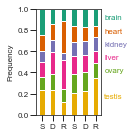

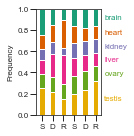

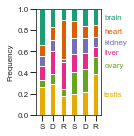

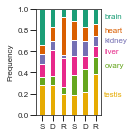

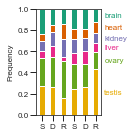

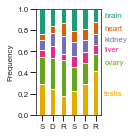

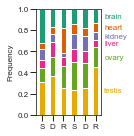

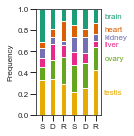

In [23]:
reverse=True

for pp,min_tau,min_max_second_mu_ratio,min_bs in itertools.product(pcm_prefixes, min_taus, min_max_second_mu_ratios, min_bss):
    specificity_term = pp+'muRatio'+str(min_max_second_mu_ratio)+'_minTau'+str(min_tau)+'_minBS'+str(min_bs)
    print(specificity_term)
    observed = dict()
    for event in ['S','D','R']:
        infile = 'shift_count_observed_'+specificity_term+'_'+event+'.tsv'
        observed[event] = pandas.read_csv(infile, sep='\t', header=0, index_col=0)
    num_data = len(observed['S'].index) * len(observed['S'].columns) * len(observed.keys())
    df1 = pandas.DataFrame(index=numpy.arange(num_data), columns=['event','state','organ','shift_value'])
    i=0
    for k in observed.keys():
        for state in ['ancestral','derived']:
            if state=='ancestral':
                axis=1
            elif state=='derived':
                axis=0
            values = observed[k].sum(axis=axis)
            values = values / values.sum()
            next_i = i+len(values)
            #tmp = pandas.DataFrame({'organ':values.index.tolist(), 'shift_value':values.tolist()})
            #tmp['event'] = k
            #tmp['stete'] = state
            df1.loc[i:(next_i-1),'event'] = k
            df1.loc[i:(next_i-1),'state'] = state
            df1.loc[i:(next_i-1),'organ'] = values.index.tolist()
            df1.loc[i:(next_i-1),'shift_value'] = values.tolist()
            df1 = pandas.concat([df1,tmp], ignore_index=True, sort=False)
            i = next_i
    #df1.loc[:,'organ'] = df1['organ'].str.replace('unif.\nτ<0.3', 'unif.')

    #colors = {'brain':'#1B9E77','heart':'#D95F02','kidney':'#7570B3','liver':'#E7298A','ovary':'#66A61E','testis':'#E6AB02'}
    #colors = ['#1B9E77','#D95F02','#7570B3','#E7298A','#66A61E','#E6AB02','darkgray']
    colors = ['#1B9E77','#D95F02','#7570B3','#E7298A','#66A61E','#E6AB02',]
    fig,axes = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize=(2,2), sharex=False)
    ax=axes
    df1 = df1.pivot_table(index=['state','event'], columns='organ', values='shift_value', aggfunc='first').fillna(0)
    df1 = df1.loc[[ (l1,l2) for l1 in ['ancestral', 'derived'] for l2 in branch_categories ],:]
    if reverse:
        df1 = df1.iloc[:,::-1]
        colors.reverse()
    df1.plot.bar(stacked=True, ax=ax, color=colors, legend=False, fontsize=font_size)
    ax.set_xlabel('', fontsize=font_size)
    ax.set_ylabel('Frequency', fontsize=font_size)
    ax.set_xticks(numpy.arange(len(branch_categories)*2), minor=False)
    ax.set_xticks([(len(branch_categories)-1)/2, len(branch_categories)+((len(branch_categories)-1)/2)], minor=True)
    ax.set_xticklabels(branch_categories*2, minor=False, ha='center', rotation=0, fontsize=font_size)
    ax.set_xticklabels(['\nAncestral','\nDerived'], minor=True, ha='center', rotation=0, fontsize=font_size)
    ax.tick_params(axis='x', which='major', direction='out', length=6, width=1)
    ax.tick_params(axis='x', which='minor', direction='out', length=6, width=0)
    ax.tick_params(axis='both', which='major', direction='out', length=6, width=1, pad=2, top=False, right=False)
    ax.set_ylim(0, 1)

    handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1,1), loc=2, fontsize=font_size)

    xmax = 0
    for p in ax.patches:
        xmax = max(xmax, p.get_x())
    rightmost_y_coordinates = list()
    for p in ax.patches:
        if p.get_x()==xmax:
            rightmost_y_coordinates.append(p.get_y())
    rightmost_y_coordinates.append(1)
    rightmost_y_coordinates = numpy.array(rightmost_y_coordinates)[::-1]
    rightmost_y_coordinates = (rightmost_y_coordinates[1:] + rightmost_y_coordinates[:-1]) / 2
    colors.reverse()
    for tis,c,y in zip(labels[::-1], colors, rightmost_y_coordinates):
        ax.text(x=(len(branch_categories)*2)-0.2, y=y, s=tis, fontsize=font_size, color=c, va='center', ha='left')

    fig.tight_layout()
    outbase = 'shift_freq_ancestral_derived_'+specificity_term
    fig.savefig(outbase+".pdf", format='pdf', transparent=True)
    fig.savefig(outbase+".svg", format='svg', transparent=True)


l1ou_fpkm_muRatio0_minTau0_minBS0
3; S-D: D = 0.82, P = 0.0
3; S-R: D = 1.0, P = 0.0
3; D-R: D = 1.0, P = 0.0
l1ou_fpkm_muRatio0_minTau0_minBS99
3; S-D: D = 0.58, P = 2.7e-158
3; S-R: D = 1.0, P = 0.0
3; D-R: D = 1.0, P = 0.0
l1ou_fpkm_muRatio0_minTau0.5_minBS0
3; S-D: D = 1.0, P = 0.0
3; S-R: D = 1.0, P = 0.0
3; D-R: D = 1.0, P = 0.0
l1ou_fpkm_muRatio0_minTau0.5_minBS99
3; S-D: D = 0.94, P = 0.0
3; S-R: D = 0.99, P = 0.0
3; D-R: D = 1.0, P = 0.0
l1ou_tpm_muRatio0_minTau0_minBS0
3; S-D: D = 0.11, P = 2.6e-05
3; S-R: D = 1.0, P = 0.0
3; D-R: D = 1.0, P = 0.0
l1ou_tpm_muRatio0_minTau0_minBS99
3; S-D: D = 0.24, P = 3e-25
3; S-R: D = 1.0, P = 0.0
3; D-R: D = 1.0, P = 0.0
l1ou_tpm_muRatio0_minTau0.5_minBS0
3; S-D: D = 0.99, P = 0.0
3; S-R: D = 0.65, P = 6.6e-199
3; D-R: D = 0.95, P = 0.0
l1ou_tpm_muRatio0_minTau0.5_minBS99
3; S-D: D = 0.9, P = 0.0
3; S-R: D = 0.74, P = 2.3e-268
3; D-R: D = 0.93, P = 0.0


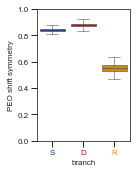

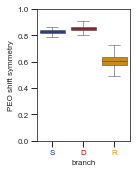

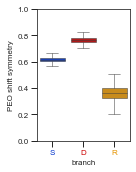

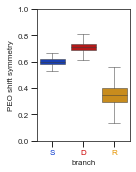

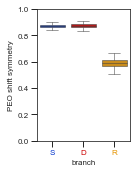

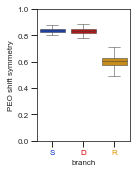

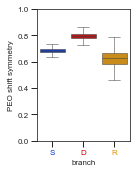

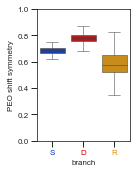

In [24]:
ylab = 'PEO shift symmetry'
nrep = 1000
orders = branch_categories

def get_bootstrap(df):
    num_category = numpy.prod(df.shape)
    fill_series = pandas.Series([0,]*num_category)
    shape = df.shape
    x = df.values.flatten()
    size = x.sum().astype(int)
    ind = numpy.arange(0,x.shape[0])
    p = x/size
    rand = numpy.random.choice(a=ind, size=size, p=p)
    count = pandas.Series(rand).value_counts().add(fill_series).fillna(0).values
    table = numpy.reshape(a=count, newshape=shape)
    return table

for pp,min_tau,min_max_second_mu_ratio,min_bs in itertools.product(pcm_prefixes, min_taus, min_max_second_mu_ratios, min_bss):
    specificity_term = pp+'muRatio'+str(min_max_second_mu_ratio)+'_minTau'+str(min_tau)+'_minBS'+str(min_bs)
    print(specificity_term)
    observed = dict()
    for event in ['S','D','R']:
        infile = 'shift_count_observed_'+specificity_term+'_'+event+'.tsv'
        observed[event] = pandas.read_csv(infile, sep='\t', header=0, index_col=0)

    fig,axes = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize=(1.7,2.2), sharex=False)
    ax = axes
    #axes = axes.flat
    dat = observed

    resampled_symmetry = dict()

    for event in branch_categories:
        resampled_symmetry[event] = pandas.DataFrame(index=numpy.arange(nrep), columns=['event','value'])
        resampled_symmetry[event]['event'] = event
        for i in numpy.arange(nrep):
            bs_table = get_bootstrap(df=observed[event])
            resampled_symmetry[event].loc[i,'value'] = calc_symmetry(pivot_table=bs_table)    
    df_bp = pandas.concat(resampled_symmetry)
    df_bp = df_bp.reset_index()
    df_bp['x'] = 0
    x = 0
    for ev in branch_categories:
        df_bp.loc[(df_bp.event==ev),'x'] = x
        x += 1
    df_bp['value'] = df_bp['value'].astype(float)
    seaborn.boxplot(x='event', y='value', data=df_bp, fliersize=0, palette=category_colors.values(), 
                    order=category_colors.keys(), linewidth=0.5)
    ax.set_xlim(-0.5, len(branch_categories)-0.5)
    ax.set_ylim(0, 1)
    ax.set_xlabel('branch')
    ax.set_ylabel(ylab, fontsize=font_size)
    ax.tick_params(axis='both', which='major', direction='out', length=6, width=1, pad=2, top=False, right=False, labelsize=font_size)
    ax.set_xticks(numpy.arange(len(branch_categories)))
    ax.set_xticklabels(labels=branch_categories, fontsize=font_size)
    [t.set_color(category_colors[t.get_text()]) for t in ax.get_xticklabels(minor=False) ]

    for bc1,bc2 in itertools.combinations(branch_categories, 2):
        v1 = df_bp.loc[(df_bp['event']==bc1),'value'].values
        v2 = df_bp.loc[(df_bp['event']==bc2),'value'].values
        statistic,pvalue = scipy.stats.ks_2samp(v1, v2, alternative='two-sided', mode='auto')
        print('{}; {}-{}: D = {:.2}, P = {:.2}'.format(x, bc1, bc2, statistic, pvalue))
    
    fig.tight_layout(pad=0)
    outbase = 'shift_symmetry2_'+specificity_term
    fig.savefig(outbase+".pdf", format='pdf', transparent=True)
    fig.savefig(outbase+".svg", format='svg', transparent=True)

l1ou_fpkm_muRatio0_minTau0_minBS0
S-D: pearsonr = 0.601615621885016, spearmanr = 0.5981974295684188
S-R: pearsonr = 0.20616978664149052, spearmanr = 0.2769368382524662
D-R: pearsonr = 0.5270126462152529, spearmanr = 0.5649705247837534
l1ou_fpkm_muRatio0_minTau0_minBS99
S-D: pearsonr = 0.5309322972593387, spearmanr = 0.5482794034168859
S-R: pearsonr = 0.05154543361868519, spearmanr = 0.16124369271160363
D-R: pearsonr = 0.6556653003532937, spearmanr = 0.6545881271370931
l1ou_tpm_muRatio0_minTau0_minBS0
S-D: pearsonr = 0.9219567897634421, spearmanr = 0.8541226268521085
S-R: pearsonr = 0.7038241612457165, spearmanr = 0.6221753162382043
D-R: pearsonr = 0.8076823113985413, spearmanr = 0.6353819378663778
l1ou_tpm_muRatio0_minTau0_minBS99
S-D: pearsonr = 0.8809955210373743, spearmanr = 0.8283234981036648
S-R: pearsonr = 0.6230748608544636, spearmanr = 0.5867543583327695
D-R: pearsonr = 0.8597693023670354, spearmanr = 0.6422681347070208
l1ou_fpkm_muRatio0_minTau0.5_minBS0
S-D: pearsonr = 0.6517

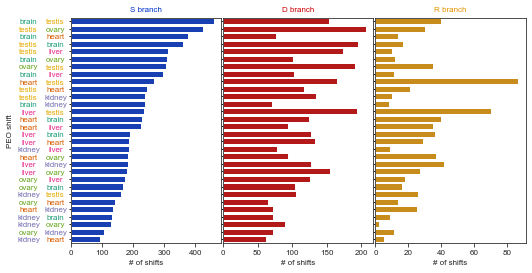

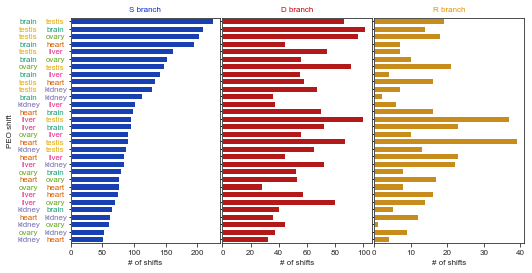

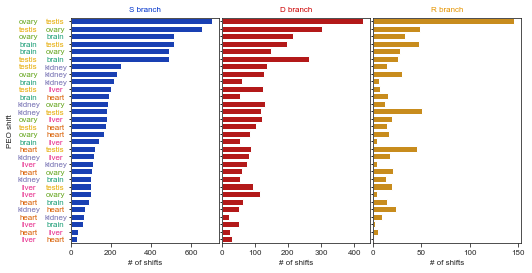

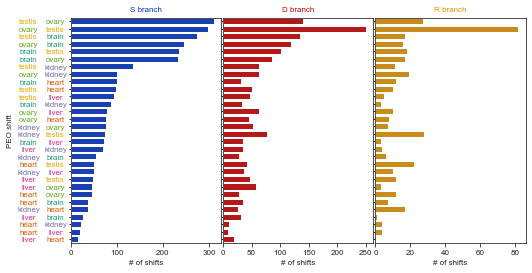

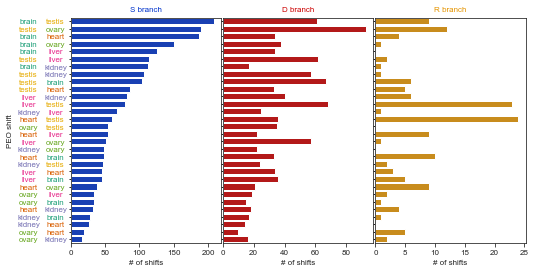

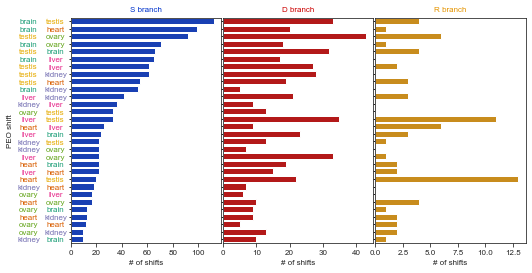

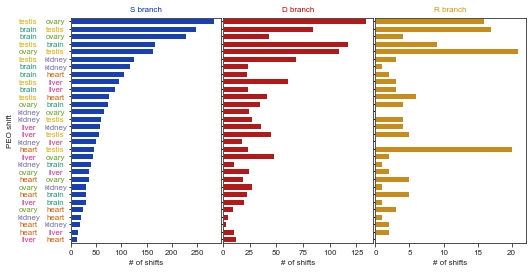

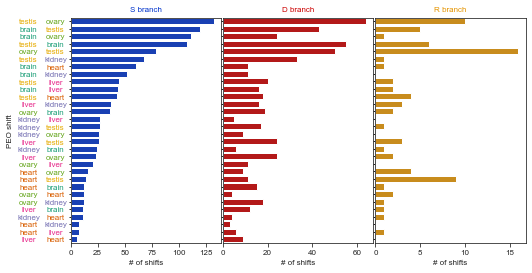

In [25]:
dfs = dict()
for min_tau,pp,min_bs in itertools.product(min_taus,pcm_prefixes,min_bss):
    specificity_term = pp+'muRatio'+str(min_max_second_mu_ratio)+'_minTau'+str(min_tau)+'_minBS'+str(min_bs)
    print(specificity_term)
    for event in ['All','S','D','R']:
        tmp = pandas.read_csv('stack_shift_count_observed_'+specificity_term+'_'+event+'.tsv', sep='\t', header=0, index_col=[0,1])
        dfs[specificity_term+'_'+event] = tmp['0']
    fig,axes = matplotlib.pyplot.subplots(nrows=1, ncols=3, figsize=(7.2,3.6), sharex=False)
    axes = axes.flat
    df_plot = dict()
    for i,event in enumerate(['S','D','R']):
        tmp = dfs[specificity_term+'_'+event]
        tmp = tmp.reset_index()
        tmp.columns = ['from','to','count']
        tmp['y'] = tmp['from'] + '→' + tmp['to']
        tmp = tmp.loc[(tmp['from']!=tmp['to']),:]
        if i==0:
            tmp = tmp.sort_values(by='count', ascending=False)
            sorted_y = tmp.loc[:,'y']
            sorted_y = pandas.DataFrame({'y':sorted_y})
        else:
            tmp = pandas.merge(sorted_y, tmp, sort=False)
        df_plot[event] = tmp
    for i,event in enumerate(['S','D','R']):
        ax = axes[i]
        color = category_colors[event]
        seaborn.barplot(x='count', y='y', data=df_plot[event], orient='h', color=color, ax=ax)
        ax.set_xlabel('# of shifts')
        if event=='S':
            ax.set_ylabel('PEO shift')
            yticks = numpy.arange(0, df_plot[event].shape[0])
            ax.set_yticks(yticks, minor=False)
            ax.set_yticks(yticks+1e-3, minor=True)
            ax.set_yticklabels(df_plot[event]['from'], minor=False, ha='center')
            ax.set_yticklabels(df_plot[event]['to'], minor=True, ha='center')
            ax.tick_params(axis='y', which='major', direction='out', length=2, width=1, pad=40)
            ax.tick_params(axis='y', which='minor', direction='out', length=0, width=1, pad=15)
            [t.set_color(organ_colors_dict[t.get_text()]) for t in ax.get_yticklabels(minor=False) ]
            [t.set_color(organ_colors_dict[t.get_text()]) for t in ax.get_yticklabels(minor=True) ]
        else:
            ax.set_ylabel('')
            ax.tick_params(axis='y', which='major', direction='out', length=2, width=1, pad=0)
            ax.set_yticklabels([''] * len(ax.get_yticklabels()))
        ax.set_title(event+' branch', fontsize=font_size, color=color)

    fig.tight_layout(pad=0)
    outbase = 'PEO_shift_hist_'+specificity_term
    fig.savefig(outbase+".pdf", format='pdf', transparent=True)
    fig.savefig(outbase+".svg", format='svg', transparent=True)

    for pair in itertools.combinations(['S','D','R'], 2):
        pout = scipy.stats.pearsonr(df_plot[pair[0]]['count'], df_plot[pair[1]]['count'])
        sout = scipy.stats.spearmanr(df_plot[pair[0]]['count'], df_plot[pair[1]]['count'])
        print('{}-{}: pearsonr = {}, spearmanr = {}'.format(pair[0], pair[1], pout[0], sout.correlation))

l1ou_fpkm_muRatio0_minTau0_minBS0
S-D: pearsonr = 0.5410168526762561, spearmanr = 0.5715239154616241
S-R: pearsonr = 0.1753212146871715, spearmanr = 0.27252502780867627
D-R: pearsonr = 0.5286843487244848, spearmanr = 0.5813125695216907
l1ou_fpkm_muRatio0_minTau0_minBS0
S-D: pearsonr = 0.5022875522939251, spearmanr = 0.5483870967741935
S-R: pearsonr = 0.20135883538135968, spearmanr = 0.24404894327030033
D-R: pearsonr = 0.5729216714132666, spearmanr = 0.585761957730812
l1ou_fpkm_muRatio0_minTau0_minBS0
S-D: pearsonr = 0.5656209274037655, spearmanr = 0.6080088987764182
S-R: pearsonr = 0.35329095449106834, spearmanr = 0.42869855394883205
D-R: pearsonr = 0.670835879217093, spearmanr = 0.6809788654060066
l1ou_fpkm_muRatio0_minTau0_minBS0
S-D: pearsonr = 0.6614350376280237, spearmanr = 0.7139043381535038
S-R: pearsonr = 0.5010578221385856, spearmanr = 0.5546162402669632
D-R: pearsonr = 0.743101018784715, spearmanr = 0.7228031145717464
l1ou_fpkm_muRatio0_minTau0_minBS99
S-D: pearsonr = 0.45321

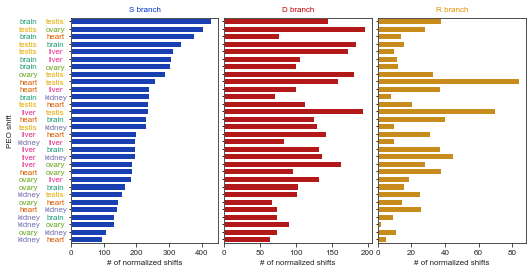

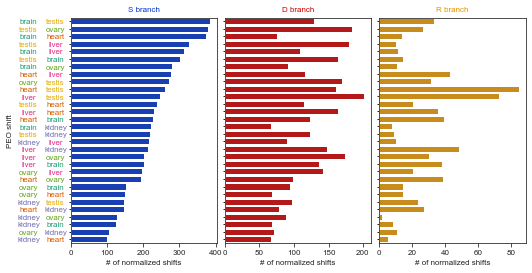

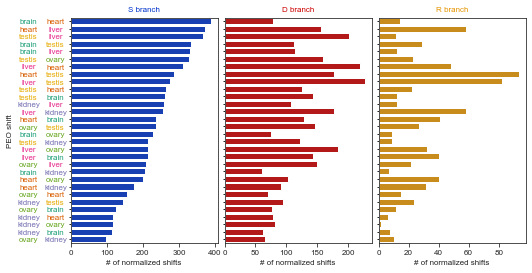

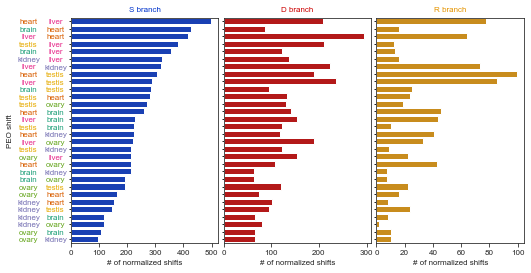

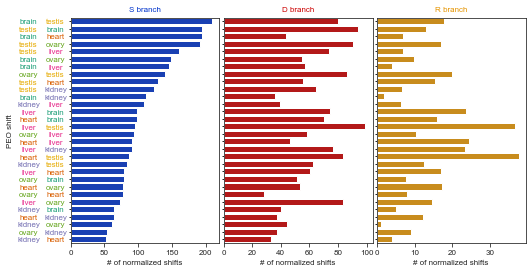

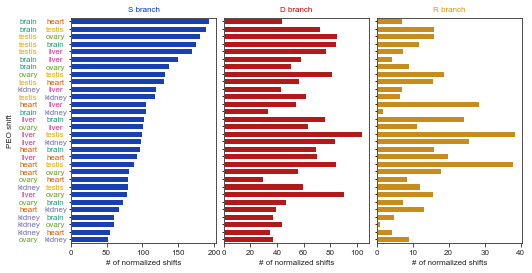

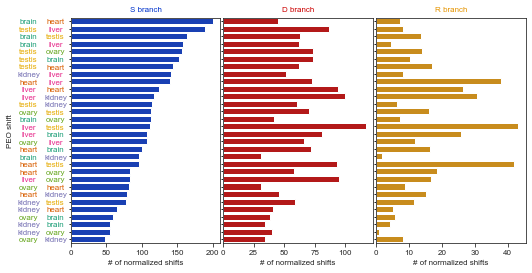

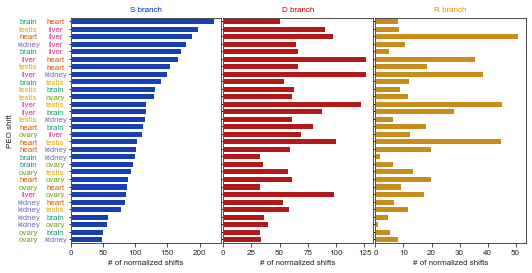

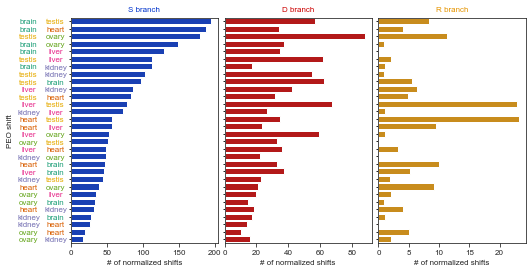

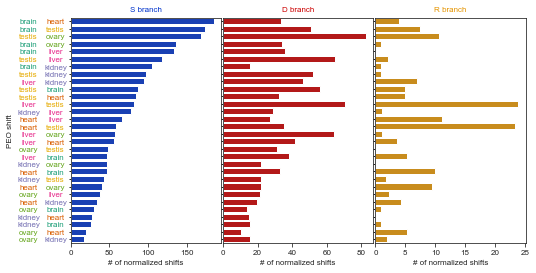

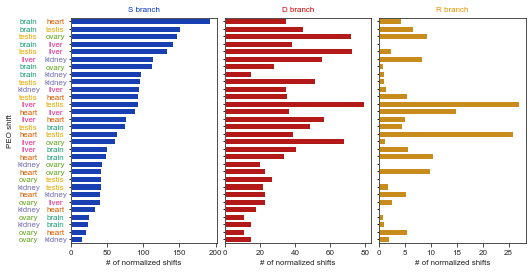

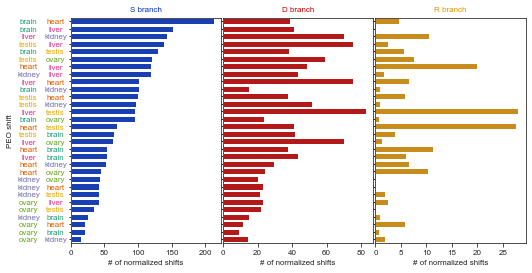

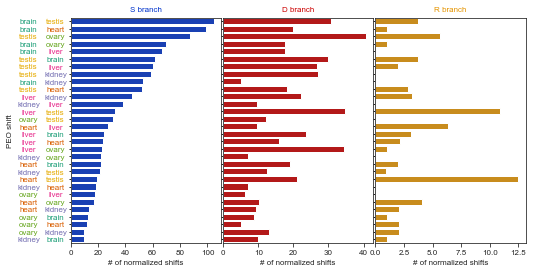

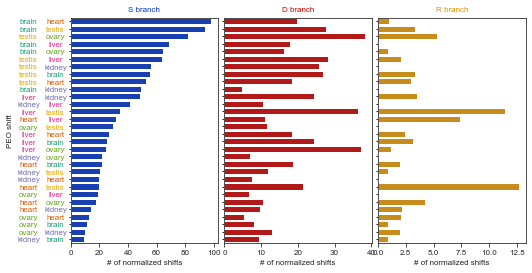

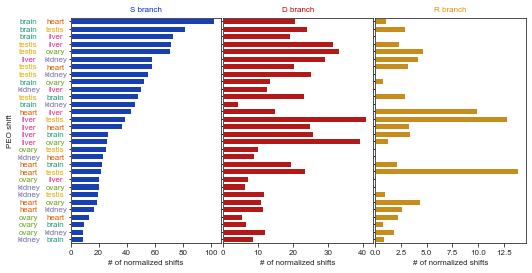

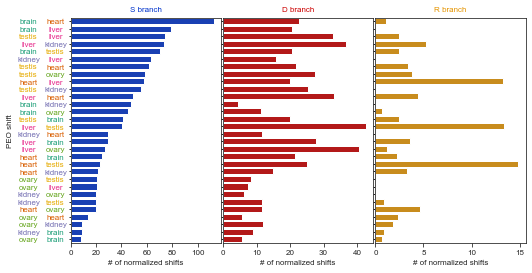

In [26]:
thresholds = [0.1,1,3,5]

# read transcriptomes
dir_tissue_mean = '/Users/kef74yk/Dropbox_p/db/Ensembl/release-91/curated_transcriptome/2018_5_1/tpm/tissue_mean'
tcs = dict()
for sp in spp:
    file = os.path.join(dir_tissue_mean, sp.replace(' ','_')+'.tissue.mean.tsv')
    tcs[sp] = pandas.read_csv(file, sep='\t', header=0, index_col=0)

# calc expression ratio
expressed_ratio = pandas.DataFrame()
for sp,threshold in itertools.product(spp, thresholds):
    num_gene = tcs[sp].shape[0]
    tmp = (tcs[sp]>threshold).sum()/num_gene
    tmp['species'] = sp
    tmp['threshold'] = threshold
    tmp['num_gene'] = num_gene
    tmp = tmp.to_frame().T
    expressed_ratio = pandas.concat([expressed_ratio,tmp], ignore_index=True)

# plot
dfs = dict()
for min_tau,pp,min_bs,threshold in itertools.product(min_taus,['l1ou_fpkm_'],min_bss,thresholds):
    specificity_term = pp+'muRatio'+str(min_max_second_mu_ratio)+'_minTau'+str(min_tau)+'_minBS'+str(min_bs)
    print(specificity_term)
    for event in ['All','S','D','R']:
        tmp = pandas.read_csv('stack_shift_count_observed_'+specificity_term+'_'+event+'.tsv', sep='\t', header=0, index_col=[0,1])
        dfs[specificity_term+'_'+event] = tmp['0']
    fig,axes = matplotlib.pyplot.subplots(nrows=1, ncols=3, figsize=(7.2,3.6), sharex=False)
    axes = axes.flat
    df_plot = dict()
    for i,event in enumerate(['S','D','R']):
        tmp = dfs[specificity_term+'_'+event]
        tmp = tmp.reset_index()
        tmp.columns = ['from','to','count']
        tmp['y'] = tmp['from'] + '→' + tmp['to']
        tmp = tmp.loc[(tmp['from']!=tmp['to']),:]
        # Normalization by expressed gene ratio
        er = expressed_ratio.loc[(expressed_ratio['threshold']==threshold),organs].median()
        er = er/er.mean()
        tmp.loc[:,'count_normalized'] = tmp.loc[:,'count']
        tmp.loc[:,'count_normalized'] /= er[tmp['from']].values
        tmp.loc[:,'count_normalized'] /= er[tmp['to']].values
        if i==0:
            tmp = tmp.sort_values(by='count_normalized', ascending=False)
            sorted_y = tmp.loc[:,'y']
            sorted_y = pandas.DataFrame({'y':sorted_y})
        else:
            tmp = pandas.merge(sorted_y, tmp, sort=False)
        df_plot[event] = tmp
    for i,event in enumerate(['S','D','R']):
        ax = axes[i]
        color = category_colors[event]
        seaborn.barplot(x='count_normalized', y='y', data=df_plot[event], orient='h', color=color, ax=ax)
        #ax.set_xlim(0,xymax)
        #ax.set_ylim(0,xymax)
        ax.set_xlabel('# of normalized shifts')
        if event=='S':
            ax.set_ylabel('PEO shift')
            yticks = numpy.arange(0, df_plot[event].shape[0])
            ax.set_yticks(yticks, minor=False)
            ax.set_yticks(yticks+1e-3, minor=True)
            ax.set_yticklabels(df_plot[event]['from'], minor=False, ha='center')
            ax.set_yticklabels(df_plot[event]['to'], minor=True, ha='center')
            ax.tick_params(axis='y', which='major', direction='out', length=2, width=1, pad=40)
            ax.tick_params(axis='y', which='minor', direction='out', length=0, width=1, pad=15)
            [t.set_color(organ_colors_dict[t.get_text()]) for t in ax.get_yticklabels(minor=False) ]
            [t.set_color(organ_colors_dict[t.get_text()]) for t in ax.get_yticklabels(minor=True) ]
        else:
            ax.set_ylabel('')
            ax.tick_params(axis='y', which='major', direction='out', length=2, width=1, pad=0)
            ax.set_yticklabels([''] * len(ax.get_yticklabels()))
        ax.set_title(event+' branch', fontsize=font_size, color=color)

    fig.tight_layout(pad=0)
    outbase = 'PEO_shift_numExpressedGeneNormalized_'+specificity_term+'_expThreshold'+str(threshold)
    fig.savefig(outbase+".pdf", format='pdf', transparent=True)
    fig.savefig(outbase+".svg", format='svg', transparent=True)

    for pair in itertools.combinations(['S','D','R'], 2):
        pout = scipy.stats.pearsonr(df_plot[pair[0]]['count_normalized'], df_plot[pair[1]]['count_normalized'])
        sout = scipy.stats.spearmanr(df_plot[pair[0]]['count_normalized'], df_plot[pair[1]]['count_normalized'])
        print('{}-{}: pearsonr = {}, spearmanr = {}'.format(pair[0], pair[1], pout[0], sout.correlation))
        

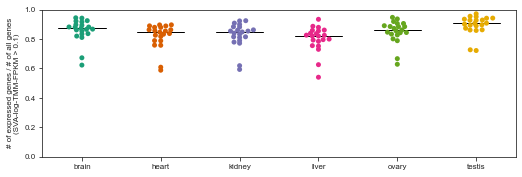

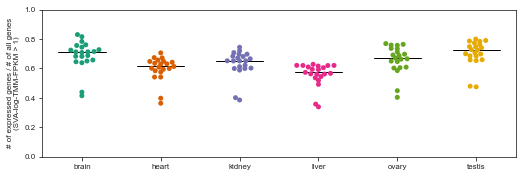

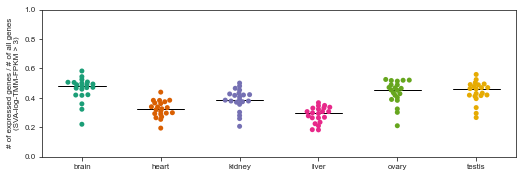

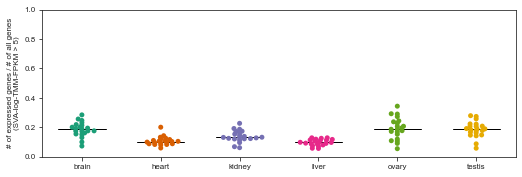

In [27]:
for threshold in thresholds:
    fig,axes = matplotlib.pyplot.subplots(nrows=1, ncols=1, figsize=(7.2,2.4), sharex=False)
    #axes = axes.flat
    tmp1 = expressed_ratio.loc[(expressed_ratio['threshold']==threshold),organs]
    tmp = tmp1.stack().reset_index().drop('level_0', axis=1)
    tmp.columns = ['organ','expressed_gene_ratio']
    median_y = tmp1.median().values
    median_x_from = numpy.arange(len(median_y))-0.3
    median_x_to = numpy.arange(len(median_y))+0.3
    
    ax = axes
    seaborn.swarmplot(x='organ', y='expressed_gene_ratio', data=tmp, ax=ax, palette=organ_colors)
    ax.plot([median_x_from,median_x_to],[median_y,median_y], color='black', lw=1)
    ax.set_ylim(0, 1)
    ax.set_ylabel('# of expressed genes / # of all genes\n(SVA-log-TMM-FPKM > '+str(threshold)+')')
    ax.set_xlabel('')
    
    fig.tight_layout(pad=0.5)
    outbase = 'ExpressedGeneRate_expThreshold'+str(threshold)
    fig.savefig(outbase+".pdf", format='pdf', transparent=True)
    fig.savefig(outbase+".svg", format='svg', transparent=True)

In [28]:
event_combinations = list(itertools.combinations(branch_categories, 2))
print('event_combinations:', event_combinations)

for pp in pcm_prefixes:
    for min_tau in min_taus:
        for min_max_second_mu_ratio in min_max_second_mu_ratios:
            for min_bs in min_bss:
                specificity_term = pp+'muRatio'+str(min_max_second_mu_ratio)+'_minTau'+str(min_tau)+'_minBS'+str(min_bs)
                print(specificity_term)
                observed = dict()
                corrected = dict()
                for event in ['S','D','R']:
                    infile = 'shift_count_observed_'+specificity_term+'_'+event+'.tsv'
                    observed[event] = pandas.read_csv(infile, sep='\t', header=0, index_col=0)
                    infile2 = 'shift_count_corrected_'+specificity_term+'_'+event+'.tsv'
                    corrected[event] = pandas.read_csv(infile2, sep='\t', header=0, index_col=0)

                for event_combination in event_combinations:
                    tested_values = observed
                    e1 = event_combination[0]
                    e2 = event_combination[1]
                    tmp = tested_values[e1]; tmp1 = tmp.values.reshape(tmp.shape[0]*tmp.shape[1])
                    tmp = tested_values[e2]; tmp2 = tmp.values.reshape(tmp.shape[0]*tmp.shape[1])
                    ctable = numpy.array([tmp1,tmp2])
                    ctable = ctable[:,(ctable.sum(axis=0)>0)]
                    out = scipy.stats.chi2_contingency(ctable, correction=True, lambda_=None)
                    print('ancestral-derived', e1, e2, 'pvalue =', out[1], 'chi2 stat =', out[0])

                for event_combination in event_combinations:
                    tested_values = observed
                    e1 = event_combination[0]
                    e2 = event_combination[1]
                    tmp = tested_values[e1]; tmp1 = tmp.values.sum(axis=0)
                    tmp = tested_values[e2]; tmp2 = tmp.values.sum(axis=0)
                    ctable = numpy.array([tmp1,tmp2])
                    ctable = ctable[:,(ctable.sum(axis=0)>0)]
                    out = scipy.stats.chi2_contingency(ctable, correction=True, lambda_=None)
                    print('only derived', e1, e2, 'pvalue =', out[1], 'chi2 stat =', out[0])

                for event in branch_categories:
                    tmp = observed[event]
                    tmp = tmp.values.reshape(tmp.shape[0]*tmp.shape[1])
                    tmp = tmp/tmp.sum()
                    out = scipy.stats.chisquare(tmp)
                    print('ancestral-derived', event, 'pvalue =', out[1], 'chi2 stat =', out[0])

                for event in branch_categories:
                    tmp = observed[event]
                    tmp = tmp.values.sum(axis=0)
                    tmp = tmp/tmp.sum()
                    out = scipy.stats.chisquare(tmp)
                    print('only derived', event, 'pvalue =', out[1], 'chi2 stat =', out[0])

                for event in branch_categories:
                    tmp = observed[event]
                    dif = 0
                    organs = list(set(tmp.index.tolist()).intersection(set(tmp.columns.tolist())))
                    for i in itertools.combinations(organs, 2):
                        if i[0]!=i[1]:
                            dif = dif + numpy.abs(tmp.loc[i[0],i[1]] - tmp.loc[i[1],i[0]])
                    symmetry = 1 - (dif/tmp.sum().sum())
                    print(event, 'symmetry of the number of shift =', symmetry)

                for event in branch_categories:
                    tmp = corrected[event]
                    dif = 0
                    organs = list(set(tmp.index.tolist()).intersection(set(tmp.columns.tolist())))
                    for i in itertools.combinations(organs, 2):
                        if i[0]!=i[1]:
                            dif = dif + numpy.abs(tmp.loc[i[0],i[1]] - tmp.loc[i[1],i[0]])
                    symmetry = 1 - (dif/tmp.sum().sum())
                    print(event, 'symmetry of the acceleration of shift =', symmetry)

                print()

event_combinations: [('S', 'D'), ('S', 'R'), ('D', 'R')]
l1ou_fpkm_muRatio0_minTau0_minBS0
ancestral-derived S D pvalue = 1.1645425725499324e-33 chi2 stat = 232.6015555526961
ancestral-derived S R pvalue = 3.15741388058073e-54 chi2 stat = 337.26871370739775
ancestral-derived D R pvalue = 7.322841049325359e-27 chi2 stat = 196.83199619773367
only derived S D pvalue = 0.0006312751579895948 chi2 stat = 21.57219097992501
only derived S R pvalue = 5.727871322112838e-17 chi2 stat = 85.56596341989552
only derived D R pvalue = 4.704916901656827e-10 chi2 stat = 52.28968702326899
ancestral-derived S pvalue = 1.0 chi2 stat = 0.3880086372405372
ancestral-derived D pvalue = 1.0 chi2 stat = 0.35234780855959336
ancestral-derived R pvalue = 1.0 chi2 stat = 0.8670298787456246
only derived S pvalue = 0.9999968230540931 chi2 stat = 0.020499147605217337
only derived D pvalue = 0.9999840101891352 chi2 stat = 0.03923108052664371
only derived R pvalue = 0.998601936427763 chi2 stat = 0.24143061475321465
S symm

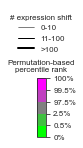

In [29]:
fig = matplotlib.pyplot.figure(figsize=(1, 2.4))
gs = matplotlib.gridspec.GridSpec(nrows=2, ncols=5)
ax0 = matplotlib.pyplot.subplot(gs[0,:])
ax1 = matplotlib.pyplot.subplot(gs[1,2])

ax = ax0
ax.axis('off')
leg_handles = list()
leg_handles.append(matplotlib.lines.Line2D([], [], color='black', label='0-10', linewidth=0.5))
leg_handles.append(matplotlib.lines.Line2D([], [], color='black', label='11-100', linewidth=1))
leg_handles.append(matplotlib.lines.Line2D([], [], color='black', label='>100', linewidth=2))
leg = ax.legend(handles=leg_handles, loc='upper center', frameon=False, fontsize=font_size)
leg.set_title('# expression shift', prop={'weight': 'normal'})
leg.get_title().set_fontsize(font_size)
#leg._legend_box.align = "left"

ax = ax1
cmap = matplotlib.colors.ListedColormap(['#00FF00', '#40C040', '#808080', '#C040C0', '#FF00FF'])
bounds = [1, 2, 3, 4, 5, 6]
ticks = bounds#[1.5,2.5,3.5,4.5,5.5]
ticklabels = ['0%', '0.5%', '2.5%', '97.5%', '99.5%', '100%']
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
title = 'Permutation-based\npercentile rank'
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical', ticks=ticks)
cbar.ax.set_yticklabels(ticklabels, ha='left', fontsize=font_size)
ax.set_title(title, ha='center', fontsize=font_size)


fig.savefig('colorbar_lime_magenta.svg', format='svg', transparent=True)

In [30]:
sra_date = '2018_5_1'
dir_tc = os.path.join(dir_ensembl, 'curated_transcriptome/', sra_date+'/')
dir_sra = os.path.join(dir_ensembl, 'sra/', sra_date)
file_sra = os.path.join(dir_sra, 'sra_table_amalgamated_'+sra_date+'.tsv')
df_sra = pandas.read_csv(file_sra, sep='\t', header=0)

pivot = df_sra.loc[:,['scientific_name','tissue','bioproject']].drop_duplicates().pivot_table(index='scientific_name', columns='tissue', aggfunc='count')
pandas.options.display.max_rows=100
IPython.display.display(pivot)
pandas.options.display.max_rows=10


bioproject                                
tissue                        brain heart kidney liver ovary testis
scientific_name                                                    
Ailuropoda melanoleuca          NaN   NaN    NaN   1.0   1.0    1.0
Anas platyrhynchos              1.0   NaN    NaN   5.0   2.0    NaN
Anolis carolinensis             4.0   3.0    2.0   3.0   2.0    2.0
Aotus nancymaae                 NaN   1.0    1.0   1.0   1.0    NaN
Astyanax mexicanus              4.0   3.0    3.0   2.0   2.0    2.0
Bos taurus                      3.0   5.0    7.0  27.0   7.0   11.0
Callithrix jacchus              3.0   4.0    4.0   7.0   1.0    4.0
Canis lupus                     4.0   4.0    8.0   7.0   1.0    8.0
Cavia porcellus                 1.0   NaN    2.0   3.0   1.0    1.0
Cercocebus atys                 NaN   1.0    1.0   1.0   NaN    NaN
Chinchilla lanigera             1.0   1.0    1.0   1.0   1.0    1.0
Chlorocebus sabaeus             1.0   NaN    1.0   1.0   NaN    NaN
Danio rerio                     7.0   5.0    4.0   5.0   4.0    3.0
Dasypus novemcinctus            NaN   1.0    1.0   1.0   NaN    NaN
Drosophila melanogaster        23.0   1.0    NaN   NaN  64.0   28.0
Equus caballus                  1.0   NaN    1.0   1.0   NaN    6.0
Erinaceus europaeus             1.0   NaN    1.0   1.0   NaN    NaN
Felis catus                     3.0   1.0    2.0   3.0   NaN    2.0
Fukomys damarensis              1.0   NaN    1.0   1.0   1.0    1.0
Gadus morhua                    1.0   1.0    1.0   2.0   1.0    1.0
Gallus gallus                   8.0  14.0   13.0  26.0  13.0   14.0
Gasterosteus aculeatus          6.0   1.0    5.0   3.0   NaN    1.0
Gorilla gorilla                 NaN   1.0    1.0   1.0   NaN    3.0
Homo sapiens                    4.0   4.0    5.0   5.0   2.0    4.0
Lepisosteus oculatus            2.0   2.0    2.0   2.0   1.0    2.0
Macaca fascicularis             2.0   1.0    3.0   4.0   NaN    1.0
Macaca mulatta                 12.0  10.0   12.0  15.0   2.0   17.0
Macaca nemestrina               1.0   1.0    1.0   1.0   NaN    NaN
Meleagris gallopavo             1.0   1.0    NaN   4.0   NaN    NaN
Mesocricetus auratus            2.0   NaN    2.0   3.0   NaN    NaN
Microcebus murinus              NaN   NaN    1.0   3.0   NaN    NaN
Monodelphis domestica           7.0   5.0    5.0   7.0   4.0    8.0
Mus caroli                      1.0   1.0    1.0   2.0   NaN    1.0
Mus musculus                    5.0   3.0    4.0   4.0   2.0    3.0
Mus pahari                      1.0   1.0    1.0   1.0   NaN    NaN
Oreochromis niloticus           3.0   2.0    3.0   8.0   2.0    2.0
Ornithorhynchus anatinus        4.0   3.0    3.0   2.0   3.0    4.0
Oryctolagus cuniculus           2.0   2.0    3.0   5.0   1.0    2.0
Oryzias latipes                 3.0   2.0    1.0   6.0   3.0    4.0
Ovis aries                      4.0   5.0    3.0   8.0   9.0    4.0
Pan paniscus                    NaN   1.0    1.0   1.0   NaN    1.0
Pan troglodytes                 2.0   4.0    4.0   6.0   NaN    3.0
Papio anubis                    1.0   3.0    2.0   3.0   NaN    NaN
Petromyzon marinus              2.0   NaN    1.0   2.0   NaN    1.0
Rattus norvegicus               4.0   4.0    5.0   5.0   3.0    4.0
Rhinopithecus bieti             1.0   1.0    1.0   1.0   NaN    NaN
Saimiri boliviensis             1.0   1.0    1.0   1.0   1.0    NaN
Sus scrofa                      4.0   8.0    9.0  32.0  10.0    9.0
Taeniopygia guttata             2.0   NaN    NaN   NaN   NaN    1.0
Takifugu rubripes               NaN   NaN    2.0   3.0   1.0    2.0
Tupaia belangeri                1.0   NaN    NaN   2.0   NaN    1.0
Xenopus tropicalis              4.0   3.0    4.0   7.0   3.0    3.0

In [31]:
spp = b.loc[b.so_event=='L','taxon'].sort_values().unique()
exp_methods = ['tmm_rpkm','tpm']
for exp_method in exp_methods:
    mydir = os.path.join(dir_tc, exp_method+'/', 'sra/')
    files = os.listdir(mydir)
    files = [ f for f in files if f.endswith('.tsv') ]
    dfpiv = pandas.DataFrame()
    for file in files:
        s = pandas.read_csv(mydir+file, sep='\t', header=0)
        s['count'] = 1
        piv = s.pivot_table(index='exclusion', columns='scientific_name', values='count', aggfunc=sum, fill_value=0)
        dfpiv = pandas.concat([dfpiv, piv], axis=1, sort=True)
    dfpiv = dfpiv.fillna(0).astype(int)
    dfpiv.index = dfpiv.index.str.replace('^no$', 'non_excluded')
    dfpiv = dfpiv.loc[dfpiv.index.sort_values(),dfpiv.columns.sort_values()]
    num_ex = dfpiv.loc[~dfpiv.index.str.contains('non_excluded'),:].sum(axis=0)
    num_nonex = dfpiv.loc['non_excluded',:]
    dfpiv.loc['exclusion_rate (%)',:] = num_ex / (num_ex+num_nonex) * 100
    last_ind = ['non_excluded','exclusion_rate (%)']
    ind = [ i for i in dfpiv.index if i not in last_ind ] + last_ind
    dfpiv = dfpiv.loc[ind,spp]
    dfpiv = dfpiv.loc[dfpiv.sum(axis=1)!=0,:].astype(int)
    outfile = 'exclusion_'+exp_method+'.tsv'
    dfpiv.to_csv(outfile, sep='\t', index=True)

In [32]:
sra_date = '2018_5_1'
#dir_ks = os.path.join(dir_ensembl, 'kallisto_summary/', sra_date)
#dir_fpkm = os.path.join(dir_ks, 'fpkm.tmm.kallisto.gene.log.tsv/')
#dir_tpm = os.path.join(dir_ks, 'tpm.masked.kallisto.gene.log.tsv/')
dir_tc = os.path.join(dir_ensembl, 'curated_transcriptome/', sra_date+'/')
dir_fpkm = os.path.join(dir_tc, 'tmm_rpkm/', 'tc/')
dir_tpm = os.path.join(dir_tc, 'tpm/', 'tc/')
dir_sra = os.path.join(dir_ensembl, 'sra/', sra_date)
file_sra = os.path.join(dir_sra, 'sra_table_amalgamated_'+sra_date+'.tsv')
df_sra = pandas.read_csv(file_sra, sep='\t', header=0)

nsample = 1000

# GAPDH https://www.ensembl.org/Homo_sapiens/Gene/Compara_Ortholog?db=core;g=ENSG00000111640;r=12:6534512-6538374
species_genes = [
    ['Anolis carolinensis','ENSACAG00000006502'],
    ['Astyanax mexicanus','ENSAMXG00000039361'],
    ['Bos taurus','ENSBTAG00000014731'],
    ['Callithrix jacchus','ENSCJAG00000008234'], # spermatogenic
    ['Canis lupus','ENSCAFG00000007743'],
    ['Chinchilla lanigera','ENSCLAG00000013783'],
    ['Danio rerio','ENSDARG00000043457'],
    ['Gadus morhua','ENSGMOG00000010369'],
    ['Gallus gallus','ENSGALG00000014442'],
    ['Homo sapiens','ENSG00000111640'],
    ['Macaca mulatta','ENSMMUG00000018679'],
    ['Monodelphis domestica','ENSMODG00000011838'],
    ['Mus musculus','ENSMUSG00000057666'],
    ['Oreochromis niloticus','ENSONIG00000012916'],
    ['Ornithorhynchus anatinus','ENSOANG00000004492'],
    ['Oryctolagus cuniculus','ENSOCUG00000025023'],
    ['Oryzias latipes','ENSORLG00000012224'], # or ENSORLG00020000877, or ENSORLG00015011254
    ['Ovis aries','ENSOARG00000007894'],
    ['Rattus norvegicus','ENSRNOG00000018630'],
    ['Sus scrofa','ENSSSCG00000000694'],
    ['Xenopus tropicalis','ENSXETG00000033975'],
]

def get_subsampled_stat(gene, df_exp, df_sra, nsample, func='median', verbose=False):
    conditions = True
    conditions = conditions & (df_sra['scientific_name']==sci_name)
    conditions = conditions & (df_sra['tissue']==tissue)
    bioprojects = df_sra.loc[conditions,'bioproject'].unique()
    num_bp = len(bioprojects)
    df_sat = pandas.DataFrame({'num_bp':[],'ave_exp':[]})
    for i in numpy.arange(num_bp)+1:
        flag_permutation = False
        counter = 0
        for bps in itertools.combinations(bioprojects, i):
            counter +=1
            if counter>=nsample:
                flag_permutation = True
                break
        if flag_permutation:
            if verbose:
                print('Combinations of {}. Permutation.'.format(i))
            for j in numpy.arange(0, nsample):
                bps = numpy.random.choice(a=bioprojects, size=i, replace=False)
                runs = df_sra.loc[(df_sra['bioproject'].isin(bps)),'run'].unique()
                if func=='mean':
                    ave = df_exp.loc[gene,runs].mean()
                elif func=='median':
                    ave = df_exp.loc[gene,runs].median()                    
                df_sat = df_sat.append({'num_bp':i,'ave_exp':ave}, ignore_index=True)
        else:
            if verbose:
                print('Combinations of {}. Exhaustive. Count of combinations = {}'.format(i, counter))
            for bps in itertools.combinations(bioprojects, i):
                runs = df_sra.loc[(df_sra['bioproject'].isin(bps)),'run'].unique()
                if func=='mean':
                    ave = df_exp.loc[gene,runs].mean()
                elif func=='median':
                    ave = df_exp.loc[gene,runs].median()                    
                df_sat = df_sat.append({'num_bp':i,'ave_exp':ave}, ignore_index=True)
    df_sat.loc[:,'num_bp'] = df_sat.loc[:,'num_bp'].astype(int)
    return df_sat

dfs = dict()
for sg in species_genes:
    sci_name = sg[0]
    gene = sg[1]
    print(sci_name)
    dfs[sci_name] = pandas.DataFrame()
    for exp_key in ['fpkm','tpm']:
        if exp_key=='fpkm':
            file_fpkm = os.path.join(dir_fpkm, sci_name.replace(' ','_')+'.tc.tsv')
            df_exp = pandas.read_csv(file_fpkm, sep='\t', header=0)
        elif exp_key=='tpm':
            file_tpm = os.path.join(dir_tpm, sci_name.replace(' ','_')+'.tc.tsv')
            df_exp = pandas.read_csv(file_tpm, sep='\t', header=0)
        df_sra2 = df_sra.loc[(df_sra['run'].isin(df_exp.columns)),:]
        if gene in df_exp.index:
            for tissue in tissues:
                #file_fpkm = os.path.join(dir_fpkm, sci_name.replace(' ','_')+'.gene.log.tsv')
                #file_tpm = os.path.join(dir_tpm, sci_name.replace(' ','_')+'.gene.log.tsv')
                tmp = get_subsampled_stat(gene, df_exp, df_sra2, nsample)
                tmp['unit'] = exp_key
                tmp['tissue'] = tissue
                dfs[sci_name] = pandas.concat([dfs[sci_name], tmp], ignore_index=True)
        else:
            print('Gene ID ({}) not found in {}'.format(gene, sci_name))



Anolis carolinensis
Astyanax mexicanus
Gene ID (ENSAMXG00000039361) not found in Astyanax mexicanus
Gene ID (ENSAMXG00000039361) not found in Astyanax mexicanus
Bos taurus
Callithrix jacchus
Canis lupus
Chinchilla lanigera
Danio rerio
Gadus morhua
Gallus gallus
Homo sapiens
Macaca mulatta
Monodelphis domestica
Mus musculus
Oreochromis niloticus
Ornithorhynchus anatinus
Oryctolagus cuniculus
Oryzias latipes
Ovis aries
Rattus norvegicus
Sus scrofa
Xenopus tropicalis


Anolis carolinensis found in input.
Astyanax mexicanus not found in input.
Bos taurus found in input.
Callithrix jacchus found in input.
Canis lupus found in input.
Chinchilla lanigera found in input.


/Users/kef74yk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Attempting to set identical bottom == top == 14.64062997997635 results in singular transformations; automatically expanding.
/Users/kef74yk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Attempting to set identical bottom == top == 10.759435623 results in singular transformations; automatically expanding.


Danio rerio found in input.
Gadus morhua found in input.
Gallus gallus found in input.
Homo sapiens found in input.
Macaca mulatta found in input.
Monodelphis domestica found in input.
Mus musculus found in input.
Oreochromis niloticus found in input.
Ornithorhynchus anatinus found in input.
Oryctolagus cuniculus found in input.
Oryzias latipes found in input.
Ovis aries found in input.
Rattus norvegicus found in input.
Sus scrofa found in input.
Xenopus tropicalis found in input.


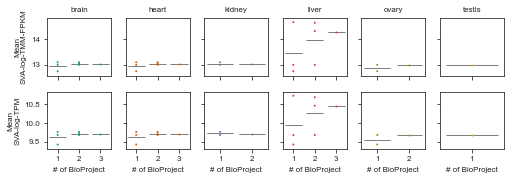

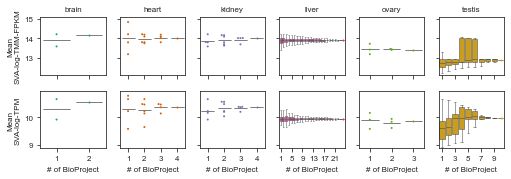

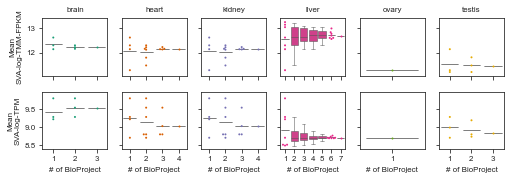

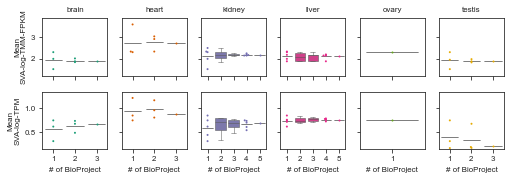

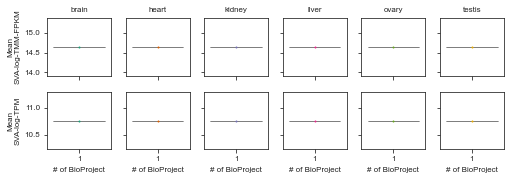

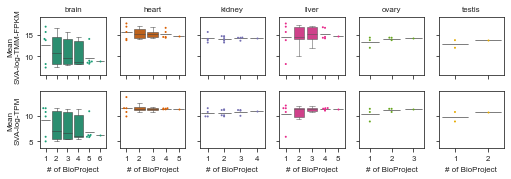

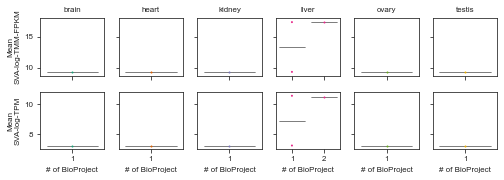

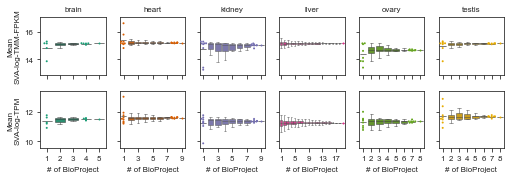

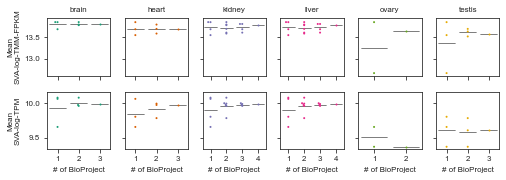

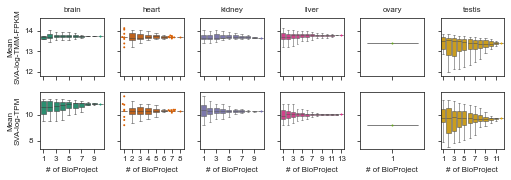

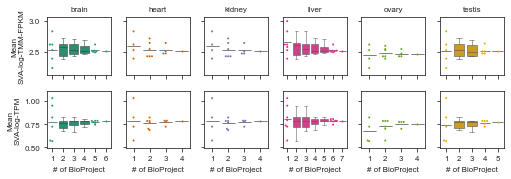

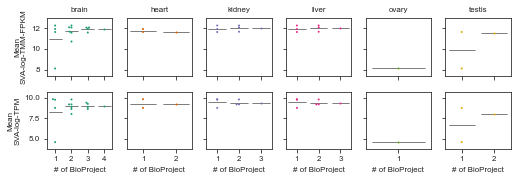

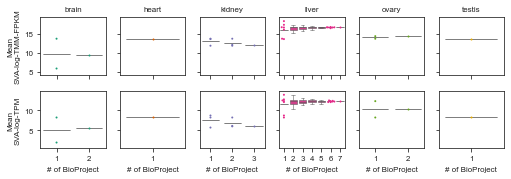

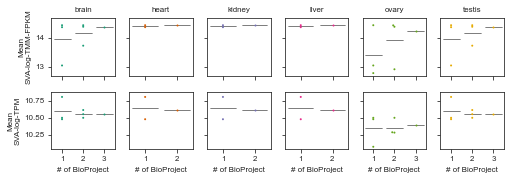

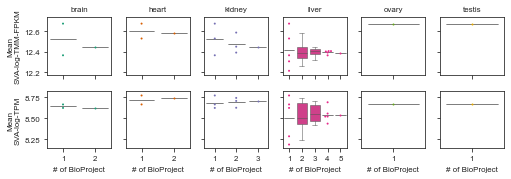

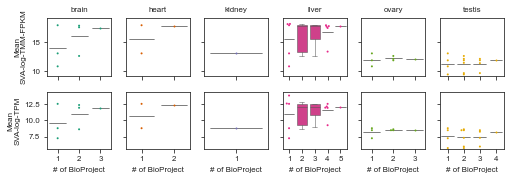

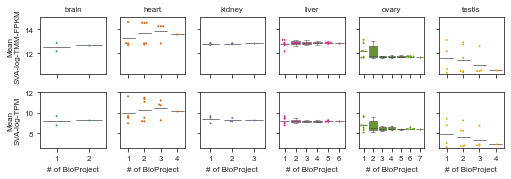

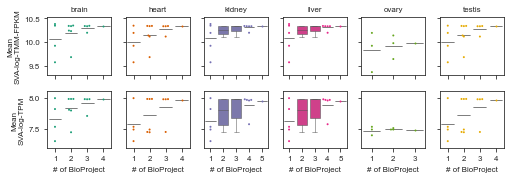

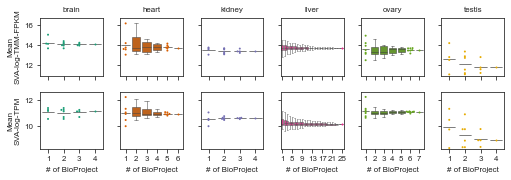

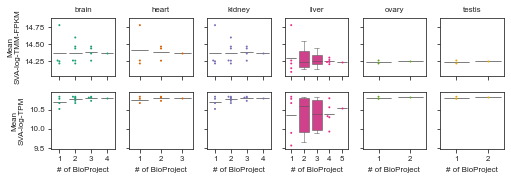

In [33]:

alpha=1

for sg in species_genes:
    sci_name = sg[0]
    gene = sg[1]
    if dfs[sci_name].shape[0]==0:
        print("{} not found in input.".format(sci_name))
    else:
        print("{} found in input.".format(sci_name))
        fig,axes = matplotlib.pyplot.subplots(nrows=2, ncols=6, figsize=(7.2,2.6), sharex=False, sharey=False)
        axes = axes.flat
        i = 0
        for exp_key,ylabel in zip(['fpkm','tpm'],['Mean\nSVA-log-TMM-FPKM','Mean\nSVA-log-TPM']):
            ymin = numpy.inf
            ymax = -numpy.inf
            for tissue in tissues:
                tmp = dfs[sci_name].loc[(dfs[sci_name]['unit']==exp_key)&(dfs[sci_name]['tissue']==tissue),:]
                ymin = min(ymin, tmp['ave_exp'].min())
                ymax = max(ymax, tmp['ave_exp'].max())
                yunit = (ymax-ymin)*0.025
                ymin = ymin - yunit
                ymax = ymax + yunit
            for j,tissue in enumerate(tissues):
                ax = axes[i]
                tmp = dfs[sci_name].loc[(dfs[sci_name]['unit']==exp_key)&(dfs[sci_name]['tissue']==tissue),:]
                count = tmp.groupby('num_bp').count()
                lower_count = count.index[count['ave_exp'] < 10].tolist()
                is_lower = (tmp['num_bp'].isin(lower_count))
                tmp2 = tmp.copy()
                tmp2.loc[~is_lower,'ave_exp'] = numpy.nan
                seaborn.swarmplot('num_bp', 'ave_exp', data=tmp2, ax=ax, size=2,
                                  color=organ_colors[j])
                for num_bp in tmp2['num_bp'].unique():
                    y = tmp2.loc[tmp2['num_bp']==num_bp,'ave_exp'].mean()
                    ax.plot([num_bp-1.4,num_bp-0.6], [y,y], lw=0.5, color='black')
                if any(~is_lower):
                    tmp2 = tmp.copy()
                    tmp2.loc[is_lower,'ave_exp'] = numpy.nan
                    seaborn.boxplot('num_bp', 'ave_exp', data=tmp2, ax=ax, 
                                    color=organ_colors[j], linewidth=0.5, fliersize=0)
                #ax = change_seaborn_boxplot_linecolors(ax, col=organ_colors[j]) 
                ax.set_ylim(ymin, ymax)
                if exp_key=='fpkm':
                    ax.set_title(tissue)
                    ax.set_xlabel('')
                    ax.set_xticklabels(['',] * len(ax.get_xticklabels()))
                else:
                    ax.set_xlabel('# of BioProject')
                if j==0:
                    ax.set_ylabel(ylabel)
                else:
                    ax.set_ylabel('')
                    ax.set_yticklabels(['',] * len(ax.get_yticklabels()))
                while len(ax.get_xticklabels())>8:
                    xticks = ax.get_xticks()[0::2]
                    xticklabels = [ tl._text for tl in ax.get_xticklabels()[0::2] ]
                    ax.set_xticks(ticks=xticks)
                    ax.set_xticklabels(labels=xticklabels)
                i += 1
        fig.tight_layout()
        outbase = 'mean_reversion_'+sci_name.replace(' ','_')+"_"+gene
        fig.savefig(outbase+".pdf", format='pdf', transparent=True)
        fig.savefig(outbase+".svg", format='svg', transparent=True)

In [34]:
import gseapy
import mygene

#library_names = gseapy.get_library_name()

library_names = [
    'KEGG_2019_Human',
    'KEGG_2019_Mouse',
]

bidirectionals = [True,False]
pcm_prefixes = ['l1ou_fpkm_','l1ou_tpm_']
min_taus = [0,0.5]


mg = mygene.MyGeneInfo()
taxids = ','.join(b.taxid.unique().astype(str))

new_wd = os.path.join(wd+'GO_specificity_shift')
if not os.path.exists(new_wd):
    os.mkdir(new_wd)
os.chdir(new_wd)


b_leaf = b.loc[(b['so_event']=='L'),:]

for pp,bidirectional,min_tau in itertools.product(pcm_prefixes, bidirectionals, min_taus):
    organ1s = b['parent_'+pp+'max_organ'].dropna().unique()
    organ2s = b[pp+'max_organ'].dropna().unique()
    events = ['All','S','D','R']

    conditions = True
    conditions = conditions&(b['l1ou_intersect_is_shift']==1)
    conditions = conditions&(b['spnode_coverage']!='root')
    conditions = conditions&(b[pp+'tau']>=min_tau)
    conditions = conditions&(b['parent_'+pp+'tau']>=min_tau)
    b2 = b.loc[conditions,:].reset_index()
    if bidirectional:
        organ_combinat = list(itertools.combinations(set(organ1s).union(set(organ2s)), 2))
        iters = [ [ev,]+list(o) for ev in events for o in organ_combinat ]
    else:
        iters = itertools.product(events, organ1s, organ2s)
    for ev,organ1,organ2 in iters:
        if organ1==organ2:
            continue
        elif organ1>organ2:
            organ1prev = organ1
            organ2prev = organ2
            organ1 = organ2prev
            organ2 = organ1prev
        conditions = True
        if ev!='All':
            conditions = conditions&(b2['branch_category']==ev)
        if bidirectional:
            is_organ_combinat1 = (b2['parent_'+pp+'max_organ']==organ1)&(b2[pp+'max_organ']==organ2)
            is_organ_combinat2 = (b2['parent_'+pp+'max_organ']==organ2)&(b2[pp+'max_organ']==organ1)
            conditions = conditions&(is_organ_combinat1|is_organ_combinat2)
        else:
            conditions = conditions&(b2['parent_'+pp+'max_organ']==organ1)
            conditions = conditions&(b2[pp+'max_organ']==organ2)
        b3 = b2.loc[conditions,['orthogroup',pp+'regime']].reset_index(drop=True)
        if b3.shape[0]==0:
            continue
        gene_ids = pandas.DataFrame()
        for i in b3.index:
            if i%1000==0:
                print(i)
            regime = b3.loc[i,pp+'regime']
            og = b3.loc[i,'orthogroup']
            tmp_gene_ids = b_leaf.loc[(b_leaf[pp+'regime']==regime)&(b_leaf['orthogroup']==og),['orthogroup','node_name']]
            gene_ids = pandas.concat([gene_ids,tmp_gene_ids], sort=False, ignore_index=True)
        gene_ids = gene_ids.drop_duplicates().sort_values(by=['orthogroup','node_name'])
        for sp in ['Homo_sapiens','Mus_musculus']:
            outdir=pp+sp+'_minTau'+str(min_tau)+'_'+organ1+'_'+organ2+'_'+ev
            if bidirectional:
                outdir = 'bidirectional_'+outdir
            df_sp = gene_ids.loc[(gene_ids['node_name'].str.startswith(sp)),:]
            if df_sp.shape[0]==0:
                continue
            df_sp.loc[:,'node_name'] = df_sp.loc[:,'node_name'].replace('.*_','', regex=True)
            df_sp.columns = ['orthogroup','gene_id']
            if not os.path.exists(outdir):
                os.mkdir(outdir)
            df_sp.to_csv(os.path.join(outdir, outdir+'.geneid.tsv'), sep='\t', index=False)
            sp_gene_ids = df_sp.loc[:,'gene_id'].tolist()
            b_mygene = mg.querymany(sp_gene_ids, scopes='ensembl.gene', fields='symbol', species=taxids, as_dataframe=True)
            if b_mygene.columns[0]=='notfound':
                b_mygene = pandas.DataFrame()
            if b_mygene.shape[0]==0:
                continue
            for ln in library_names:
                if (sp=='Homo_sapiens')&('Mouse' in ln):
                    continue
                if (sp=='Mus_musculus')&('Human' in ln):
                    continue
                txt = '{} min_tau={} {} {}-{} {}: #shift={}, #leaf={}, #queryGene={}, {}'
                if bidirectional:
                    txt = txt+' bidirectional'
                else:
                    txt = txt+' unidirectional'
                txt = txt.format(pp, min_tau, ev,organ1,organ2,sp,b3.shape[0],len(gene_ids),len(sp_gene_ids),ln)
                if os.path.isfile(outdir+'/'+ln+'.'+outdir+'.enrichr.reports.txt'):
                    print('Skipped.', txt)
                    continue
                print(txt)
                try:
                    out = gseapy.enrichr(gene_list=b_mygene['symbol'].astype(str).tolist(), description=outdir, gene_sets=ln, outdir=outdir, cutoff=0.05)
                except:
                    print('Error and retry.')
                    try:
                        out = gseapy.enrichr(gene_list=b_mygene['symbol'].astype(str).tolist(), description=outdir, gene_sets=ln, outdir=outdir, cutoff=0.05)
                    except:
                        time.sleep(3)
                        print('The retry failed. Skipped.')
        print('')
print('Done!')

del b_leaf

os.chdir(wd)

0


/Users/kef74yk/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


querying 1-140...done.
Finished.


/Users/kef74yk/anaconda3/lib/python3.6/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


140 input query terms found no hit:
	['ENSG00000204577', 'ENSG00000244482', 'ENSG00000273991', 'ENSG00000274587', 'ENSG00000275290', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-107...done.
Finished.
107 input query terms found no hit:
	['ENSMUSG00000089942', 'ENSMUSG00000095088', 'ENSMUSG00000073968', 'ENSMUSG00000048076', 'ENSMUSG000
Pass "returnall=True" to return complete lists of duplicate or missing query terms.

0
querying 1-86...done.
Finished.
86 input query terms found no hit:
	['ENSG00000211947', 'ENSG00000211966', 'ENSG00000255374', 'ENSG00000255837', 'ENSG00000273092', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-83...done.
Finished.
83 input query terms found no hit:
	['ENSMUSG00000076823', 'ENSMUSG00000076839', 'ENSMUSG00000076846', 'ENSMUSG00000076858', 'ENSMUSG000
Pass "returnall=True" to return complete lists of duplicate or missing query terms.

0
querying 1-

HTTPError: 502 Server Error: Bad Gateway for url: http://mygene.info/v3/query/

In [35]:
#method = ['pvalue', 0.05]
method = ['top', 10]

new_wd = os.path.join(wd+'GO_specificity_shift')

if ('b' in vars()):
    organ1s = b['parent_'+pp+'max_organ'].dropna().unique()
    organ2s = b[pp+'max_organ'].dropna().unique()
else:
    organs = ['brain','heart','kidney','liver','ovary','testis']
    organ1s = organs
    organ2s = organs
events = ['All','S','D','R']

for ln in library_names:
    for sp in ['Homo_sapiens','Mus_musculus']:
        for pp,bidirectional,min_tau in itertools.product(pcm_prefixes, bidirectionals, min_taus):
            if bidirectional:
                summary_wd = os.path.join(new_wd, 'summary_bidirectional_'+method[0]+str(method[1]))
            else:
                summary_wd = os.path.join(new_wd, 'summary_unidirectional_'+method[0]+str(method[1]))
            if not os.path.exists(summary_wd):
                os.mkdir(summary_wd)
            outfile = 'summary_'+ln+'_'+pp+sp+'_minTau'+str(min_tau)+'_'+method[0]+str(method[1])+'.tsv'
            print(outfile)
            dfln = pandas.DataFrame()
            if pp=='l1ou_fpkm_':
                expression_metrics = 'SVA-log-TMM-FPKM'
            elif pp=='l1ou_tpm_':
                expression_metrics = 'SVA-log-TPM'
            if bidirectional:
                organ_combinat = list(itertools.combinations(set(organ1s).union(set(organ2s)), 2))
                iters = [ [ev,]+list(o) for ev in events for o in organ_combinat ]
            else:
                iters = itertools.product(events, organ1s, organ2s)
            for ev,organ1,organ2 in iters:
                if organ1==organ2:
                    continue
                elif organ1>organ2:
                    organ1prev = organ1
                    organ2prev = organ2
                    organ1 = organ2prev
                    organ2 = organ1prev
                outdir=pp+sp+'_minTau'+str(min_tau)+'_'+organ1+'_'+organ2+'_'+ev
                if bidirectional:
                    outdir = 'bidirectional_'+outdir
                ln_file = os.path.join(new_wd, outdir+'/'+ln+'.'+outdir+'.enrichr.reports.txt')
                if os.path.isfile(ln_file):
                    tmp = pandas.read_csv(ln_file, sep='\t', header=0)
                    if method[0]=='pvalue':
                        tmp_sig = tmp.loc[(tmp['Adjusted P-value']<method[1]),:]
                    elif method[0]=='top':
                        tmp_sig = tmp.sort_values(by='Combined Score', ascending=False).iloc[0:method[1],:]
                    if tmp_sig.shape[0]!=0:
                        tmp_sig.loc[:,'branch_category'] = ev
                        tmp_sig.loc[:,'organ1'] = organ1
                        tmp_sig.loc[:,'organ2'] = organ2
                        dfln = pandas.concat([dfln, tmp_sig], ignore_index=True, sort=False)
            dfln.to_csv(os.path.join(summary_wd, outfile), sep='\t', index=False)

summary_KEGG_2019_Human_l1ou_fpkm_Homo_sapiens_minTau0_top10.tsv
summary_KEGG_2019_Human_l1ou_fpkm_Homo_sapiens_minTau0.5_top10.tsv
summary_KEGG_2019_Human_l1ou_fpkm_Homo_sapiens_minTau0_top10.tsv
summary_KEGG_2019_Human_l1ou_fpkm_Homo_sapiens_minTau0.5_top10.tsv
summary_KEGG_2019_Human_l1ou_tpm_Homo_sapiens_minTau0_top10.tsv
summary_KEGG_2019_Human_l1ou_tpm_Homo_sapiens_minTau0.5_top10.tsv
summary_KEGG_2019_Human_l1ou_tpm_Homo_sapiens_minTau0_top10.tsv
summary_KEGG_2019_Human_l1ou_tpm_Homo_sapiens_minTau0.5_top10.tsv
summary_KEGG_2019_Human_l1ou_fpkm_Mus_musculus_minTau0_top10.tsv
summary_KEGG_2019_Human_l1ou_fpkm_Mus_musculus_minTau0.5_top10.tsv
summary_KEGG_2019_Human_l1ou_fpkm_Mus_musculus_minTau0_top10.tsv
summary_KEGG_2019_Human_l1ou_fpkm_Mus_musculus_minTau0.5_top10.tsv
summary_KEGG_2019_Human_l1ou_tpm_Mus_musculus_minTau0_top10.tsv
summary_KEGG_2019_Human_l1ou_tpm_Mus_musculus_minTau0.5_top10.tsv
summary_KEGG_2019_Human_l1ou_tpm_Mus_musculus_minTau0_top10.tsv
summary_KEGG_2019_